# Model Training

In [60]:
# Libraries

import torch
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import os
import random

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

from lime import lime_image
from skimage.segmentation import mark_boundaries

import optuna

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from torch.utils.data import random_split

from torchviz import make_dot
from IPython.display import Image as displayImage

In [61]:
# Hyperparameters
num_epochs = 20
batch_size = 32
learning_rate = 0.001

classes = ['Apple', 'Banana', 'Orange']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom transform to resize and keep the aspect ratio
class ResizeWithAspectRatio:
    def __init__(self, size):
        self.size = size  # The target size (width, height)
    
    def __call__(self, img):
        # Get the original width and height
        w, h = img.size
        target_w, target_h = self.size
        
        # Compute the scaling factor to keep the aspect ratio
        ratio_w = target_w / w
        ratio_h = target_h / h
        ratio = min(ratio_w, ratio_h)  # Use the smaller ratio to fit the image

        # Resize the image while preserving aspect ratio
        new_w = int(w * ratio)
        new_h = int(h * ratio)
        img = img.resize((new_w, new_h), Image.Resampling.LANCZOS)

        # Create a new image with the target size and paste the resized image
        new_img = Image.new("RGB", self.size, (0, 0, 0))  # Black padding
        new_img.paste(img, ((target_w - new_w) // 2, (target_h - new_h) // 2))

        return new_img
    
class RandomCrop:
    def __init__(self, max_crop_pct=0.1):
        # max_crop_pct is a percentage of the width/height of the image
        self.max_crop_pct = max_crop_pct

    def __call__(self, img):
        # Disable cropping if the image is not square
        if img.width != img.height:
            return img  # No cropping, just return the image as it is

        # Calculate max crop amount based on the percentage
        max_crop = int(img.width * self.max_crop_pct)

        # Randomly choose a crop amount
        do_crop = random.choice([True, False])

        if do_crop:
            # Crop the height randomly, keeping width unchanged
            crop_y = random.randint(0, max_crop) + img.width * 0.2
            img = img.crop((0, crop_y, img.width, img.height - crop_y))

        return img
    
transform = transforms.Compose([
    RandomCrop(),
    ResizeWithAspectRatio((64, 64)), 
    transforms.ToTensor()
    #,      
    #transforms.Normalize((0.5,), (0.5,)) # Does much better w/o normalization
])


In [62]:
from typing import Dict, List, Tuple, Union
from pathlib import Path

class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, allowed_classes, transform=None):
        self.allowed_classes = allowed_classes
        super().__init__(root=root, transform=transform)

    def find_classes(self, directory: Union[str, Path]) -> Tuple[List[str], Dict[str, int]]:
        classes, class_to_idx = super().find_classes(directory)
        classes = [class_name for class_name in classes if class_name in self.allowed_classes]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

In [ ]:
'''

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # image size
        self.fc2 = nn.Linear(128, 3)  # 3 output classes 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16) 
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

'''
            
            
            
'''        
def train_model(model, train_loader):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{model.num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}% ({correct} / {total})")


def visualize_predictions(model, test_loader):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) 
        plt.title(f"True: {labels[i].item()}, Pred: {predicted[i].item()}")
        plt.axis('off')
    plt.show()

def visualize_incorrect(model, test_dataset, width = 4, height = 2):
    model.eval()
    loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))
    images, labels = next(iter(loader))
    images, labels = images.to('cuda'), labels.to('cuda')
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    incorrect = 0
    classes = test_dataset.classes
    for i in range(len(test_dataset)):
        if labels[i].item() == predicted[i].item():
            continue
        plt.subplot(height, width, incorrect + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy()) 
        plt.title(f"True: {classes[labels[i].item()]}, Pred: {classes[predicted[i].item()]}")
        plt.axis('off')
        incorrect += 1
        if incorrect == width * height:
            break
    
    
#######

def evaluate_model(model, test_loader, num_classes, device='cpu'):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1) 
            _, predicted = torch.max(outputs, 1)  
            
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    if num_classes > 2:
        roc_auc = roc_auc_score(y_true, y_scores, average='macro', multi_class='ovr')
    else:
        roc_auc = roc_auc_score(y_true, y_scores[:, 1])

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'ROC-AUC': roc_auc
    }
'''

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss.append(epoch_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        correct, total, epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss.append(epoch_loss / len(val_loader))
        val_acc.append(correct / total)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc

# Plot training progress
def plot_training_progress(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Epochs")

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Over Epochs")

    plt.tight_layout()
    plt.show()




    
######

def evaluate_model(model, loader, num_classes):
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            y_scores.extend(probabilities.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    return y_true, y_scores

# Plot ROC curve for each class
def plot_multi_class_roc(y_true, y_scores, num_classes, class_names):
    plt.figure()
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# Plot Precision-Recall curve for each class
def plot_multi_class_precision_recall(y_true, y_scores, num_classes, class_names):
    plt.figure()
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
        avg_precision = average_precision_score(y_true == i, y_scores[:, i])
        plt.plot(recall, precision, label=f"{class_names[i]} (AP = {avg_precision:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Multi-Class Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.show()
    

class CNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  
        self.fc2 = nn.Linear(128, 3)  # 3 output classes
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x    

def objective(trial):
    # Hyperparameter space
    learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.7)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Data preparation
    transform = transforms.Compose([
        RandomCrop(),
        ResizeWithAspectRatio((64, 64)), 
        transforms.ToTensor()
        #,      
        #transforms.Normalize((0.5,), (0.5,)) # Does much better w/o normalization
    ])
    
    train_dataset = CustomImageFolder(root='Datasets\\DiegoP-S\\DatasetSynthesis', transform=transform, allowed_classes=['Apple', 'Banana', 'Orange'])
    val_size = int(0.2 * len(train_dataset))
    train_size = len(train_dataset) - val_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    # Model initialization
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN(dropout_rate).to(device)
    model.apply(init_weights)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # Training
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [64]:
# Datasets: All Original Images

train_dataset = datasets.ImageFolder(root='Datasets\\mbkinaci\\fruit-images-for-object-detection\\train', transform=transform)  
test_dataset = datasets.ImageFolder(root='Datasets\\mbkinaci\\fruit-images-for-object-detection\\test', transform=transform)   

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Epoch 1/20, Train Loss: 1.4121, Val Loss: 1.0400, Train Acc: 0.3955, Val Acc: 0.3636
Epoch 2/20, Train Loss: 1.0621, Val Loss: 1.0517, Train Acc: 0.4409, Val Acc: 0.5273
Epoch 3/20, Train Loss: 0.9659, Val Loss: 0.8096, Train Acc: 0.6000, Val Acc: 0.7273
Epoch 4/20, Train Loss: 0.6399, Val Loss: 0.6295, Train Acc: 0.8045, Val Acc: 0.7273
Epoch 5/20, Train Loss: 0.4497, Val Loss: 0.5136, Train Acc: 0.8045, Val Acc: 0.8182
Epoch 6/20, Train Loss: 0.3576, Val Loss: 0.3522, Train Acc: 0.8636, Val Acc: 0.9091
Epoch 7/20, Train Loss: 0.2814, Val Loss: 0.4055, Train Acc: 0.8864, Val Acc: 0.8545
Epoch 8/20, Train Loss: 0.2346, Val Loss: 0.3565, Train Acc: 0.9091, Val Acc: 0.8909
Epoch 9/20, Train Loss: 0.1748, Val Loss: 0.2824, Train Acc: 0.9364, Val Acc: 0.8909
Epoch 10/20, Train Loss: 0.1521, Val Loss: 0.2802, Train Acc: 0.9273, Val Acc: 0.9455
Epoch 11/20, Train Loss: 0.0995, Val Loss: 0.2898, Train Acc: 0.9545, Val Acc: 0.9273
Epoch 12/20, Train Loss: 0.0849, Val Loss: 0.3040, Train Acc: 0

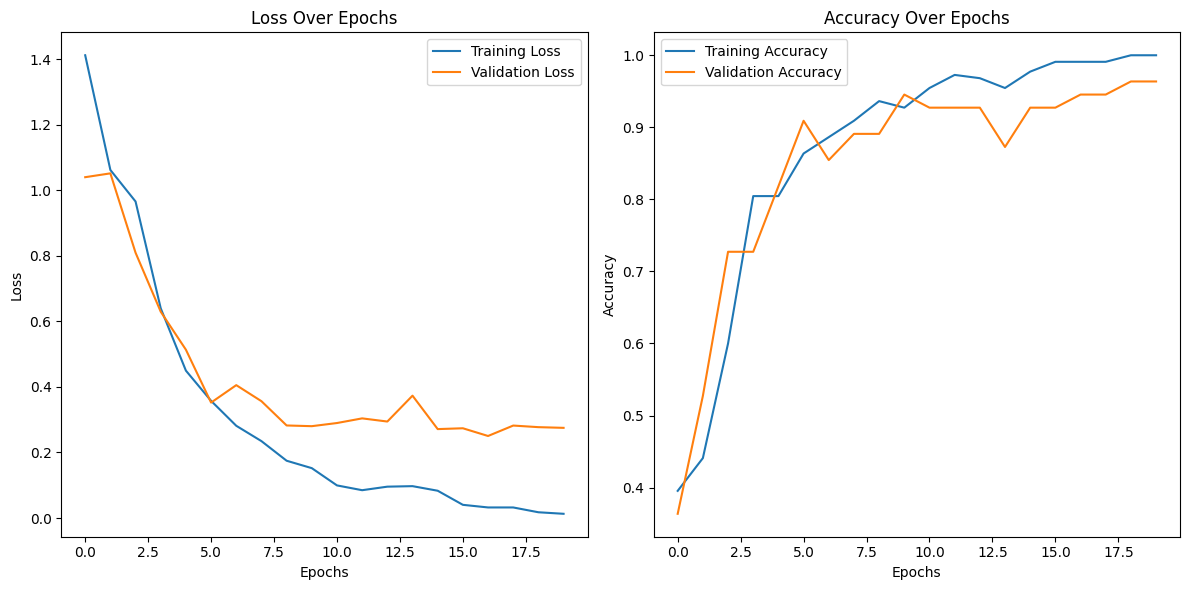

In [65]:
### Model 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Model, loss, and optimizer
model = CNN().to(device)
model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=num_epochs)

plot_training_progress(train_loss, val_loss, train_acc, val_acc)

In [ ]:
# # Evaluate the model
# metrics = evaluate_model(model, test_loader, num_classes=3)
# print("Evaluation Metrics:")
# for metric, value in metrics.items():
#     print(f"{metric}: {value:.4f}")


Evaluation Metrics:


AttributeError: 'tuple' object has no attribute 'items'

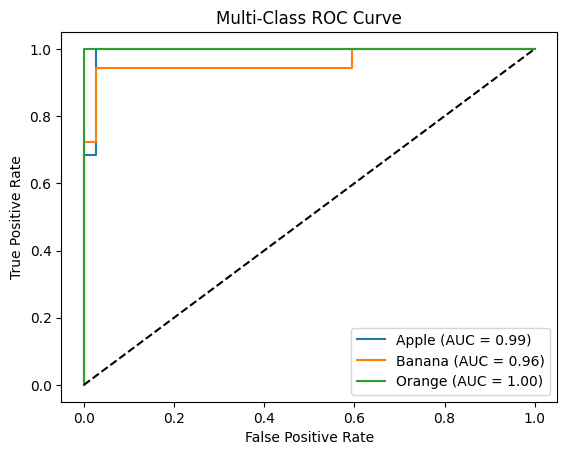

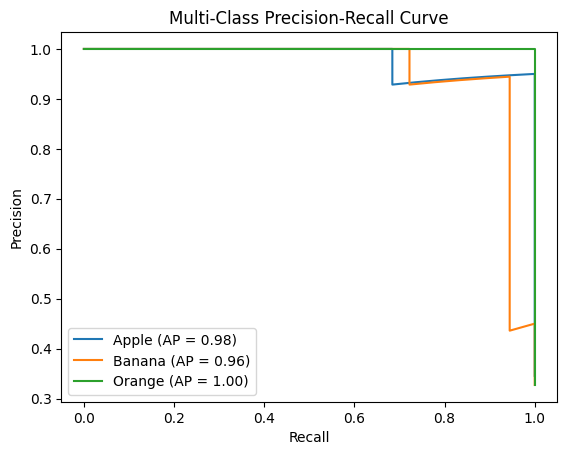

In [68]:
class_names = ["Apple", "Banana", "Orange"]

y_true, y_scores = evaluate_model(model, test_loader, num_classes=len(class_names))

plot_multi_class_roc(y_true, y_scores, num_classes=len(class_names), class_names=class_names)
plot_multi_class_precision_recall(y_true, y_scores, num_classes=len(class_names), class_names=class_names)


In [69]:
# Datasets: All Synthetic Images

train_dataset2 = CustomImageFolder(root='Datasets\\DiegoP-S\\DatasetSynthesis', transform=transform, allowed_classes=class_names)   
train_loader2 = DataLoader(dataset=train_dataset2, batch_size=batch_size, shuffle=True)


Epoch 1/20, Train Loss: 1.3694, Val Loss: 1.1725, Train Acc: 0.3833, Val Acc: 0.5091
Epoch 2/20, Train Loss: 0.9900, Val Loss: 1.0017, Train Acc: 0.5467, Val Acc: 0.6545
Epoch 3/20, Train Loss: 0.7480, Val Loss: 1.1541, Train Acc: 0.7100, Val Acc: 0.6000
Epoch 4/20, Train Loss: 0.5483, Val Loss: 0.7257, Train Acc: 0.7700, Val Acc: 0.7273
Epoch 5/20, Train Loss: 0.4016, Val Loss: 0.5828, Train Acc: 0.8767, Val Acc: 0.8545
Epoch 6/20, Train Loss: 0.3336, Val Loss: 0.5858, Train Acc: 0.8833, Val Acc: 0.8364
Epoch 7/20, Train Loss: 0.2340, Val Loss: 0.5250, Train Acc: 0.9300, Val Acc: 0.8545
Epoch 8/20, Train Loss: 0.2110, Val Loss: 0.6762, Train Acc: 0.9300, Val Acc: 0.9091
Epoch 9/20, Train Loss: 0.1801, Val Loss: 0.5171, Train Acc: 0.9467, Val Acc: 0.8727
Epoch 10/20, Train Loss: 0.1240, Val Loss: 0.6612, Train Acc: 0.9567, Val Acc: 0.8909
Epoch 11/20, Train Loss: 0.1415, Val Loss: 0.5510, Train Acc: 0.9600, Val Acc: 0.9273
Epoch 12/20, Train Loss: 0.1031, Val Loss: 0.6512, Train Acc: 0

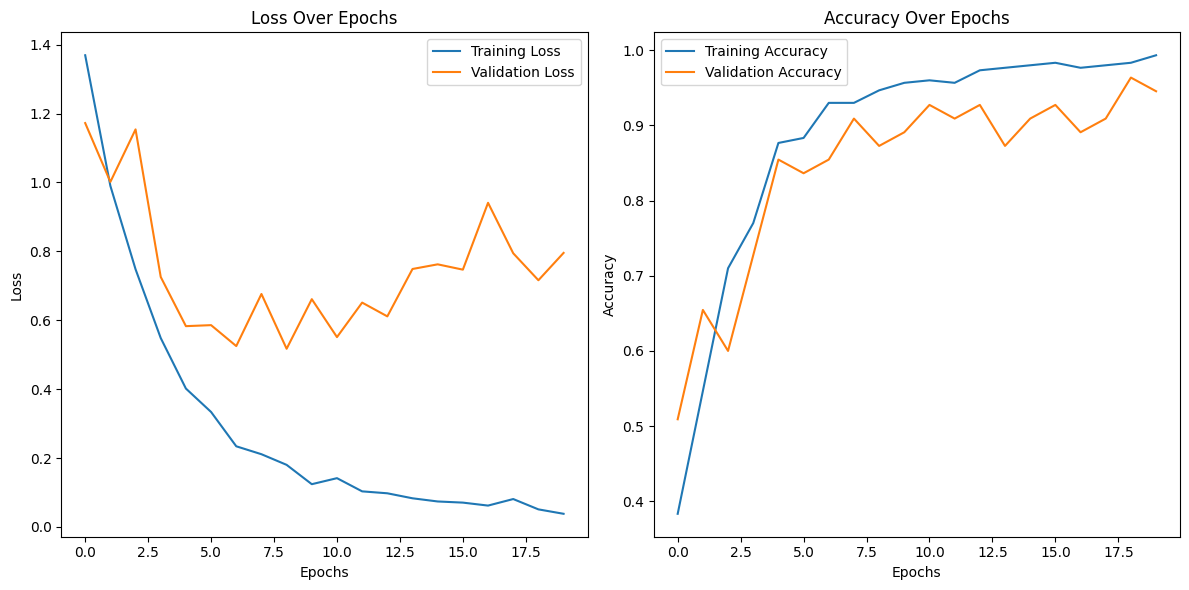

In [70]:
# Model 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = CNN().to(device)
model2.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc = train_model(model2, train_loader2, test_loader, criterion, optimizer, epochs=num_epochs)

plot_training_progress(train_loss, val_loss, train_acc, val_acc)

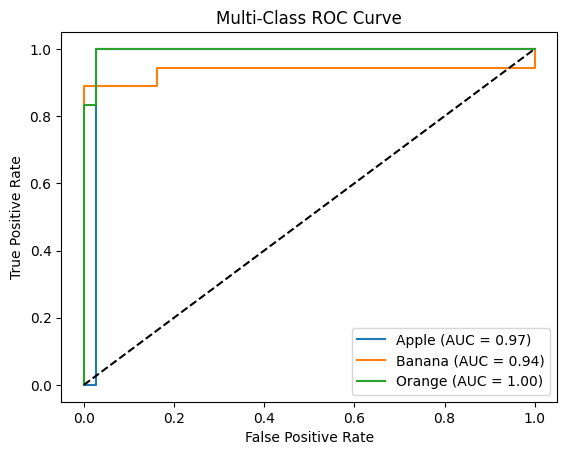

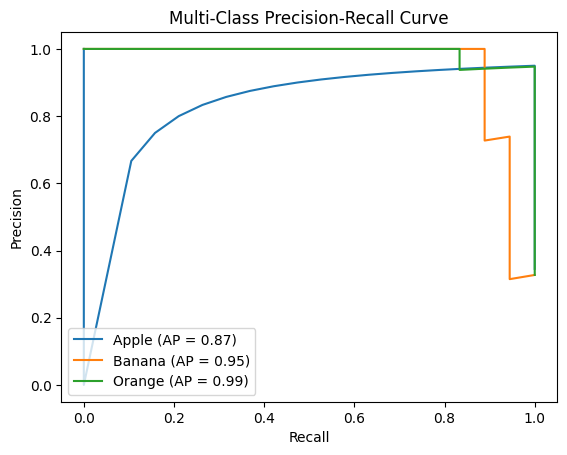

In [73]:
class_names = ["Apple", "Banana", "Orange"]

y_true, y_scores = evaluate_model(model2, test_loader, num_classes=len(class_names))

plot_multi_class_roc(y_true, y_scores, num_classes=len(class_names), class_names=class_names)
plot_multi_class_precision_recall(y_true, y_scores, num_classes=len(class_names), class_names=class_names)


In [76]:
# Tuning

# Hyperparameter Tuning:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)
print("Best validation accuracy:", study.best_value)

[I 2024-12-02 01:11:03,205] A new study created in memory with name: no-name-c134ba78-802e-4c6c-867d-3c4f623a0ff1
C:\Users\0dps1\AppData\Local\Temp\ipykernel_3172\2844616042.py:294: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\0dps1\AppData\Local\Temp\ipykernel_3172\2844616042.py:296: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.7)
[I 2024-12-02 01:11:30,043] Trial 0 finished with value: 0.38333333333333336 and parameters: {'lr': 0.0001369516818487132, 'optimizer': 'SGD', 'dropout_rate': 0.5654242655325672, 'batch_size': 128}. Best is trial 0 with value: 0.383

Best hyperparameters: {'lr': 0.0011054159099940831, 'optimizer': 'RMSprop', 'dropout_rate': 0.3384760735085539, 'batch_size': 16}
Best validation accuracy: 0.9666666666666667


In [ ]:
# # Evaluate the model
# metrics = evaluate_model(model2, test_loader, num_classes=3)
# print("Evaluation Metrics:")
# for metric, value in metrics.items():
#     print(f"{metric}: {value:.4f}")

Evaluation Metrics:


AttributeError: 'tuple' object has no attribute 'items'

Epoch 1/10, Train Loss: 1.1189, Val Loss: 1.1268, Train Acc: 0.3200, Val Acc: 0.3455
Epoch 2/10, Train Loss: 1.0362, Val Loss: 1.1582, Train Acc: 0.5333, Val Acc: 0.4909
Epoch 3/10, Train Loss: 0.9362, Val Loss: 1.1236, Train Acc: 0.6400, Val Acc: 0.5455
Epoch 4/10, Train Loss: 0.7686, Val Loss: 1.2258, Train Acc: 0.7100, Val Acc: 0.6182
Epoch 5/10, Train Loss: 0.6491, Val Loss: 1.2627, Train Acc: 0.7233, Val Acc: 0.4909
Epoch 6/10, Train Loss: 0.6268, Val Loss: 0.9782, Train Acc: 0.7000, Val Acc: 0.5091
Epoch 7/10, Train Loss: 0.5156, Val Loss: 0.9971, Train Acc: 0.7900, Val Acc: 0.6909
Epoch 8/10, Train Loss: 0.3965, Val Loss: 0.7596, Train Acc: 0.9133, Val Acc: 0.7273
Epoch 9/10, Train Loss: 0.3242, Val Loss: 0.7044, Train Acc: 0.8867, Val Acc: 0.7273
Epoch 10/10, Train Loss: 0.2671, Val Loss: 0.6755, Train Acc: 0.9233, Val Acc: 0.7636


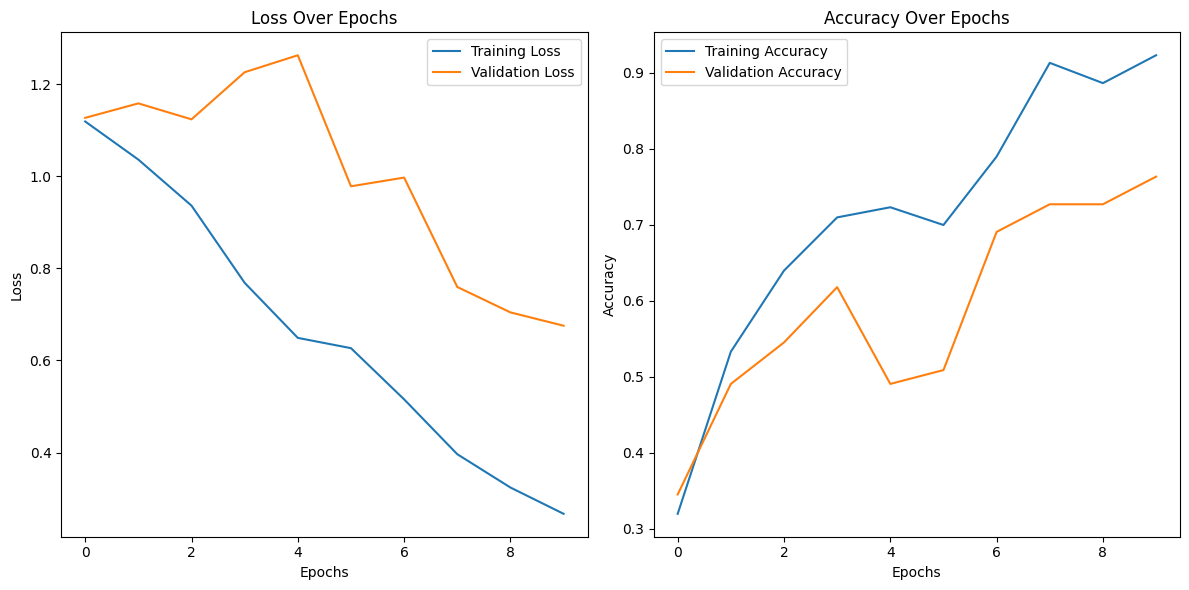

In [78]:
# Post Hyperparameter Tuning

class CNN(nn.Module):
    def __init__(self, num_filters=32, dropout_rate=0.5, num_classes=3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(num_filters * 2 * 16 * 16, 128)  # Adjust to match your input size
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(epoch_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        correct, total, epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(epoch_loss / len(val_loader))
        val_acc.append(correct / total)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc



best_params = {'learning_rate': 0.00034200457690912835, 'optimizer': 'Adam', 'dropout_rate': 0.31722634344248496, 'batch_size': 64, 'num_filters':32, 'epochs':10}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(dropout_rate=best_params['dropout_rate'], num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader2, test_loader, criterion, optimizer, device, epochs=best_params['epochs']
)

#torch.save(model.state_dict(), "best_cnn_model.pth")

plot_training_progress(train_loss, val_loss, train_acc, val_acc)


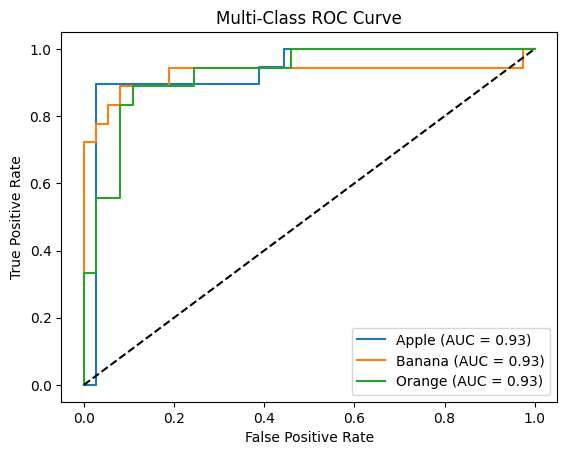

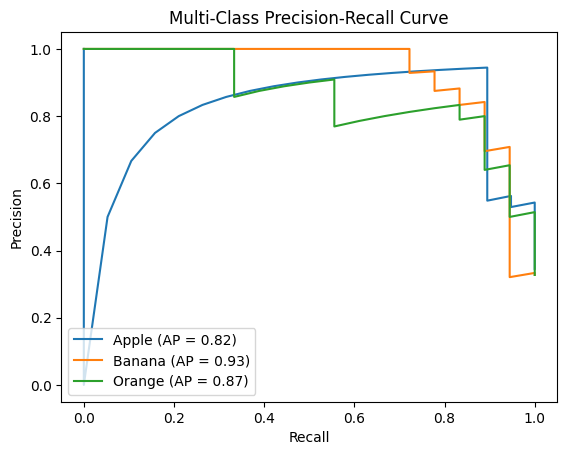

In [79]:
class_names = ["Apple", "Banana", "Orange"]

y_true, y_scores = evaluate_model(model, test_loader, num_classes=len(class_names))

plot_multi_class_roc(y_true, y_scores, num_classes=len(class_names), class_names=class_names)
plot_multi_class_precision_recall(y_true, y_scores, num_classes=len(class_names), class_names=class_names)

In [80]:
# Datasets: Synthetic Images 50% Original 50%

syn_img_path = 'Datasets\\DiegoP-S\\DatasetSynthesis'
original_img_path = 'Datasets\\mbkinaci\\fruit-images-for-object-detection\\train'

synthetic_dataset = CustomImageFolder(root=syn_img_path, transform=transform, allowed_classes=['Apple', 'Banana', 'Orange'])
original_dataset = datasets.ImageFolder(root=original_img_path, transform=transform)

def get_class_indices(dataset):
    """Return a dictionary with class indices grouped by category."""
    class_indices = {class_name: [] for class_name in dataset.classes}
    for idx, (_, label) in enumerate(dataset.samples):
        class_name = dataset.classes[label]
        class_indices[class_name].append(idx)
    return class_indices

synthetic_indices = get_class_indices(synthetic_dataset)
original_indices = get_class_indices(original_dataset)

def sample_indices(synthetic_indices, original_indices, syn_ratio=0.5, orig_ratio=0.5):
    combined_indices = []
    for category in synthetic_indices.keys():
        syn_count = int(len(synthetic_indices[category]) * syn_ratio)
        orig_count = int(len(original_indices[category]) * orig_ratio)

        syn_sample = random.sample(synthetic_indices[category], min(syn_count, len(synthetic_indices[category])))
        orig_sample = random.sample(original_indices[category], min(orig_count, len(original_indices[category])))

        combined_indices.extend(syn_sample + orig_sample)

    return combined_indices

combined_indices = sample_indices(synthetic_indices, original_indices)


combined_dataset = Subset(synthetic_dataset + original_dataset, combined_indices)
train_loader3 = DataLoader(combined_dataset, batch_size=32, shuffle=True)



Epoch 1/20, Train Loss: 1.3656, Val Loss: 1.0908, Train Acc: 0.3050, Val Acc: 0.4000
Epoch 2/20, Train Loss: 1.0309, Val Loss: 1.1179, Train Acc: 0.5985, Val Acc: 0.6182
Epoch 3/20, Train Loss: 0.9289, Val Loss: 1.0208, Train Acc: 0.6100, Val Acc: 0.6000
Epoch 4/20, Train Loss: 0.7403, Val Loss: 1.1549, Train Acc: 0.6602, Val Acc: 0.6182
Epoch 5/20, Train Loss: 0.6628, Val Loss: 0.8749, Train Acc: 0.7297, Val Acc: 0.6727
Epoch 6/20, Train Loss: 0.6158, Val Loss: 1.2283, Train Acc: 0.7181, Val Acc: 0.6545
Epoch 7/20, Train Loss: 0.4665, Val Loss: 1.0598, Train Acc: 0.8571, Val Acc: 0.7091
Epoch 8/20, Train Loss: 0.2843, Val Loss: 1.0583, Train Acc: 0.9035, Val Acc: 0.6000
Epoch 9/20, Train Loss: 0.2221, Val Loss: 1.2908, Train Acc: 0.9459, Val Acc: 0.6909
Epoch 10/20, Train Loss: 0.2116, Val Loss: 1.3760, Train Acc: 0.9228, Val Acc: 0.6727
Epoch 11/20, Train Loss: 0.2796, Val Loss: 0.7701, Train Acc: 0.9151, Val Acc: 0.7818
Epoch 12/20, Train Loss: 0.2309, Val Loss: 0.8078, Train Acc: 0

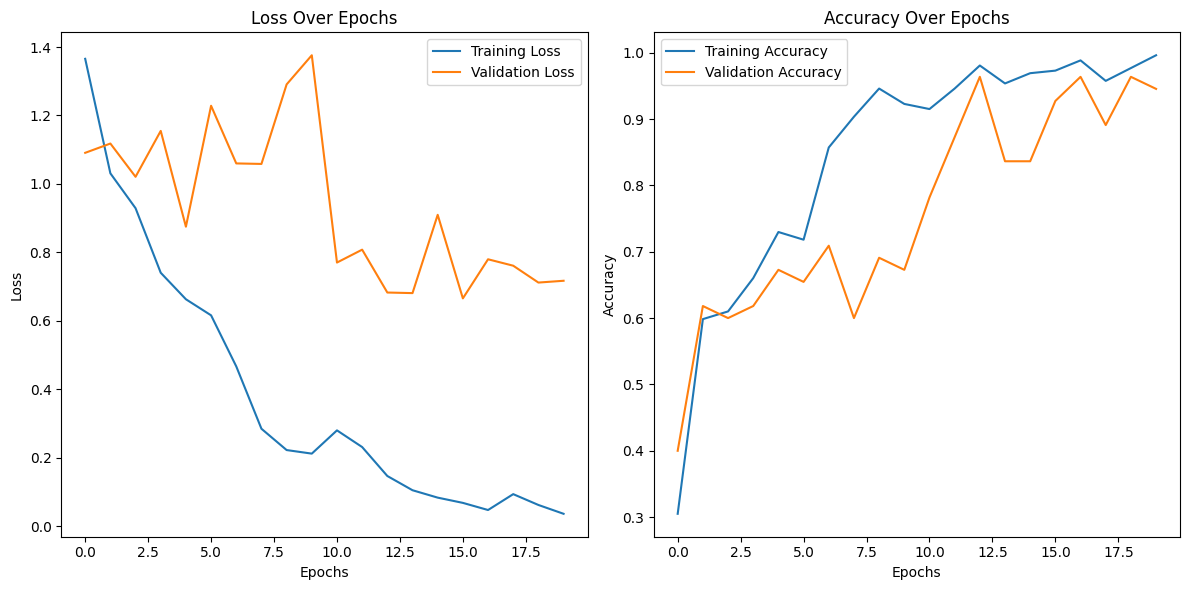

In [82]:
# Model 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = CNN().to(device)
model3.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc = train_model(model3, train_loader3, test_loader, criterion, optimizer, epochs=num_epochs, device=device)

plot_training_progress(train_loss, val_loss, train_acc, val_acc)

In [ ]:
# # Evaluate the model
# metrics = evaluate_model(model3, test_loader, num_classes=3)
# print("Evaluation Metrics:")
# for metric, value in metrics.items():
#     print(f"{metric}: {value:.4f}")


Evaluation Metrics:


AttributeError: 'tuple' object has no attribute 'items'

In [ ]:
# 70% Synthetic 30% Original

combined_indices = sample_indices(synthetic_indices, original_indices, syn_ratio=0.7, orig_ratio=0.3)

combined_dataset = Subset(synthetic_dataset + original_dataset, combined_indices)
train_loader4 = DataLoader(combined_dataset, batch_size=32, shuffle=True)

Epoch 1/20, Train Loss: 1.2740, Val Loss: 1.8645, Train Acc: 0.4197, Val Acc: 0.3636
Epoch 2/20, Train Loss: 0.6677, Val Loss: 3.7198, Train Acc: 0.7993, Val Acc: 0.4182
Epoch 3/20, Train Loss: 0.3084, Val Loss: 5.1724, Train Acc: 0.8942, Val Acc: 0.4000
Epoch 4/20, Train Loss: 0.1621, Val Loss: 4.4885, Train Acc: 0.9380, Val Acc: 0.6727
Epoch 5/20, Train Loss: 0.0856, Val Loss: 1.6551, Train Acc: 0.9708, Val Acc: 0.6545
Epoch 6/20, Train Loss: 0.0880, Val Loss: 4.3872, Train Acc: 0.9745, Val Acc: 0.6545
Epoch 7/20, Train Loss: 0.0316, Val Loss: 2.2760, Train Acc: 0.9927, Val Acc: 0.6000
Epoch 8/20, Train Loss: 0.0291, Val Loss: 4.1028, Train Acc: 0.9927, Val Acc: 0.6000
Epoch 9/20, Train Loss: 0.0277, Val Loss: 6.1034, Train Acc: 0.9927, Val Acc: 0.6000
Epoch 10/20, Train Loss: 0.0231, Val Loss: 5.3820, Train Acc: 0.9927, Val Acc: 0.6545
Epoch 11/20, Train Loss: 0.0153, Val Loss: 4.4954, Train Acc: 1.0000, Val Acc: 0.6909
Epoch 12/20, Train Loss: 0.0162, Val Loss: 5.7383, Train Acc: 0

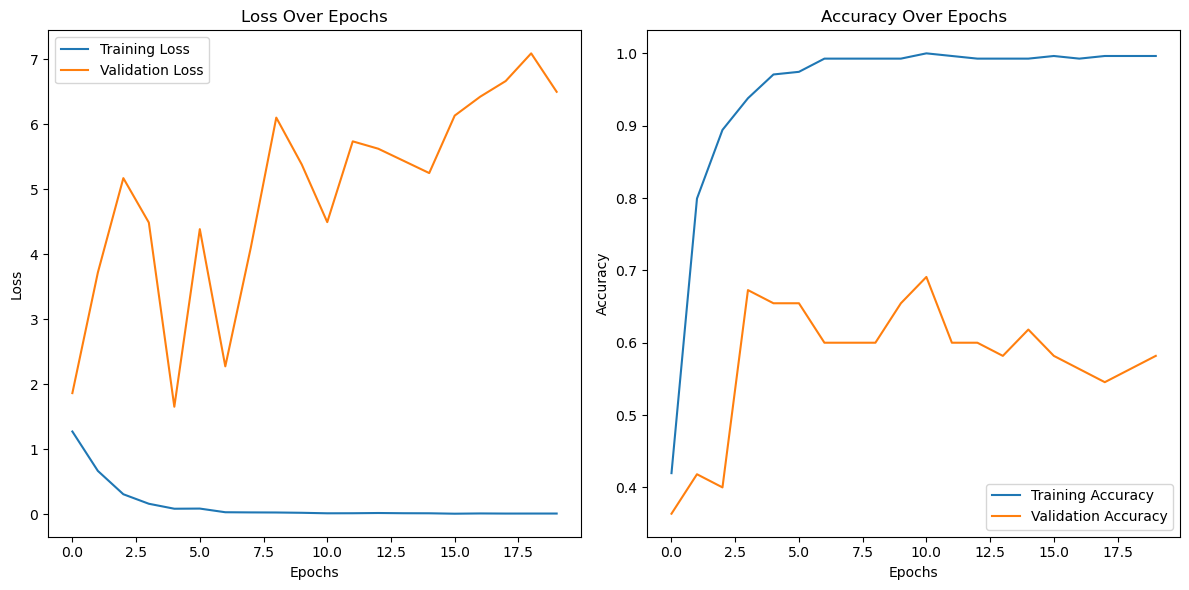

In [ ]:
# Model 4:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4 = CNN().to(device)
model4.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc = train_model(model4, train_loader4, test_loader, criterion, optimizer, epochs=num_epochs)

plot_training_progress(train_loss, val_loss, train_acc, val_acc)

In [ ]:
# # Evaluate the model
# metrics = evaluate_model(model4, test_loader, num_classes=3)
# print("Evaluation Metrics:")
# for metric, value in metrics.items():
#     print(f"{metric}: {value:.4f}")


Evaluation Metrics:
Accuracy: 0.7455
Precision: 0.8243
Recall: 0.7455
F1-score: 0.7044
ROC-AUC: 0.9161


100%|██████████| 1000/1000 [00:00<00:00, 2155.18it/s]


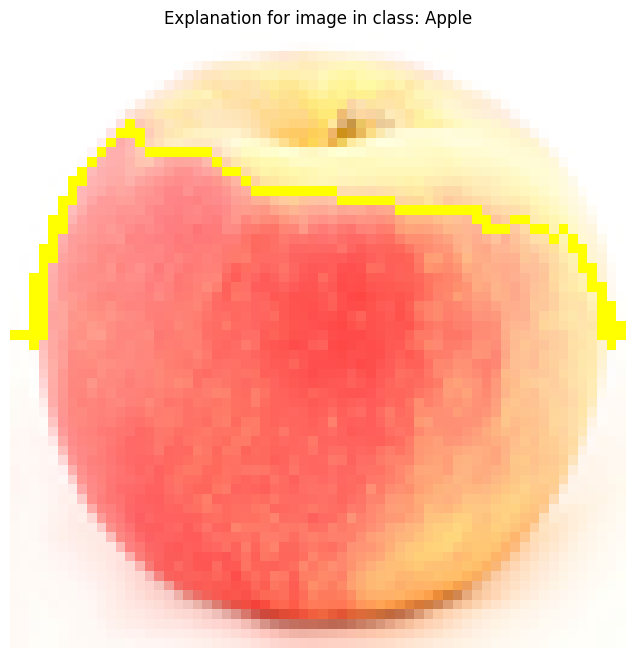

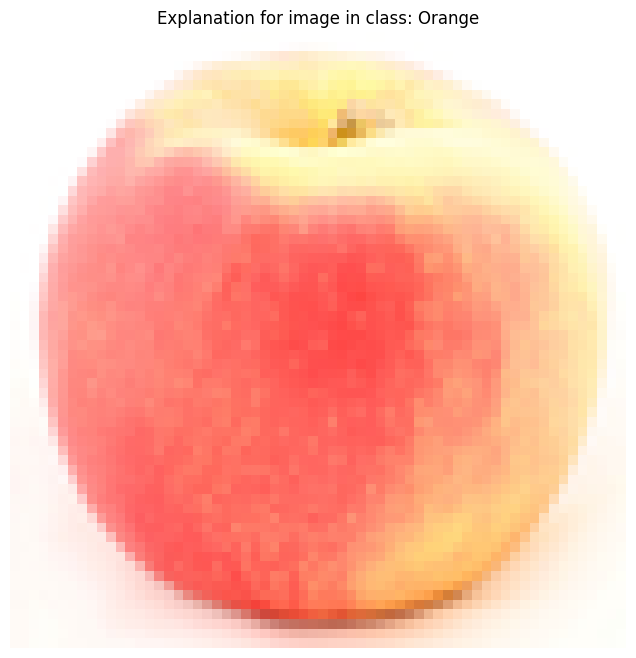

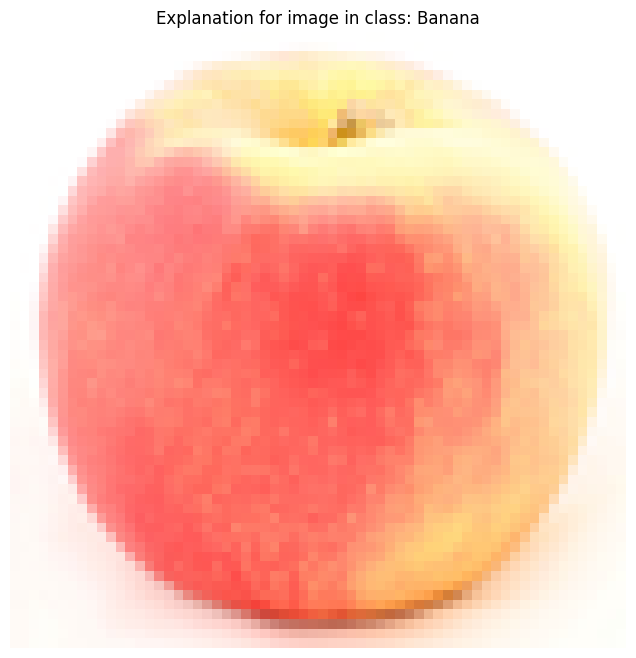

100%|██████████| 1000/1000 [00:00<00:00, 2173.91it/s]


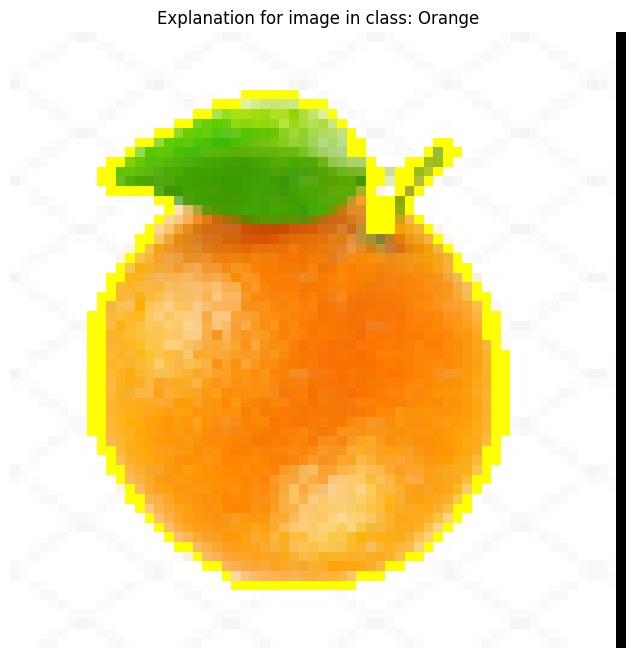

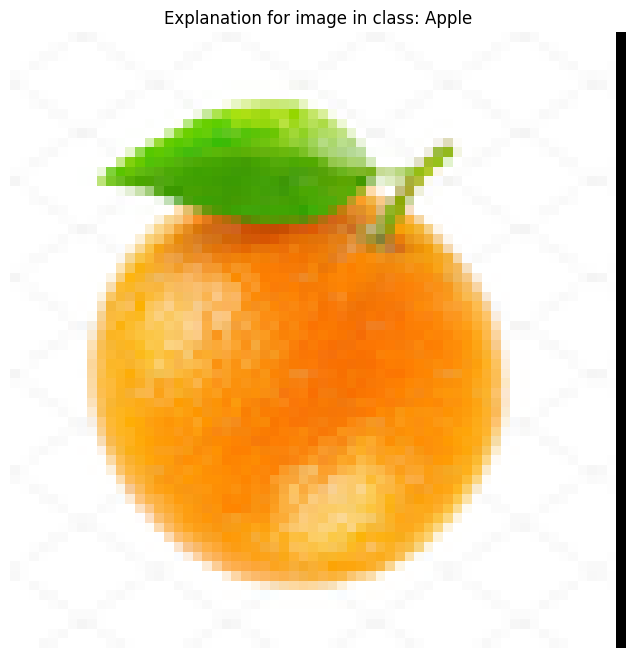

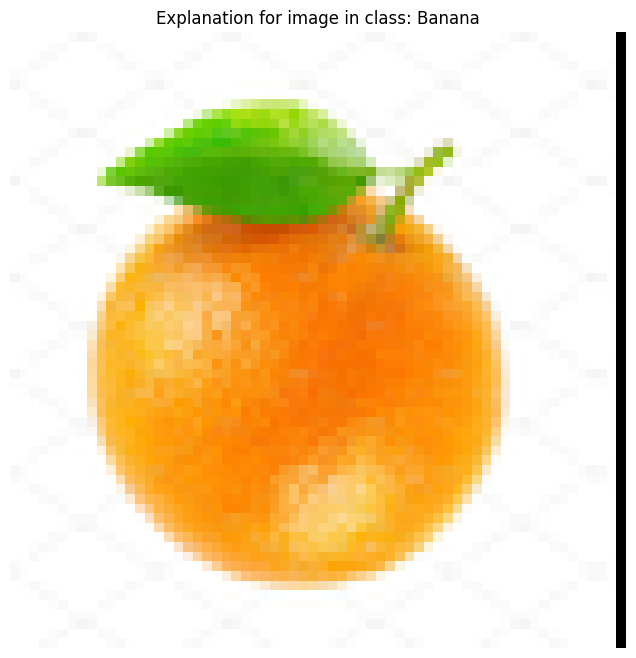

100%|██████████| 1000/1000 [00:00<00:00, 2192.98it/s]


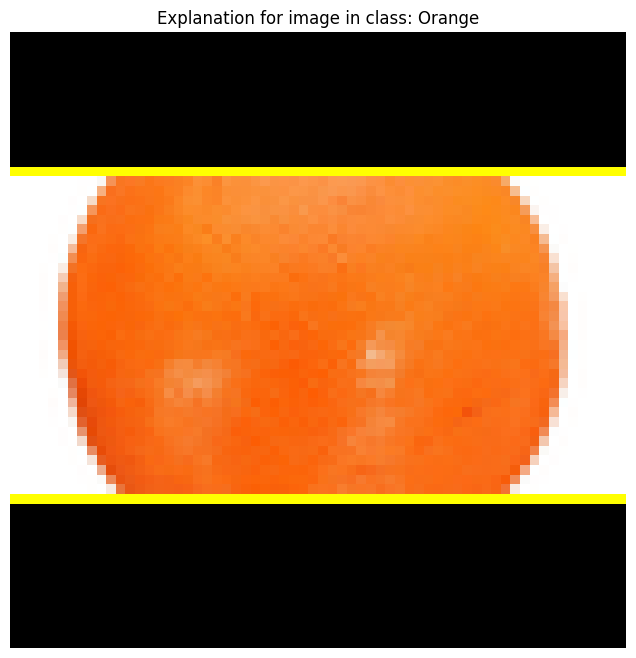

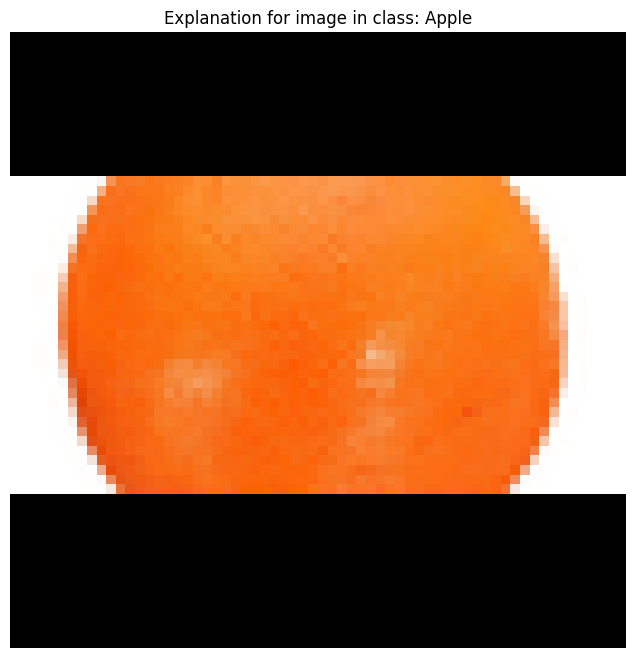

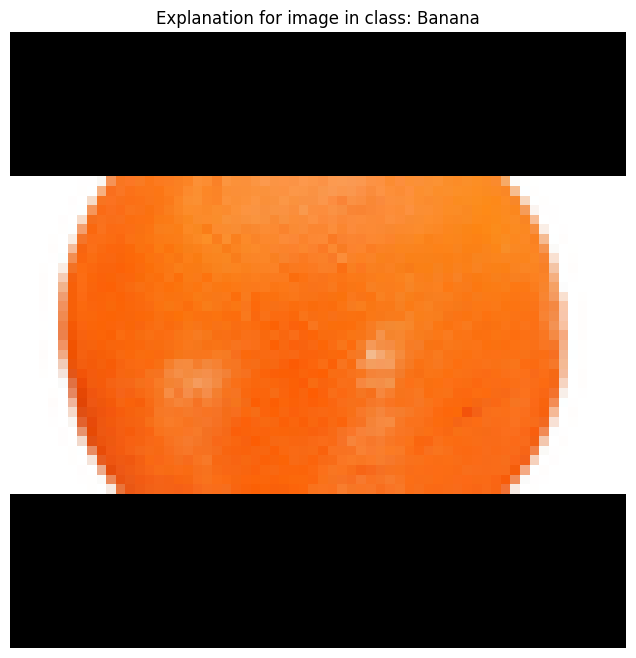

100%|██████████| 1000/1000 [00:00<00:00, 2141.33it/s]


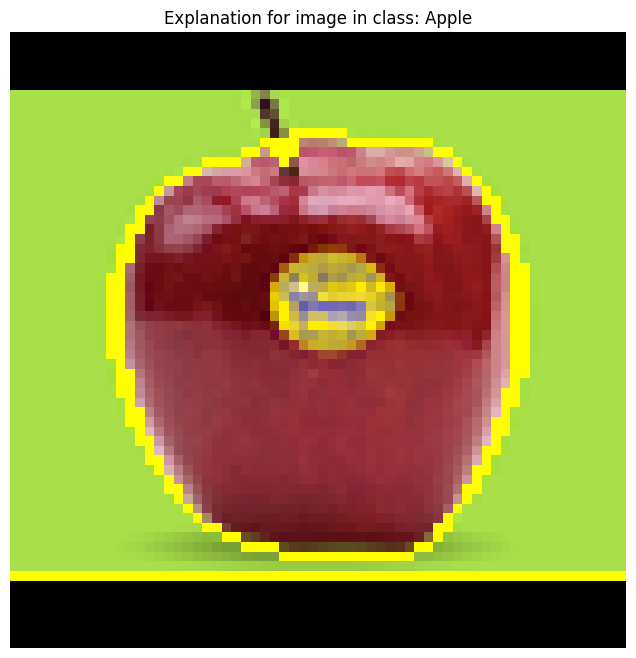

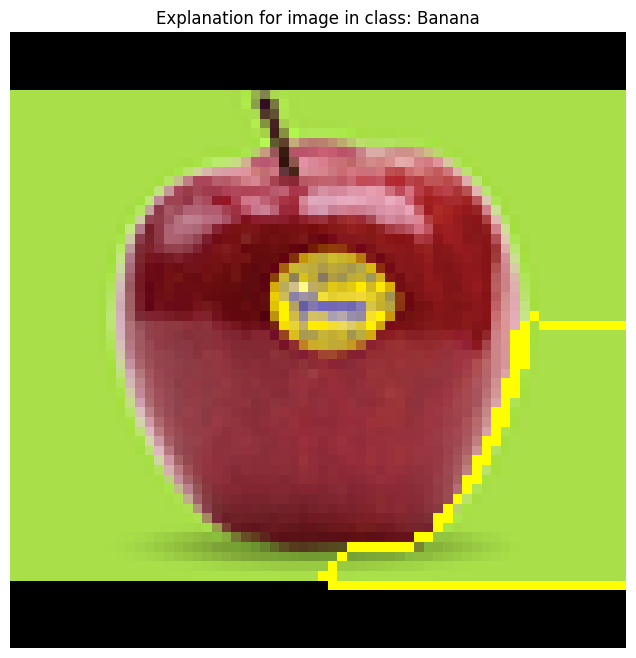

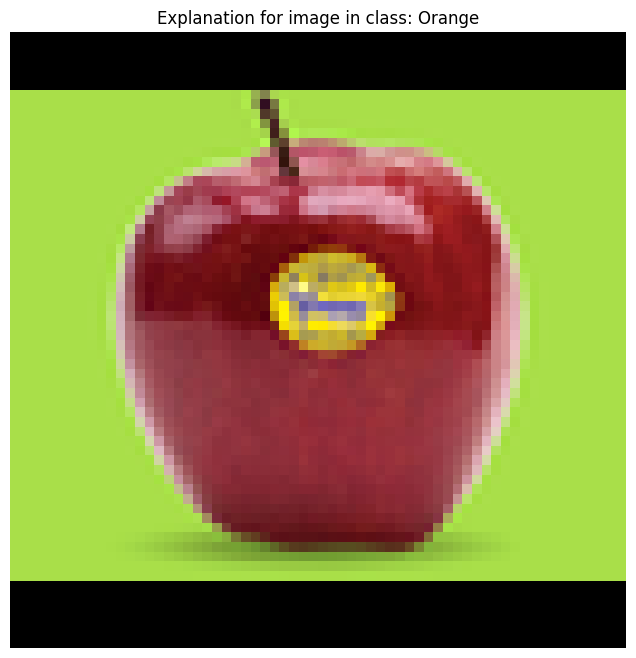

100%|██████████| 1000/1000 [00:00<00:00, 2100.84it/s]


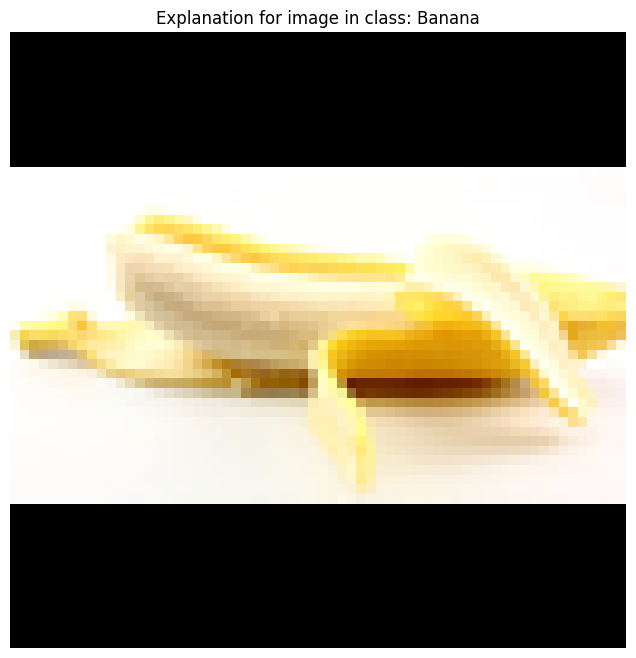

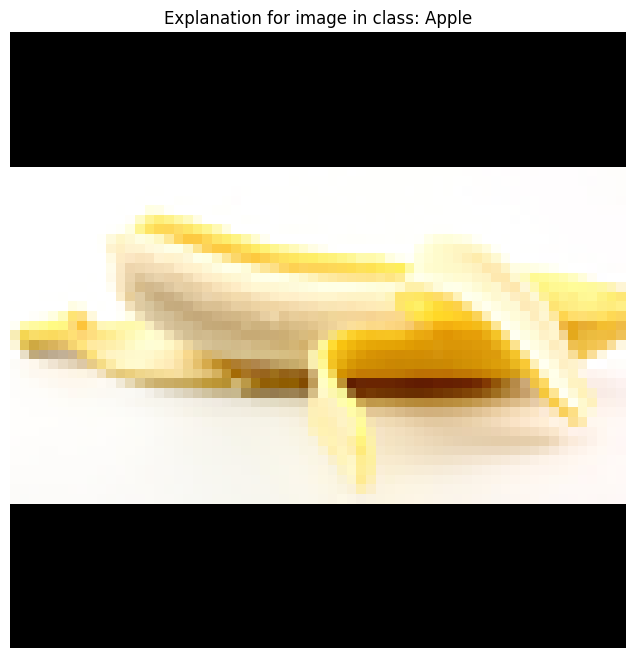

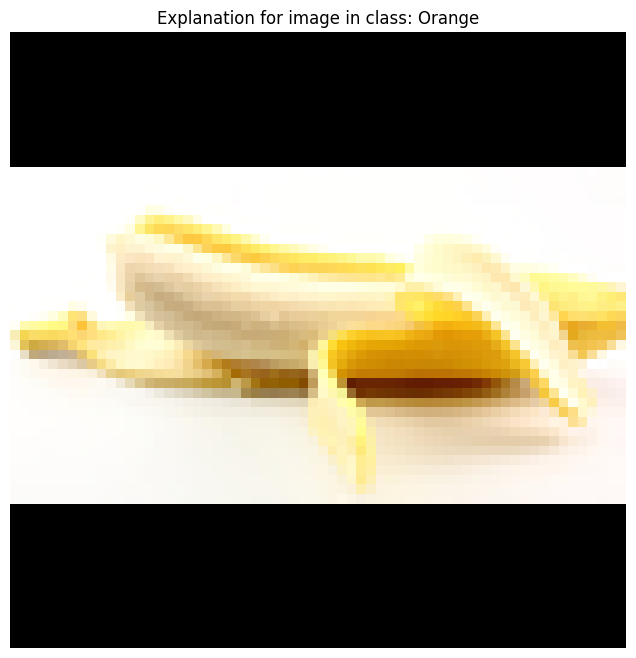

100%|██████████| 1000/1000 [00:00<00:00, 1718.22it/s]


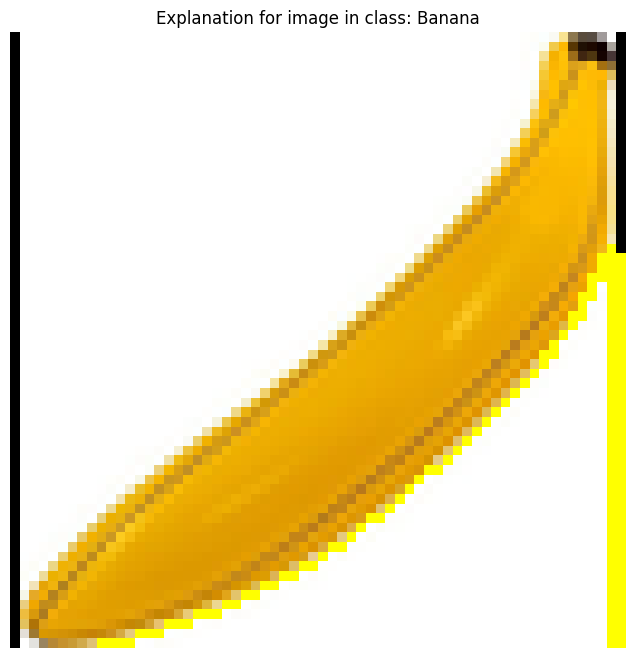

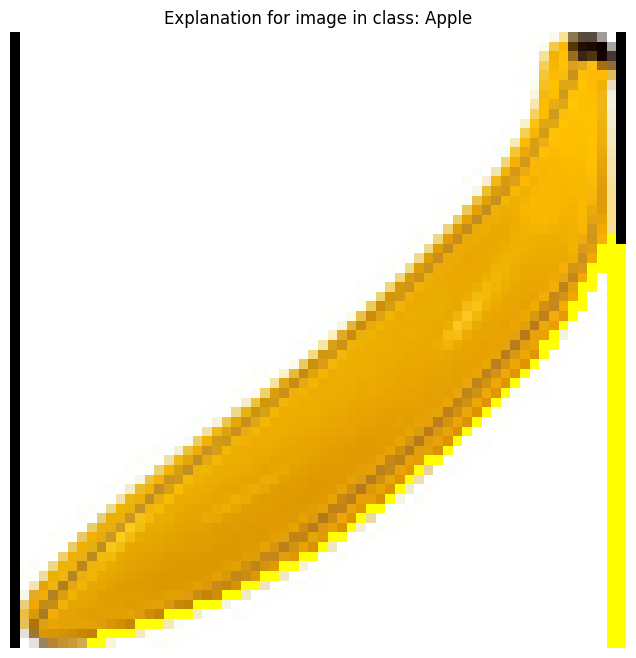

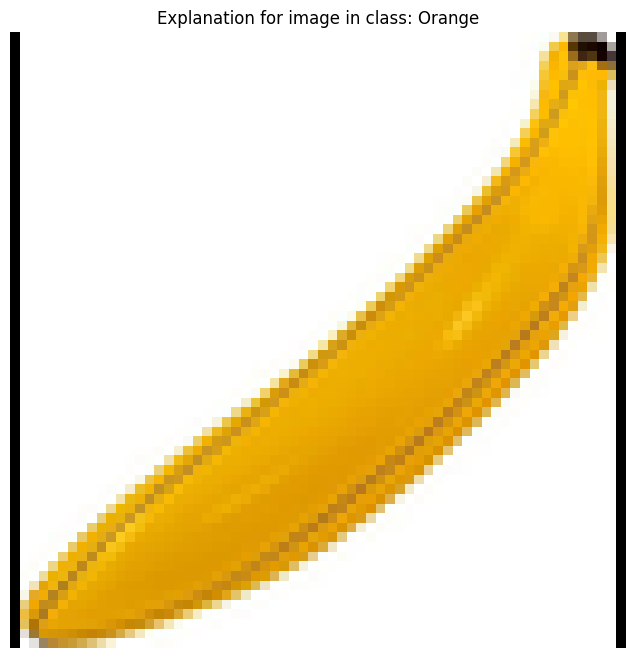

100%|██████████| 1000/1000 [00:00<00:00, 1644.74it/s]


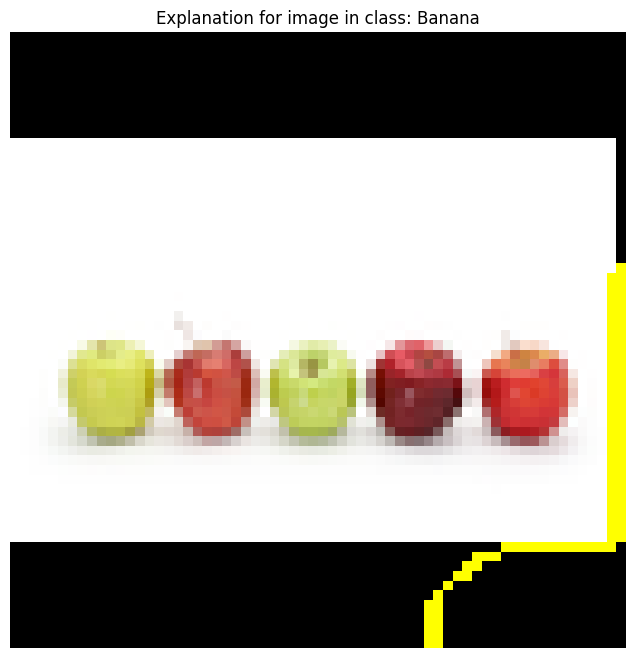

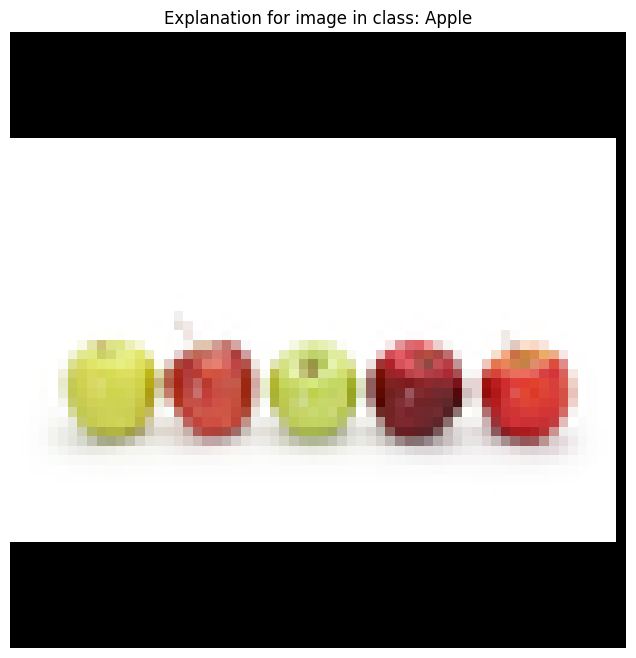

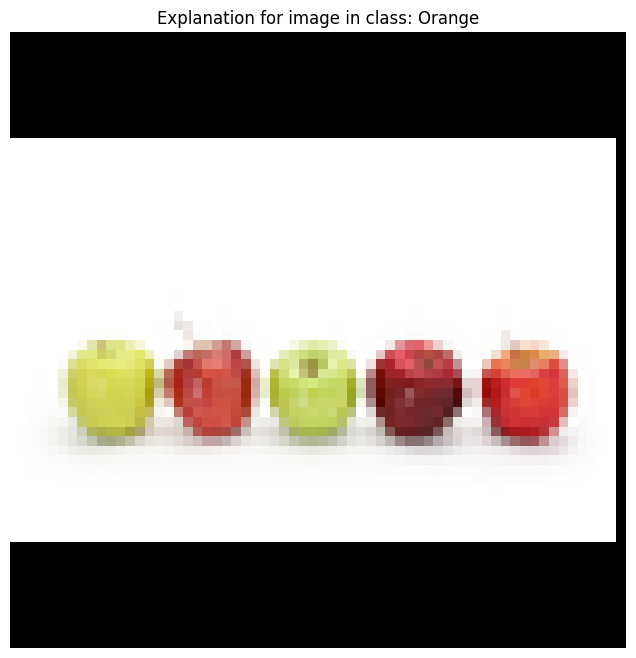

100%|██████████| 1000/1000 [00:00<00:00, 1567.39it/s]


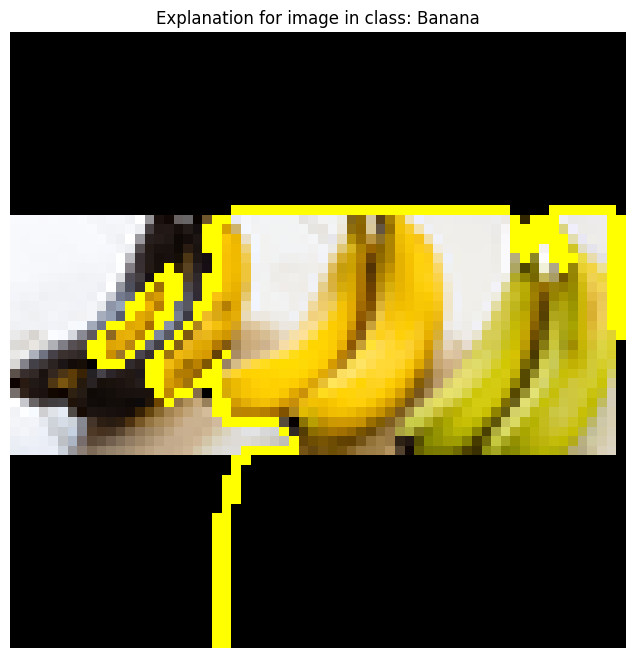

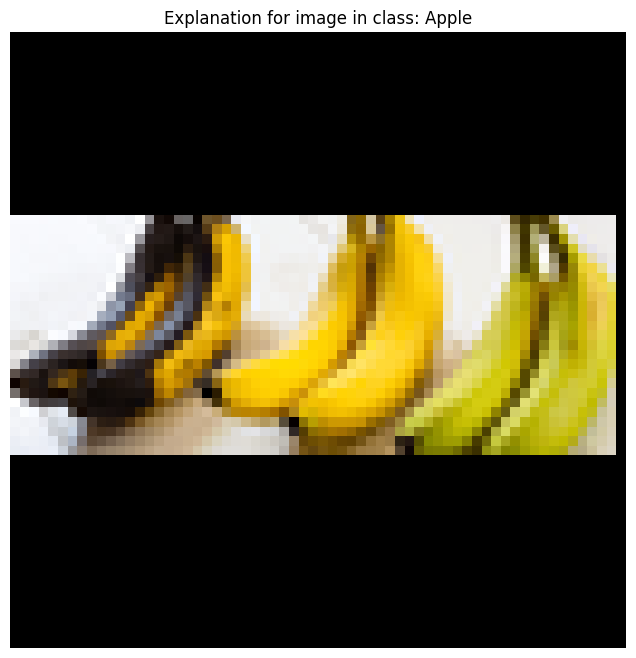

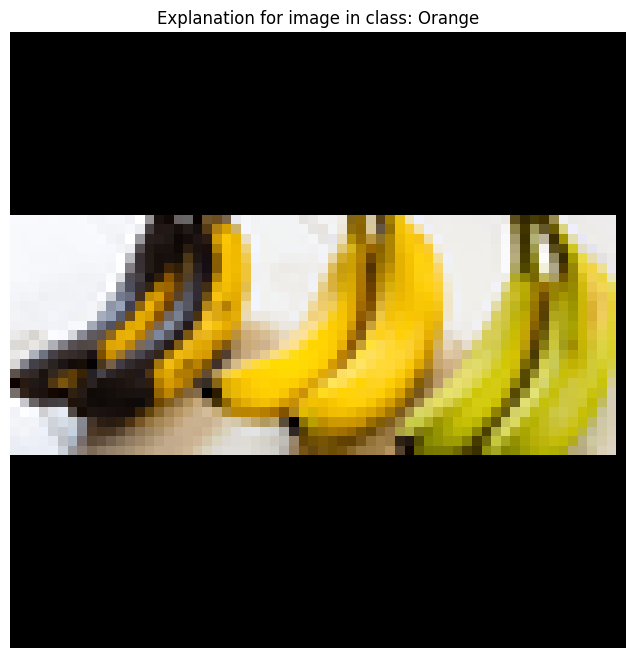

100%|██████████| 1000/1000 [00:00<00:00, 1104.97it/s]


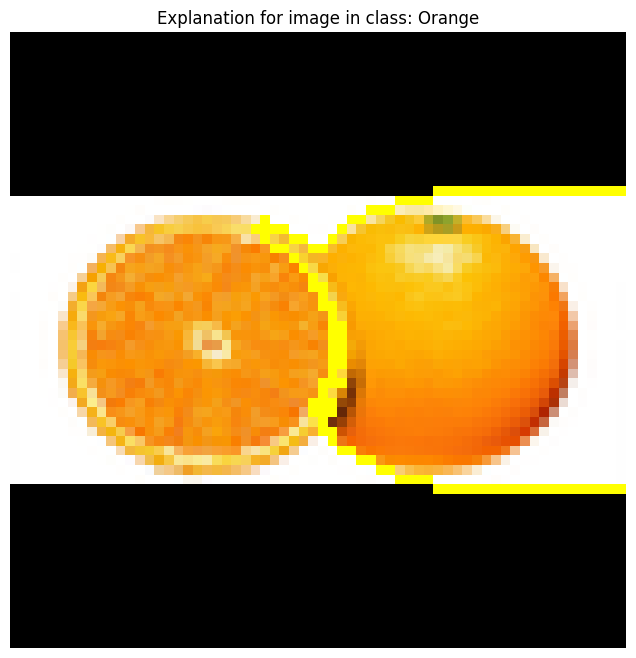

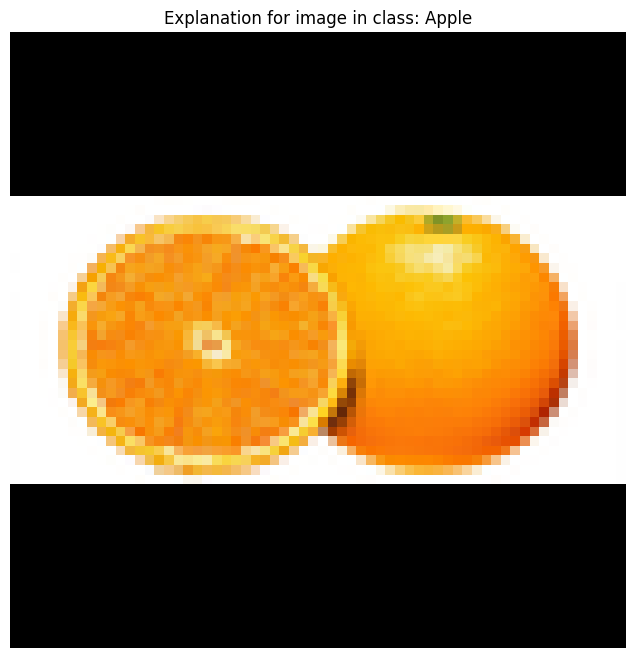

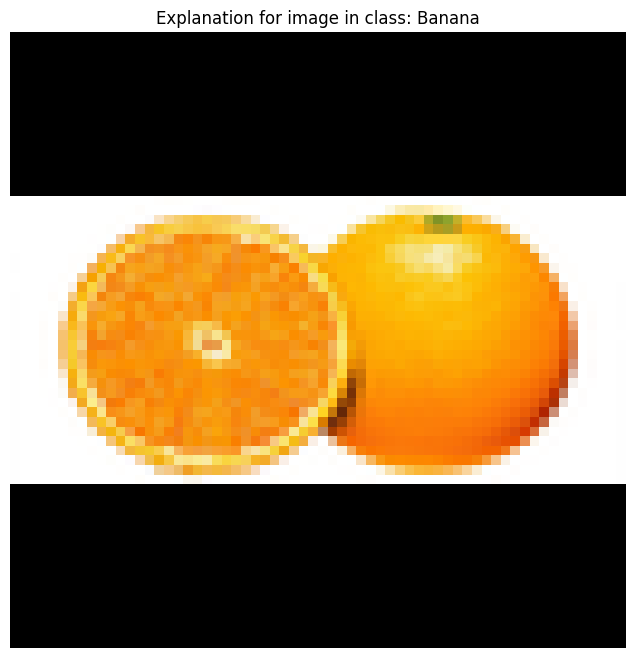

100%|██████████| 1000/1000 [00:00<00:00, 1434.72it/s]


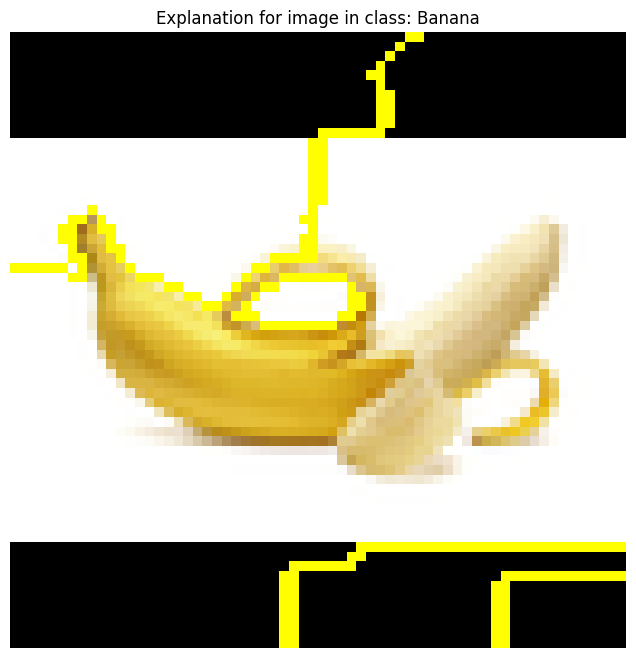

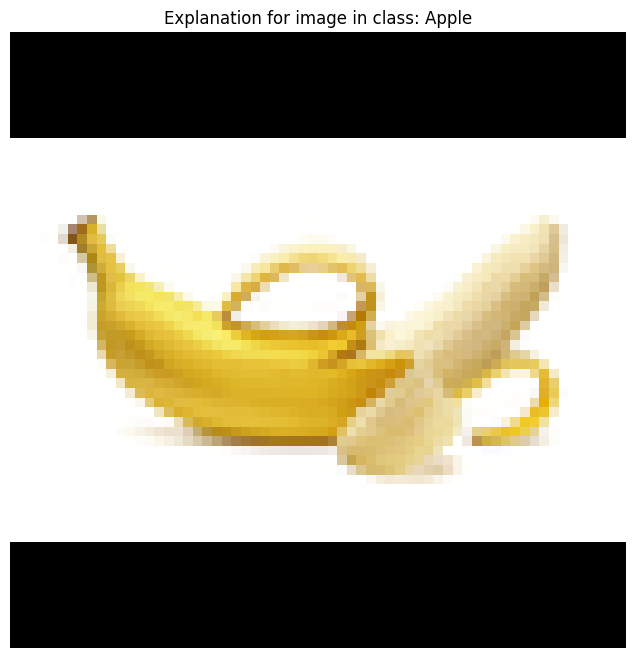

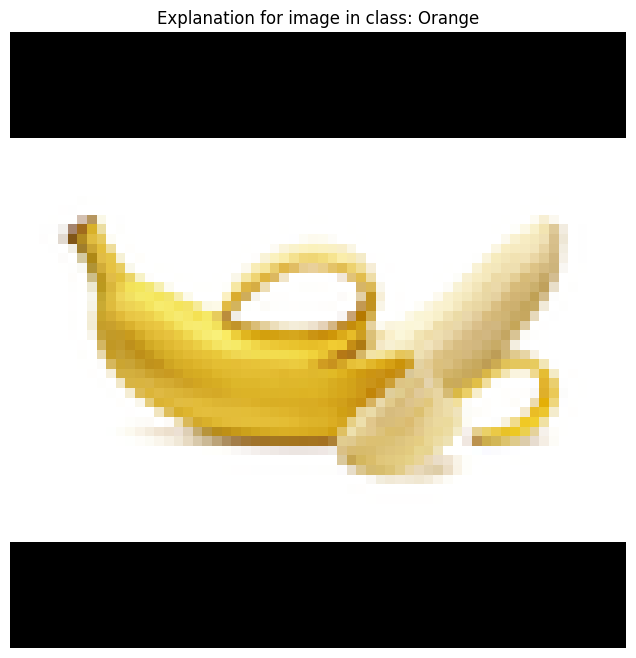

100%|██████████| 1000/1000 [00:00<00:00, 1672.24it/s]


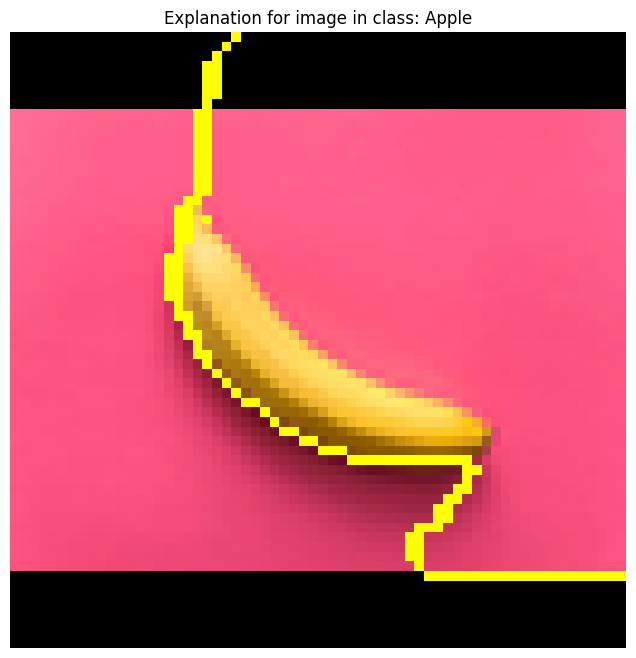

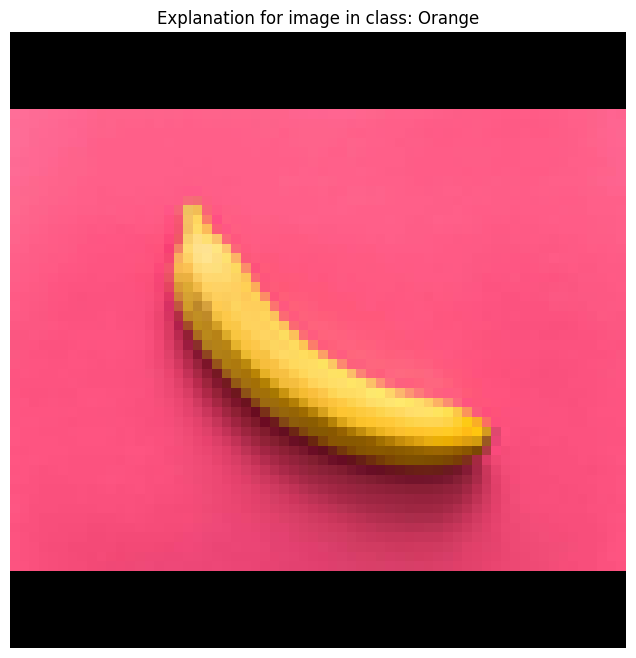

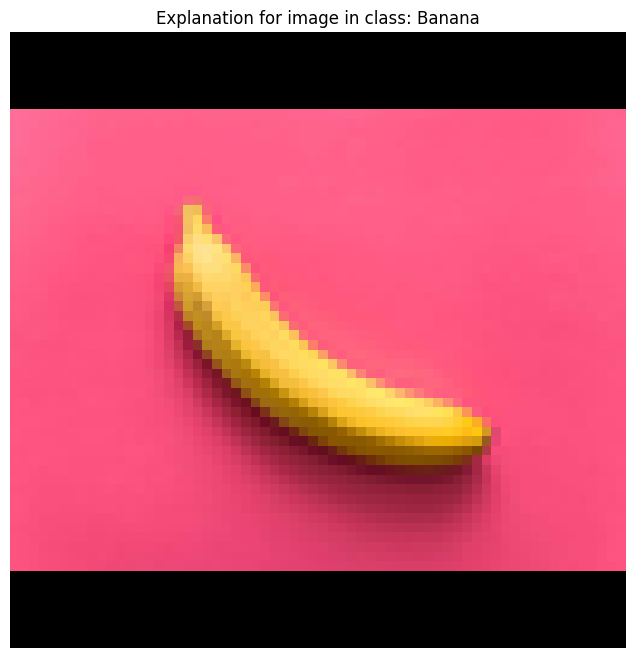

100%|██████████| 1000/1000 [00:00<00:00, 1577.30it/s]


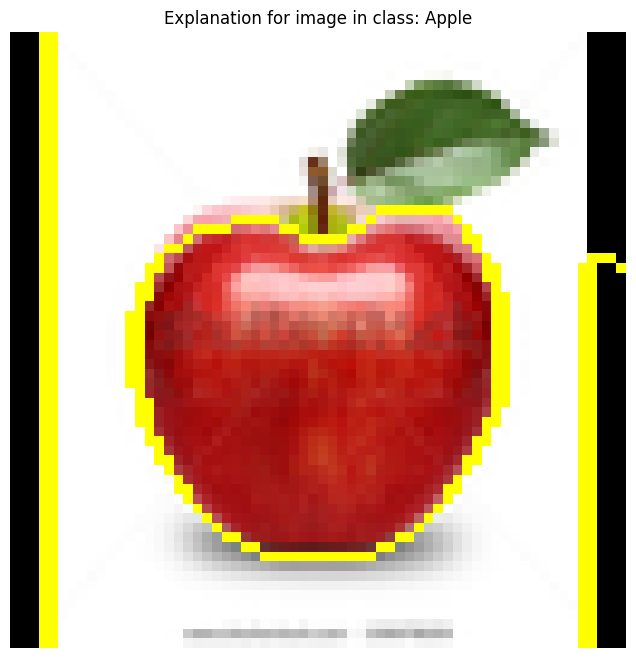

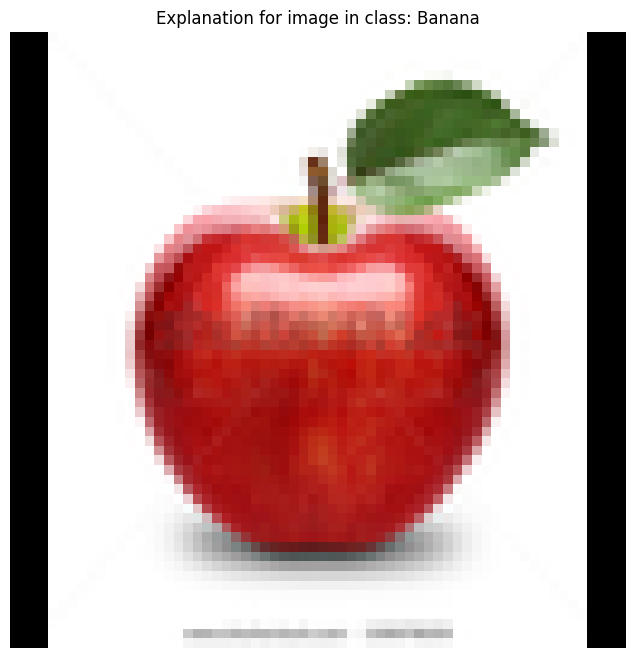

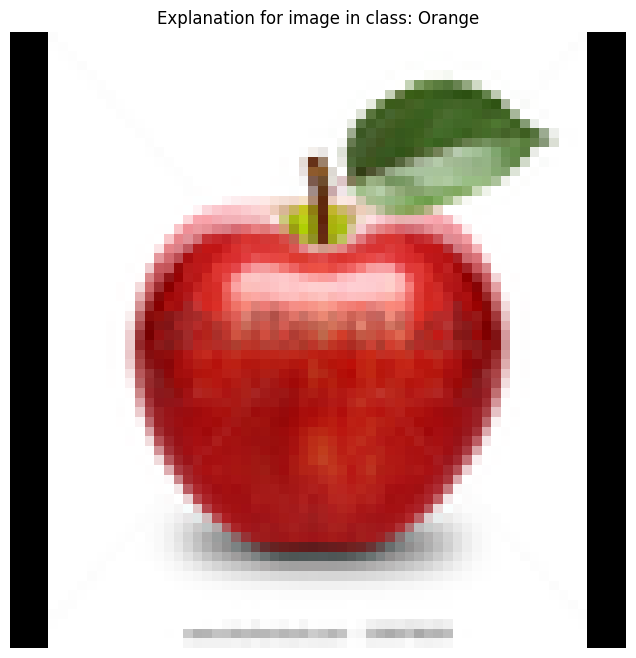

100%|██████████| 1000/1000 [00:00<00:00, 1610.32it/s]


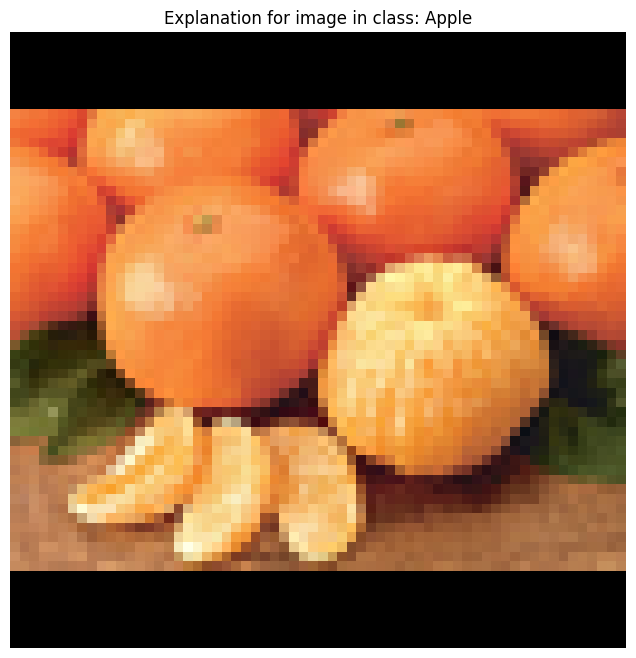

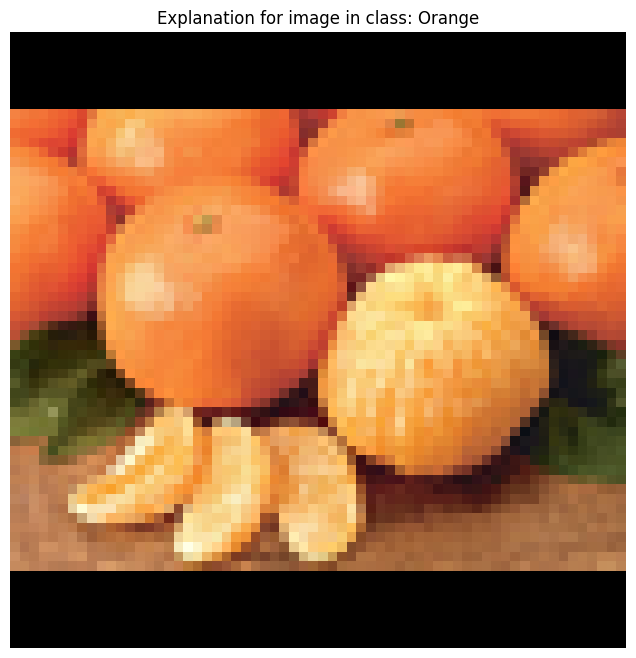

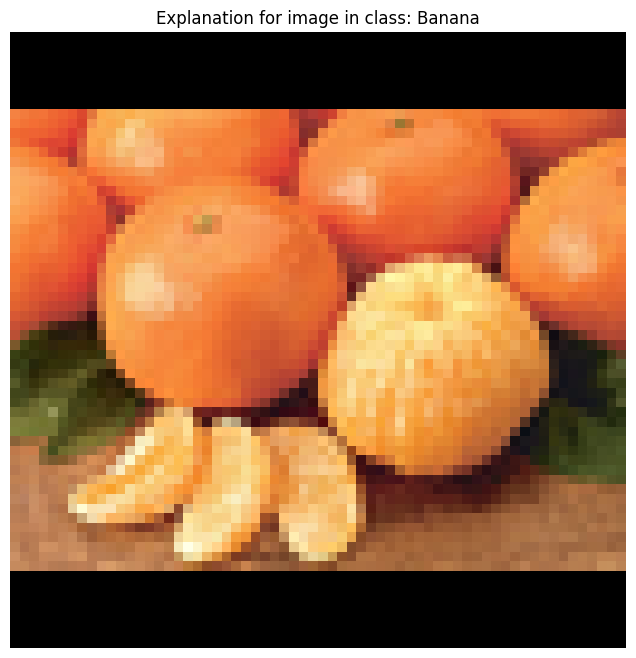

100%|██████████| 1000/1000 [00:00<00:00, 1618.12it/s]


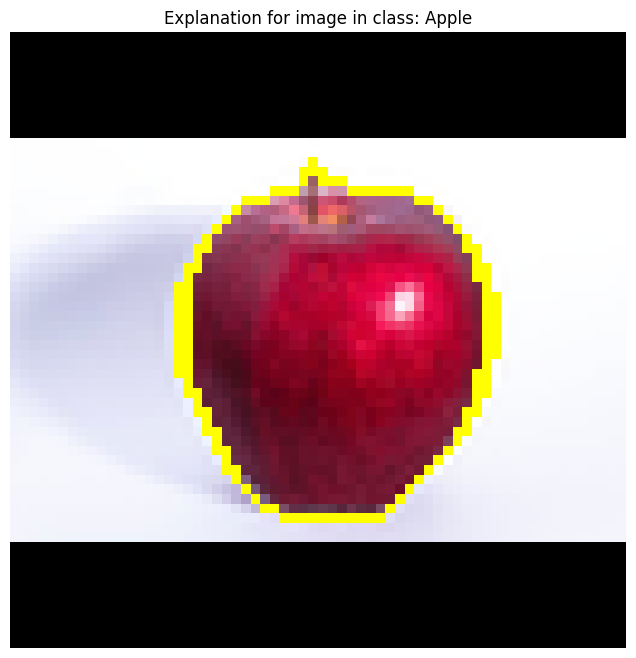

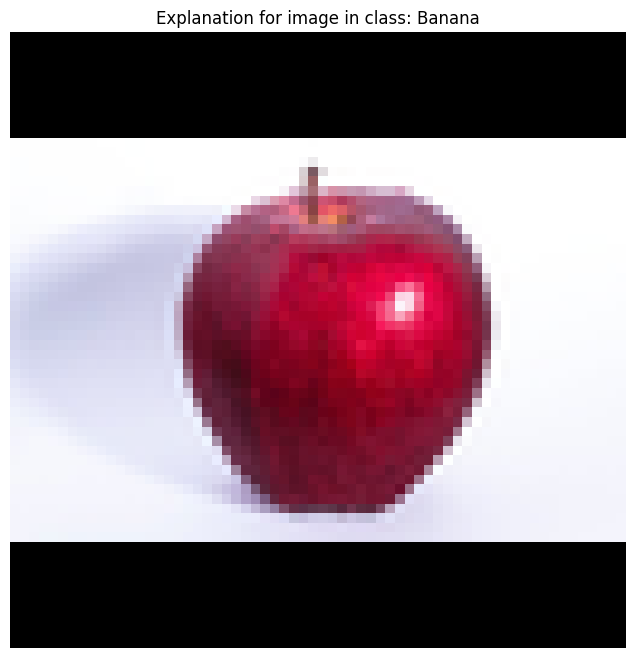

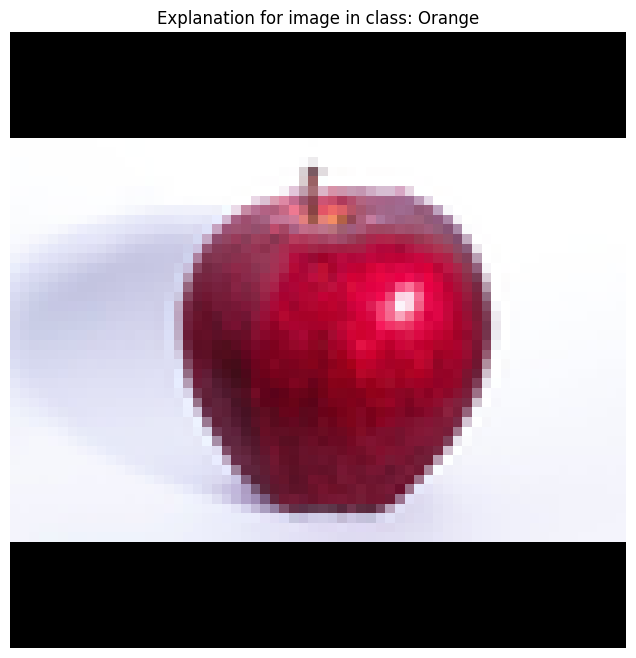

100%|██████████| 1000/1000 [00:00<00:00, 1745.20it/s]


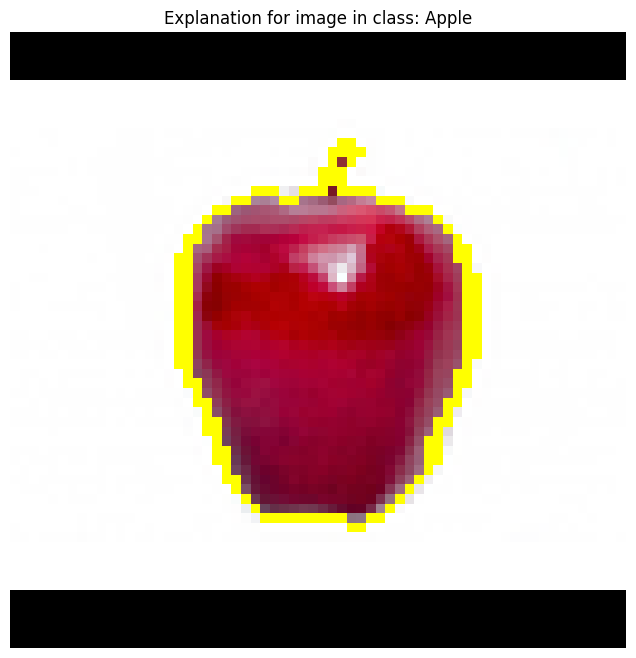

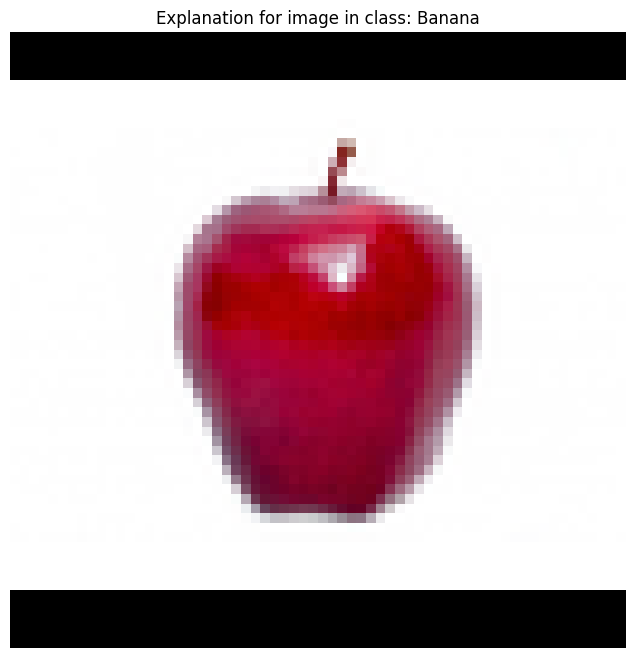

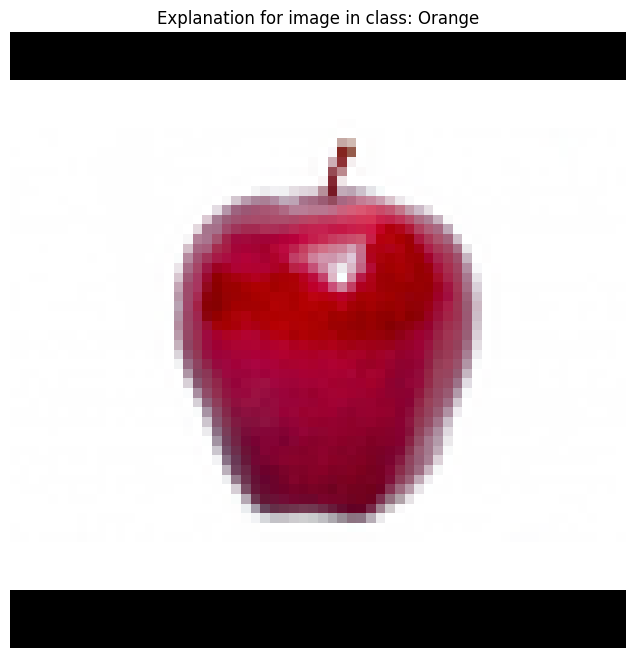

100%|██████████| 1000/1000 [00:00<00:00, 1501.50it/s]


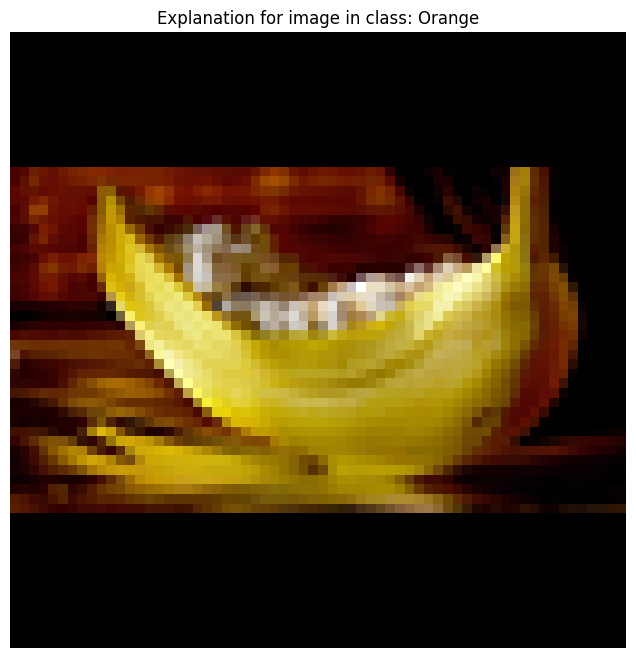

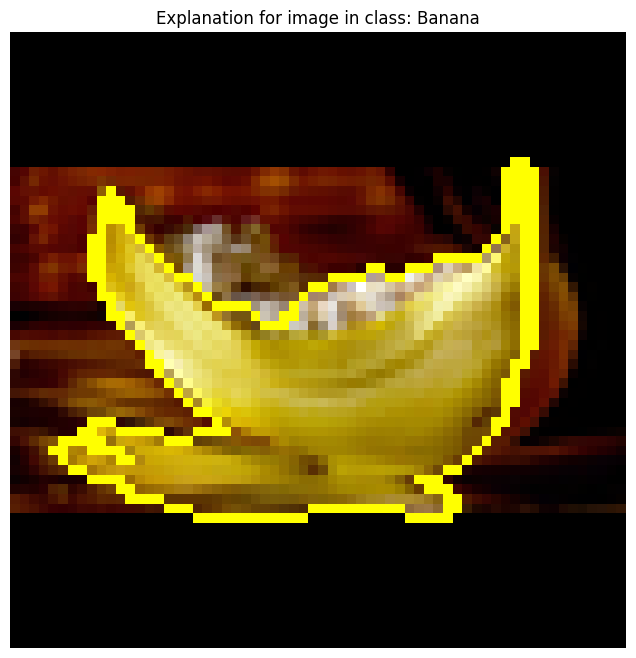

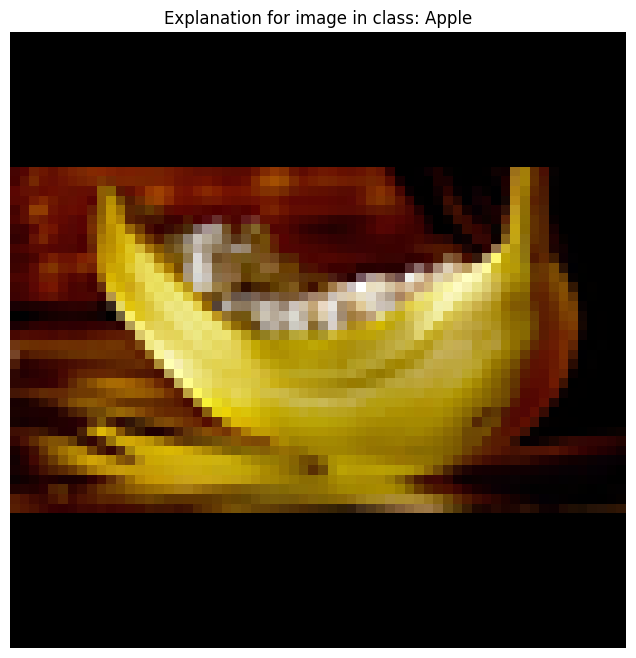

100%|██████████| 1000/1000 [00:00<00:00, 1724.14it/s]


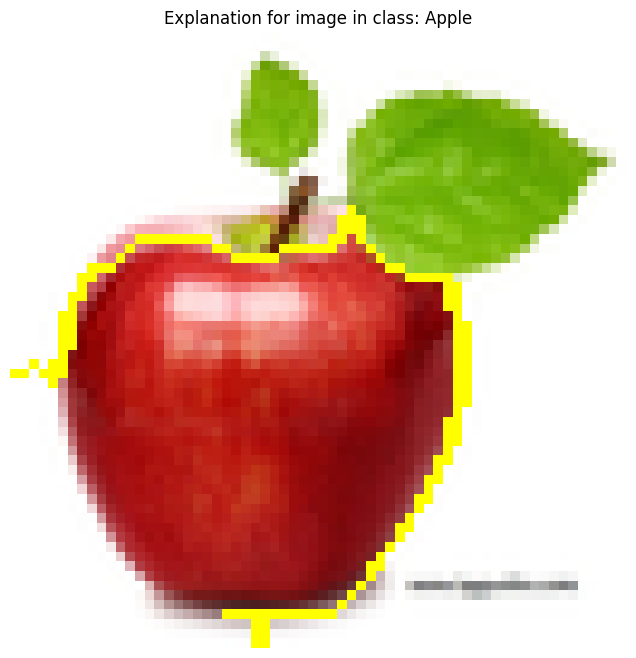

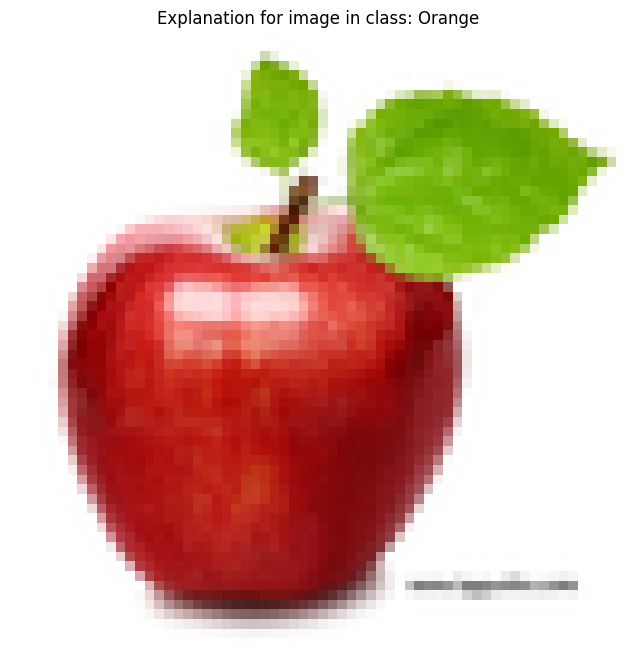

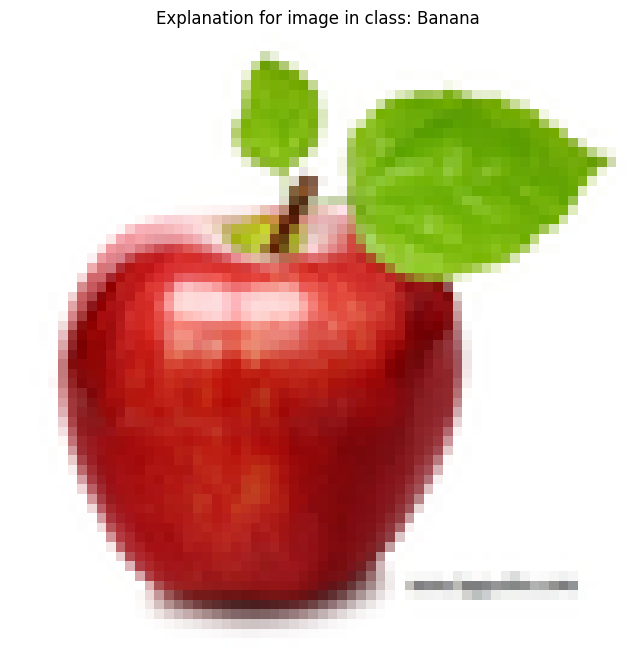

100%|██████████| 1000/1000 [00:00<00:00, 1639.36it/s]


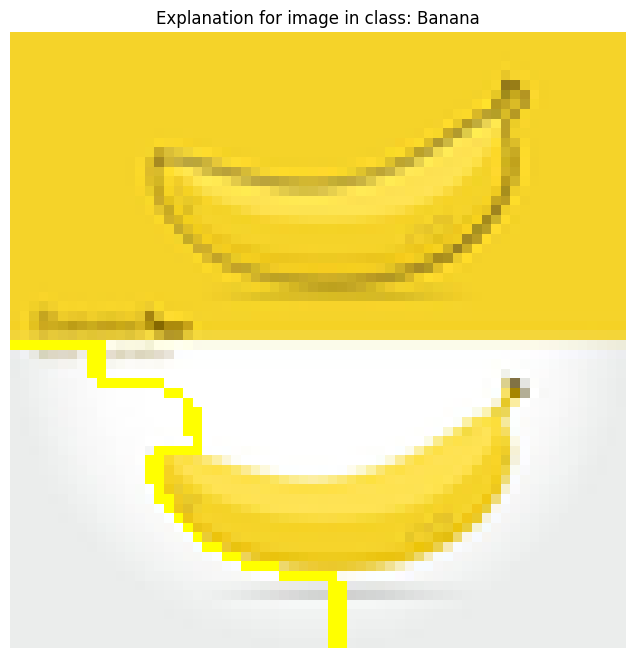

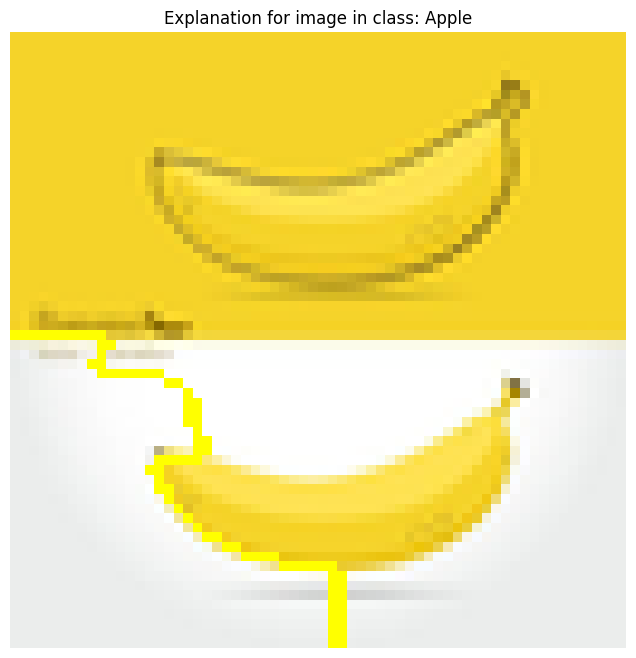

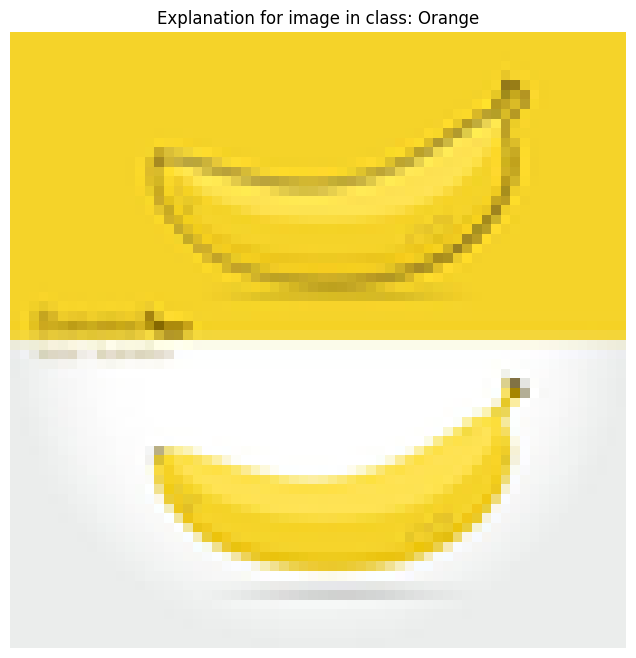

100%|██████████| 1000/1000 [00:00<00:00, 1675.04it/s]


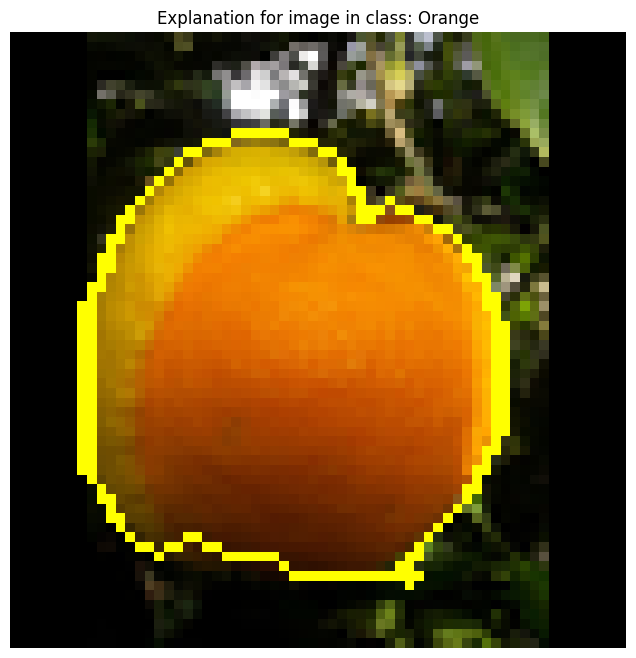

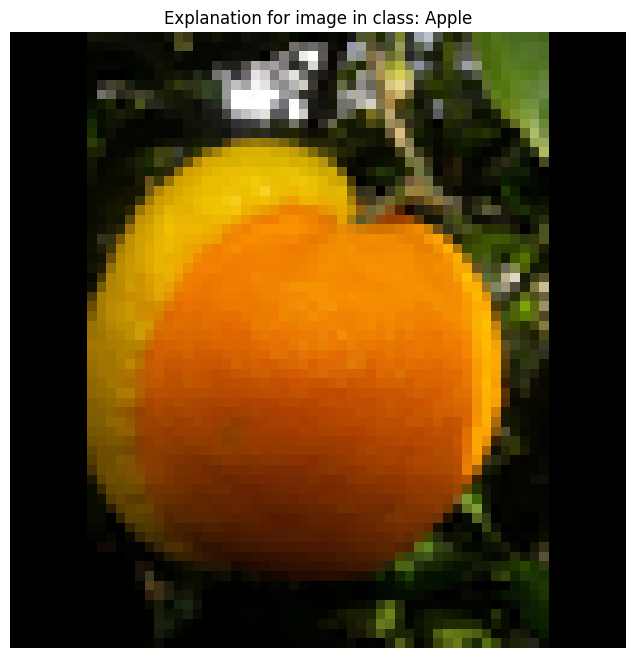

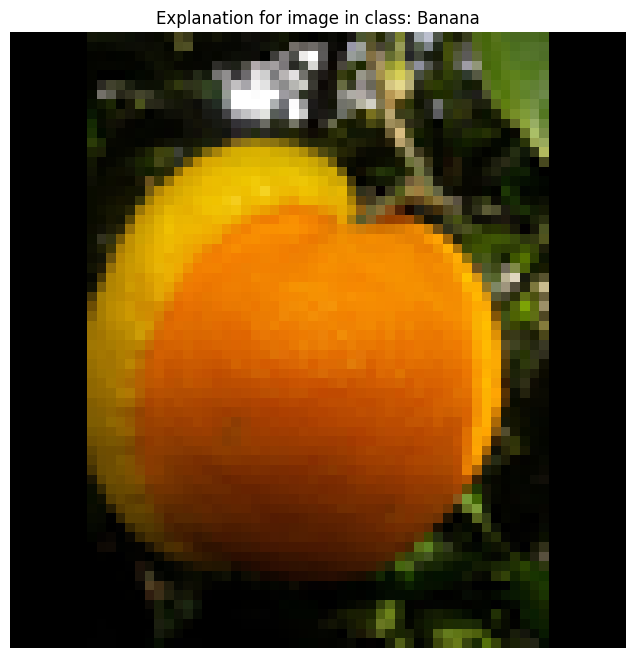

100%|██████████| 1000/1000 [00:01<00:00, 861.33it/s]


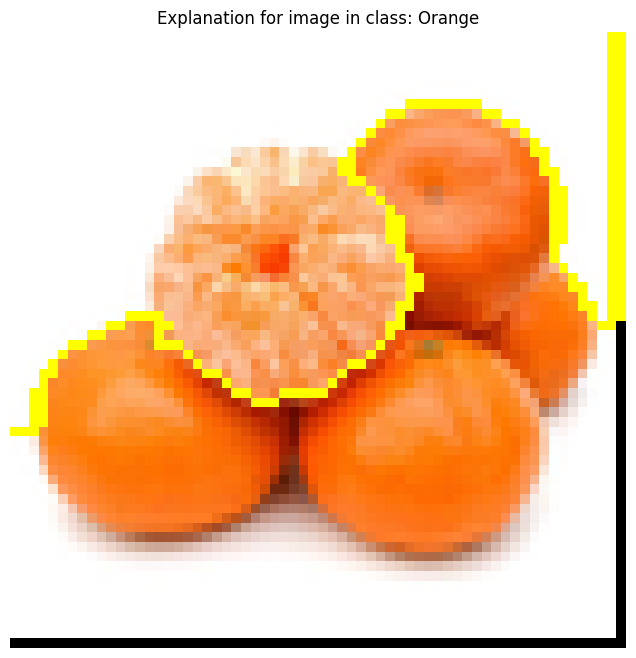

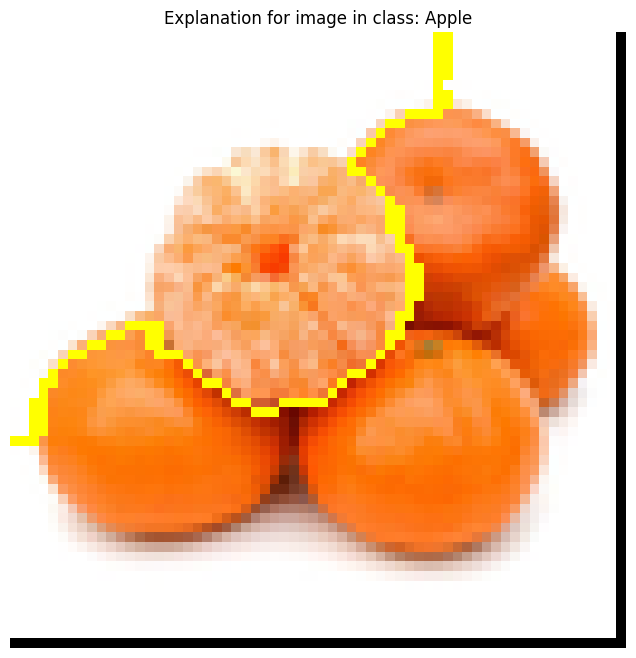

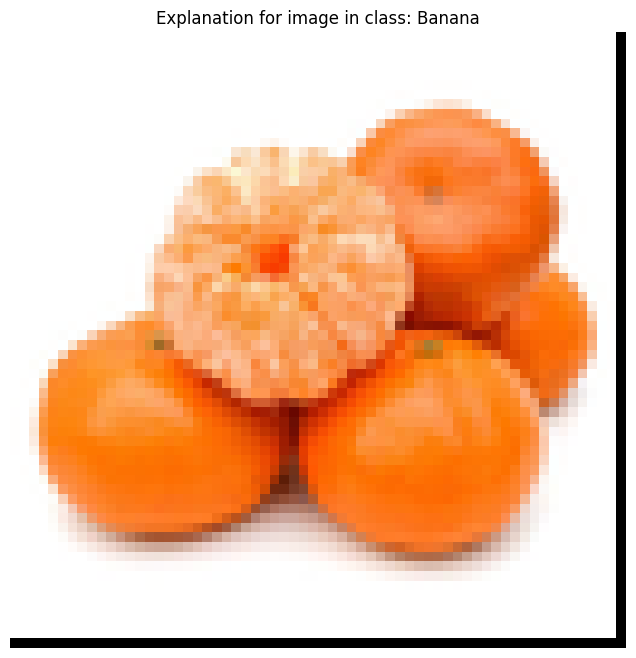

100%|██████████| 1000/1000 [00:01<00:00, 849.62it/s]


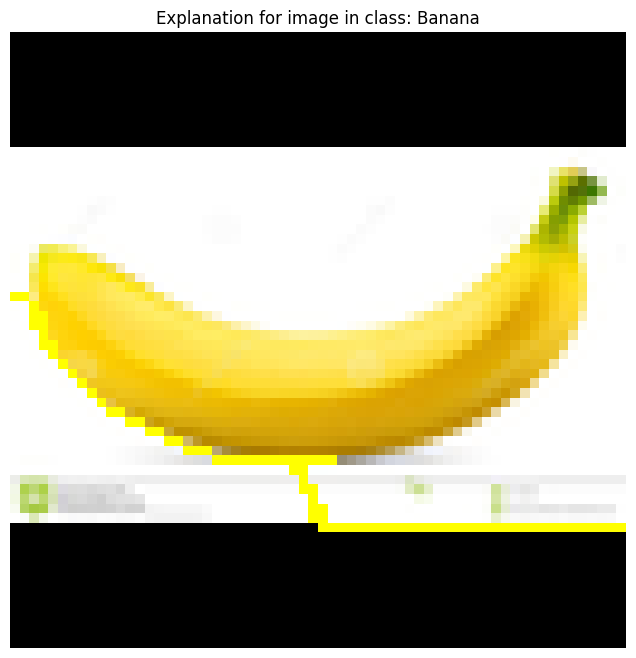

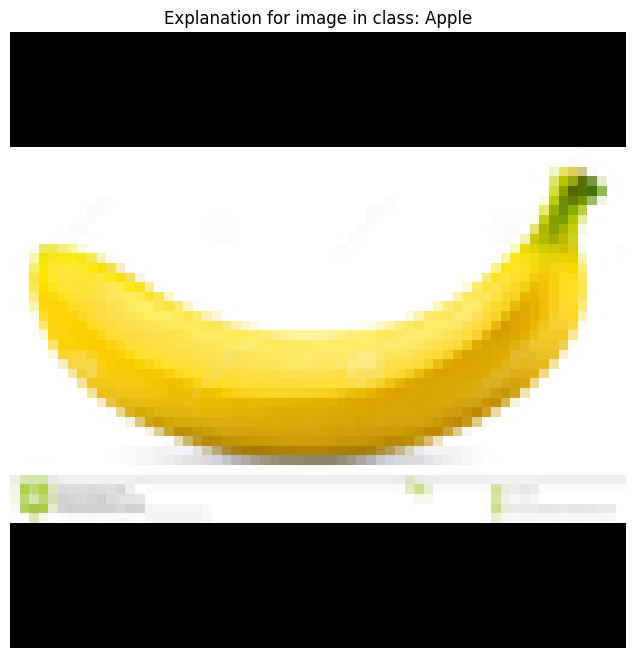

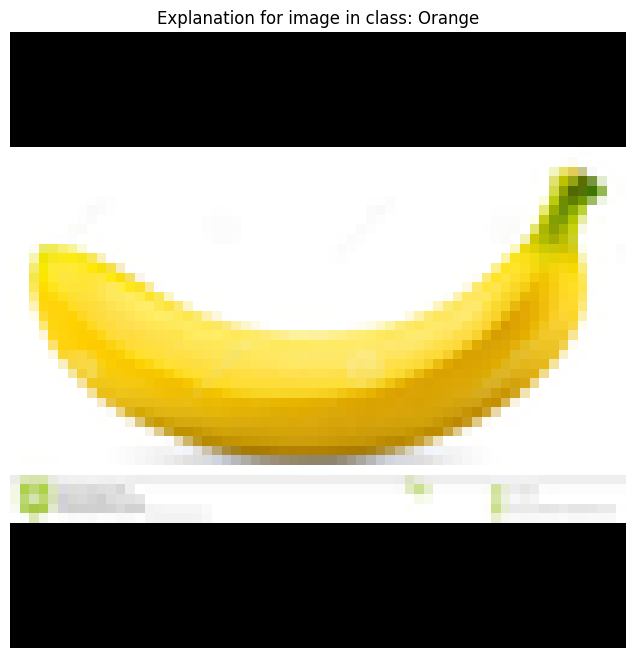

100%|██████████| 1000/1000 [00:01<00:00, 844.59it/s]


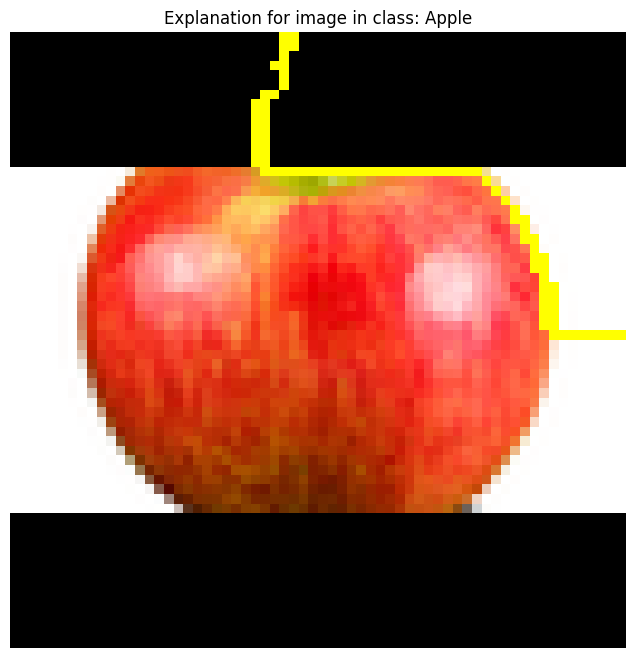

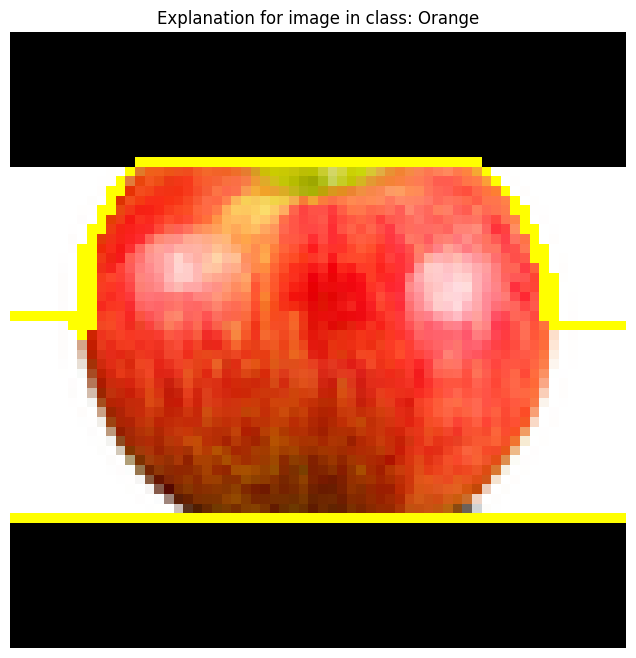

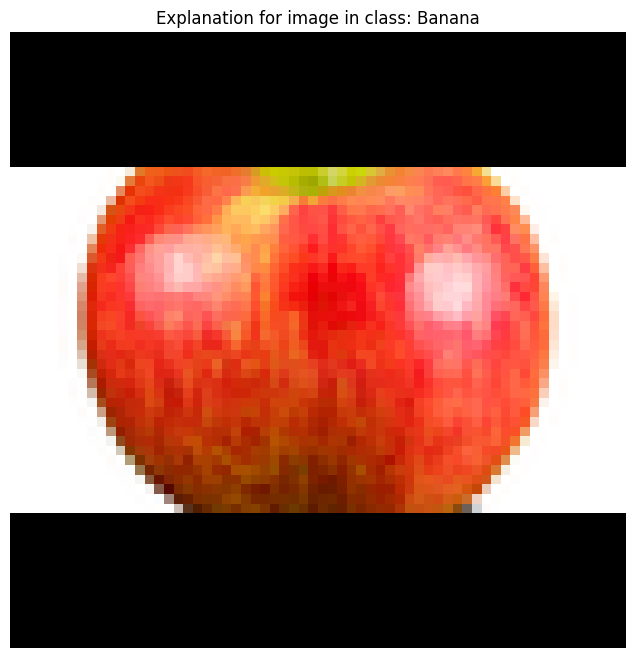

100%|██████████| 1000/1000 [00:01<00:00, 829.19it/s]


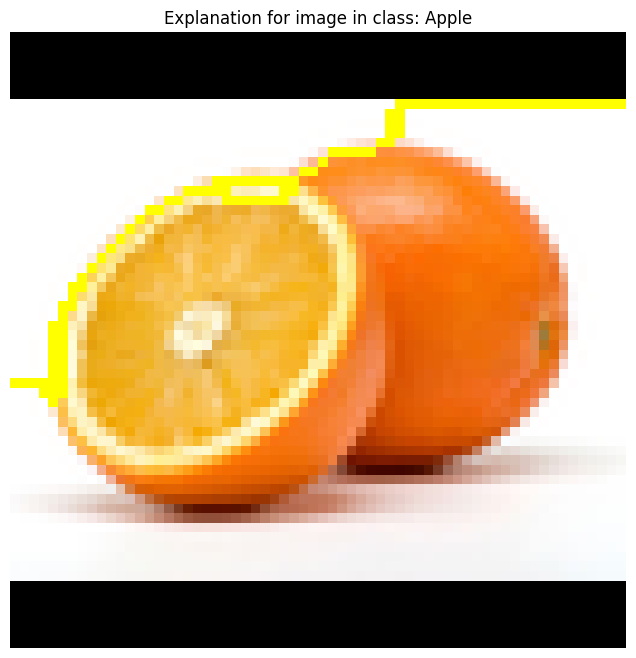

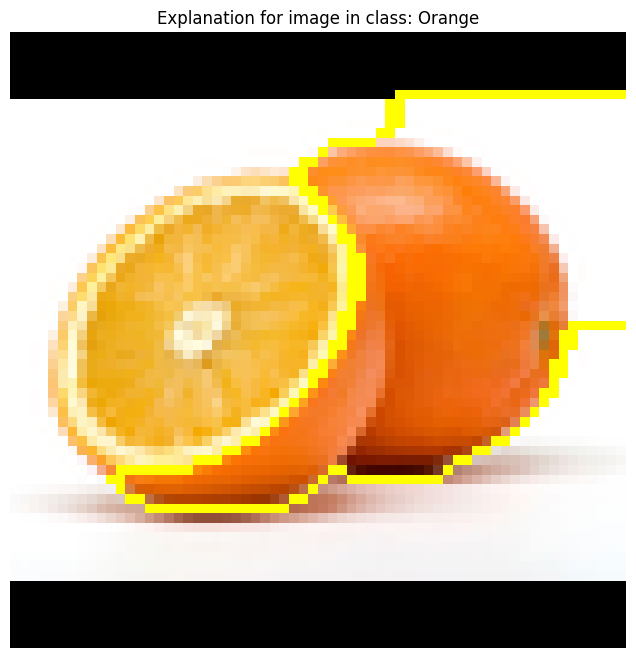

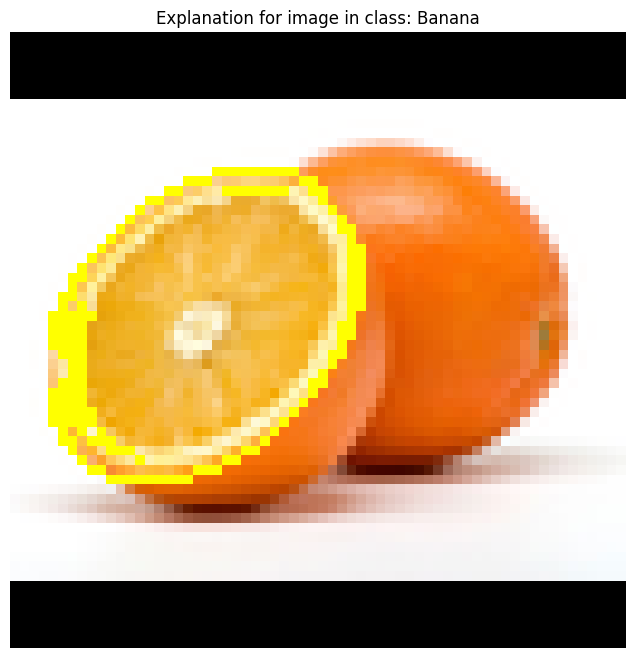

100%|██████████| 1000/1000 [00:01<00:00, 801.93it/s]


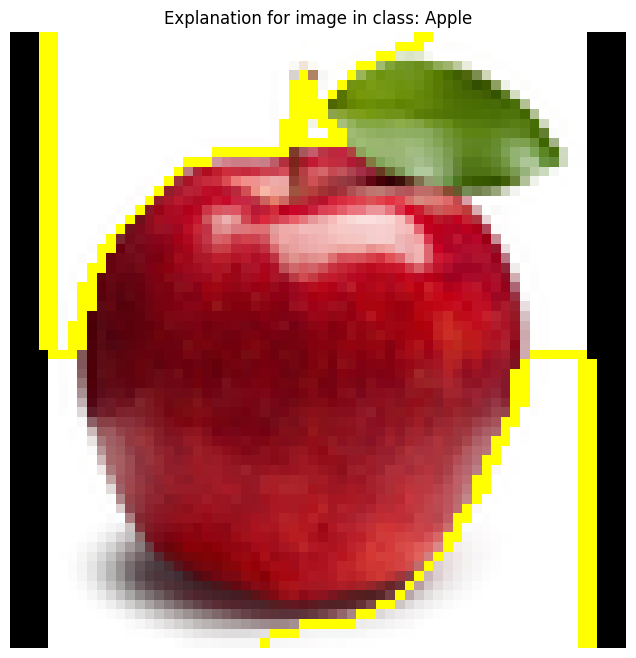

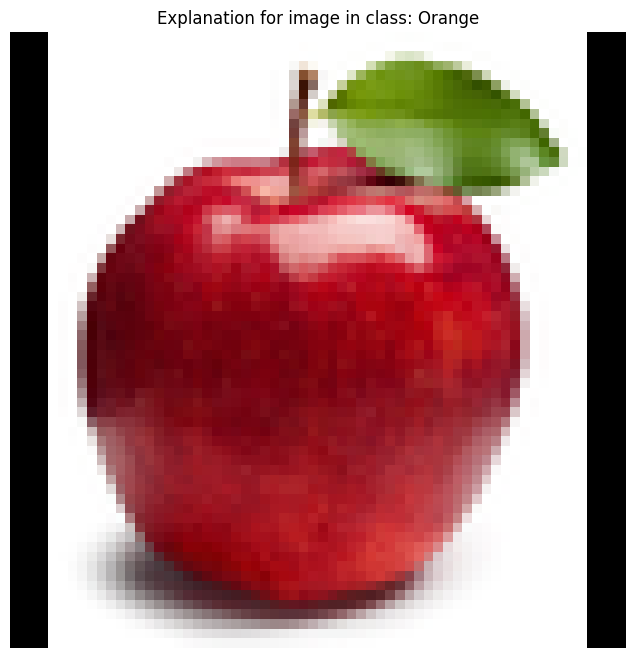

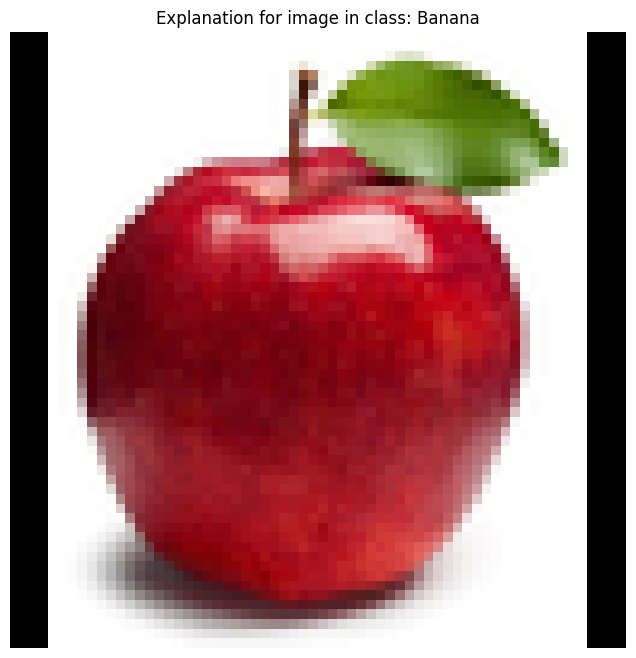

100%|██████████| 1000/1000 [00:01<00:00, 798.72it/s]


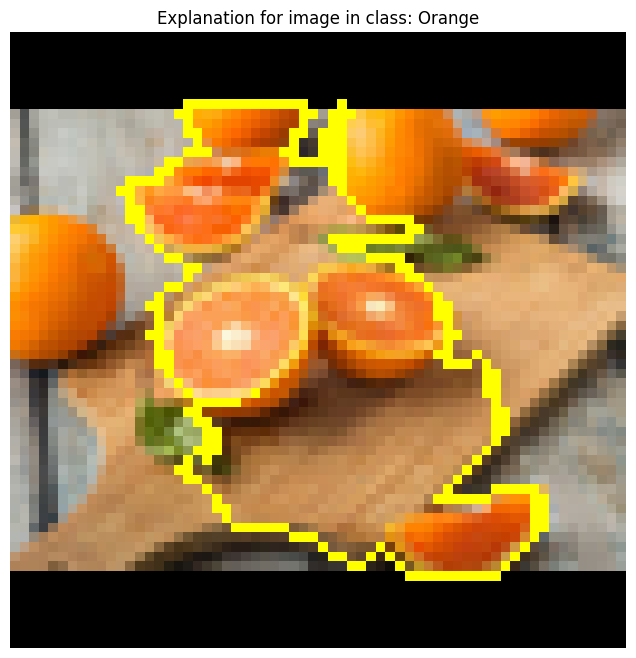

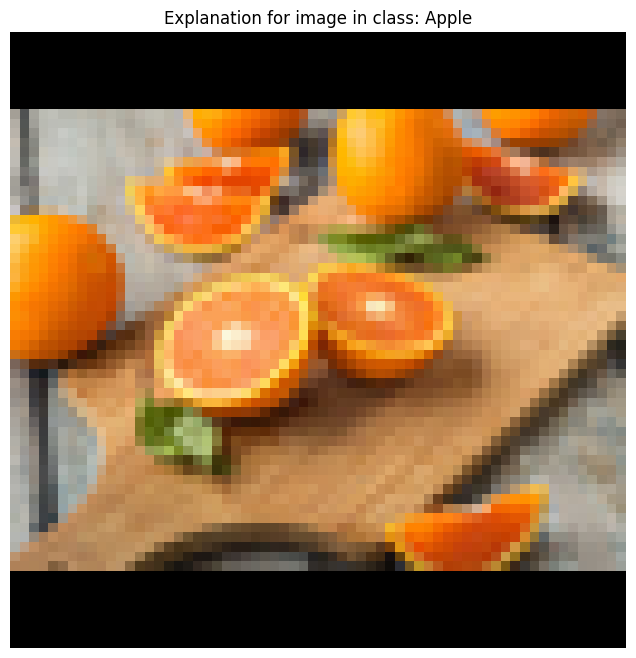

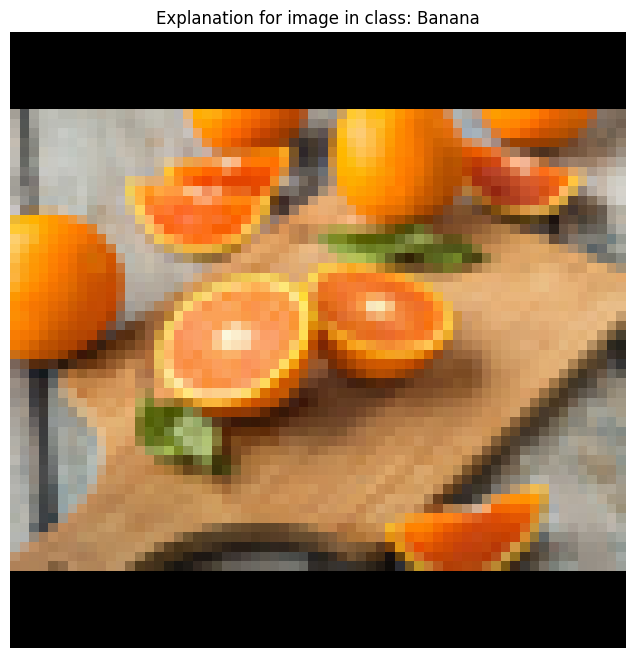

100%|██████████| 1000/1000 [00:01<00:00, 860.59it/s]


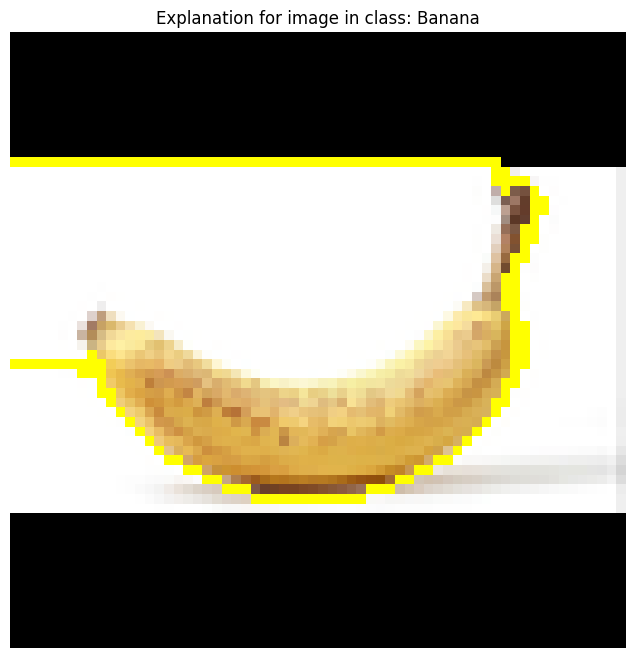

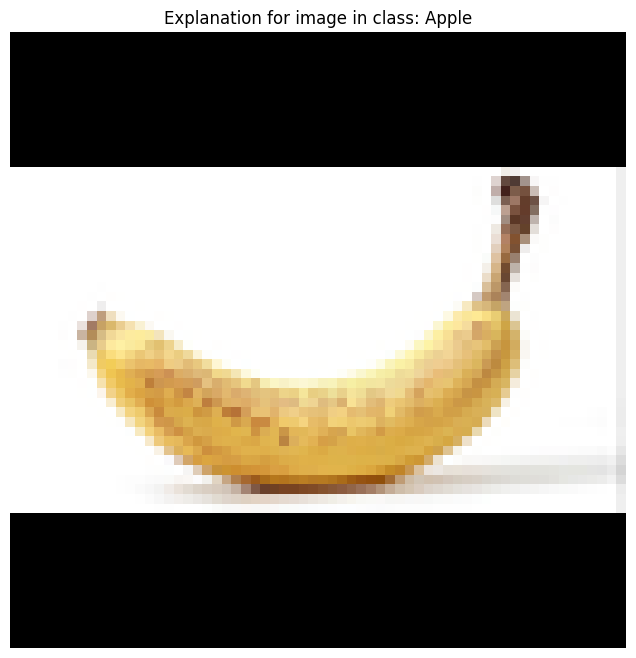

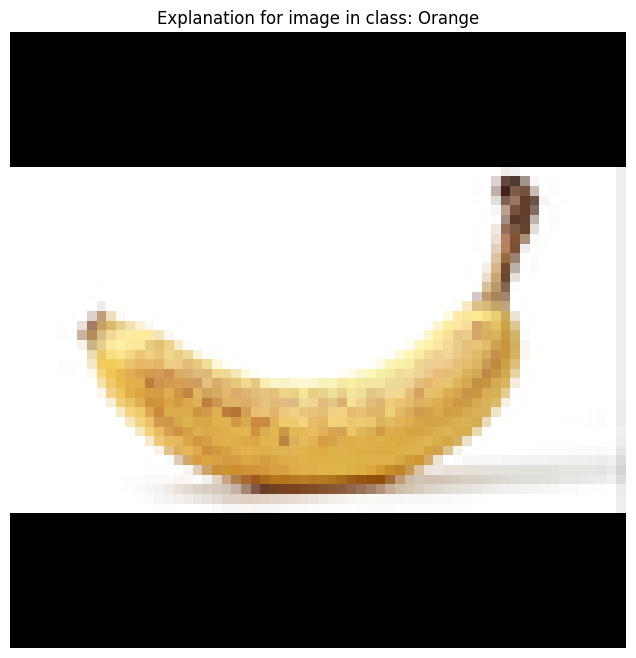

100%|██████████| 1000/1000 [00:01<00:00, 805.80it/s]


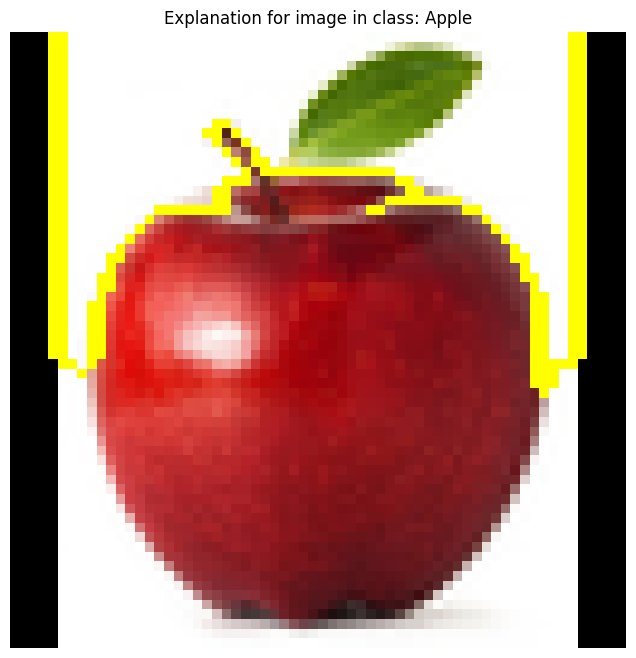

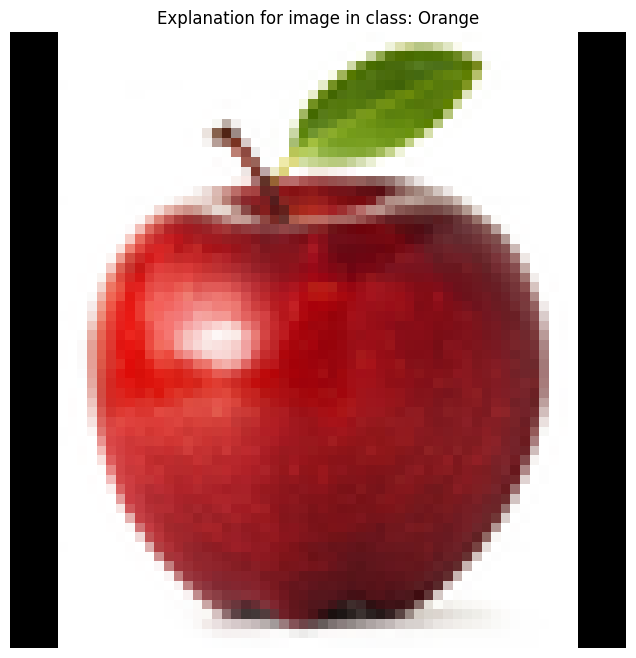

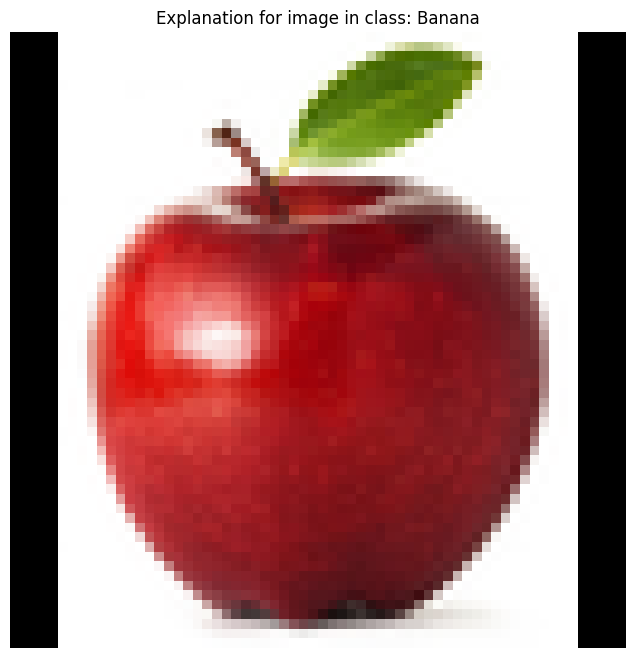

100%|██████████| 1000/1000 [00:01<00:00, 841.04it/s]


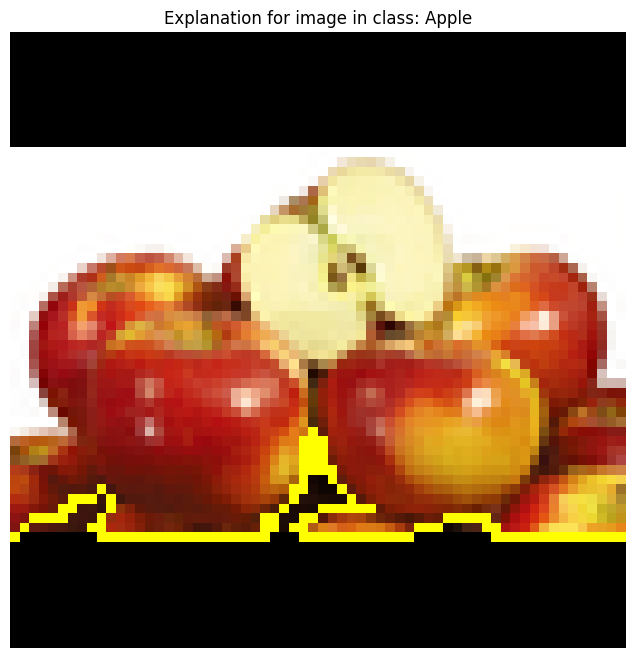

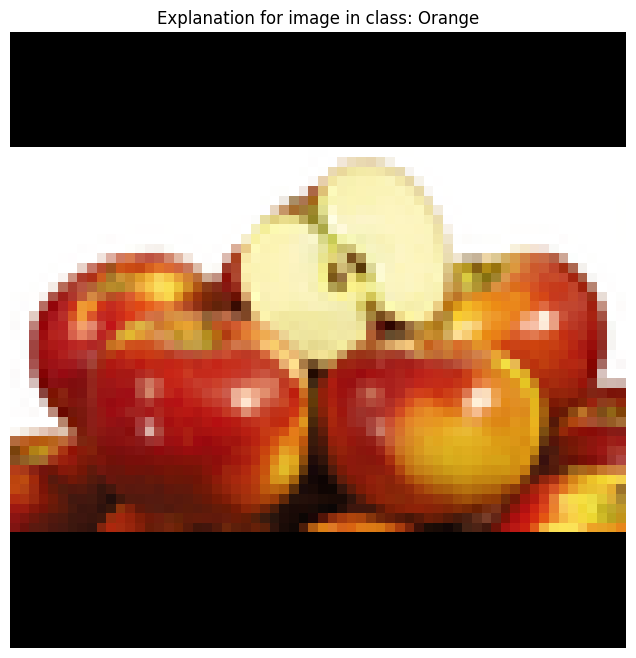

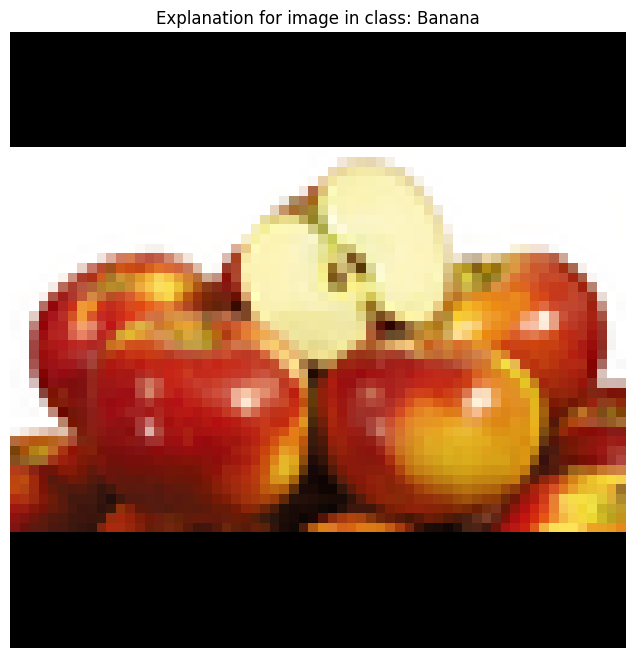

100%|██████████| 1000/1000 [00:01<00:00, 817.66it/s]


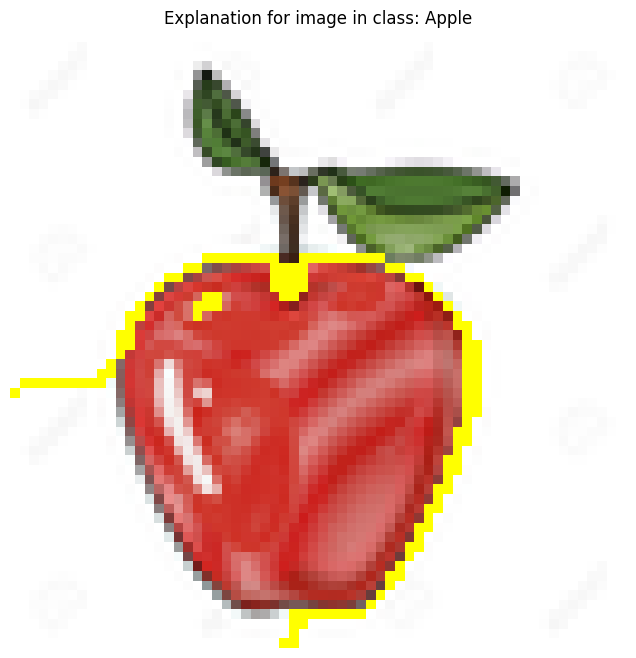

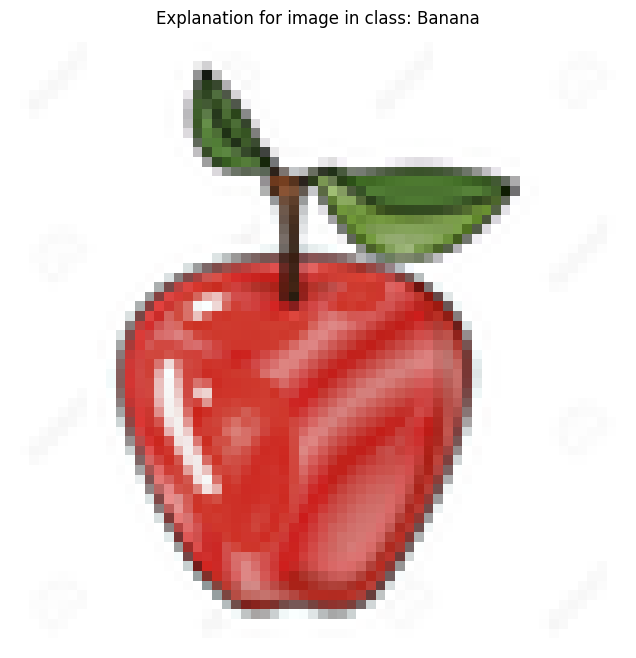

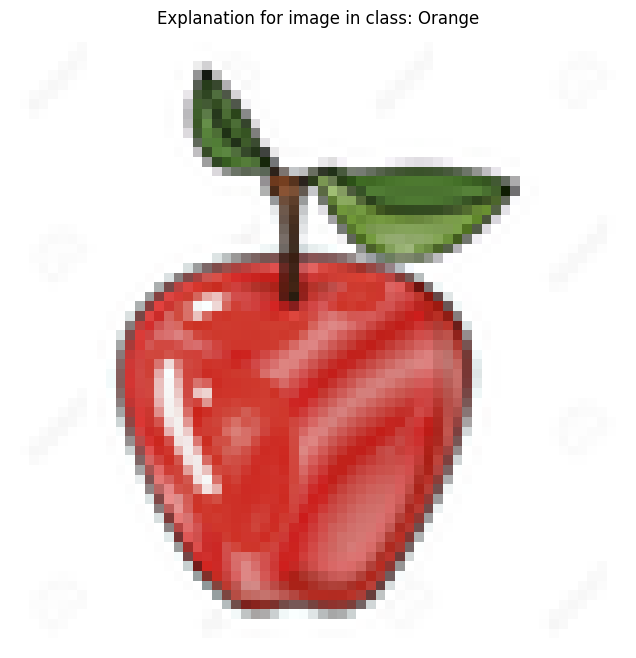

100%|██████████| 1000/1000 [00:01<00:00, 836.82it/s]


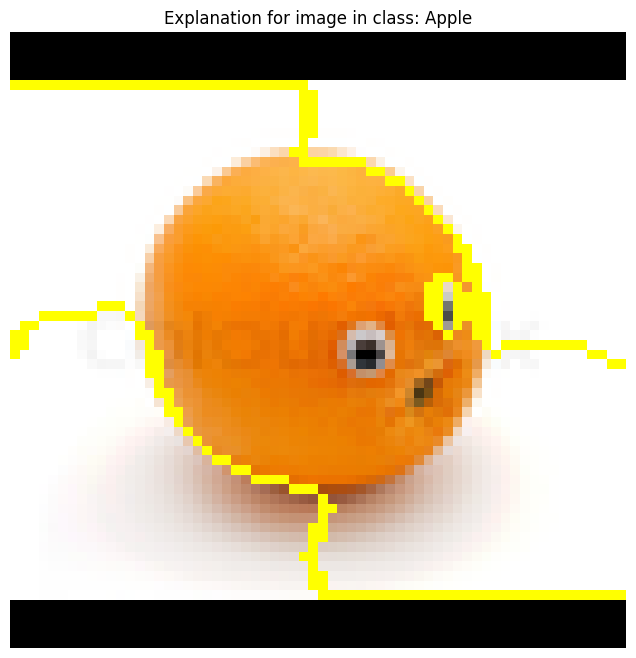

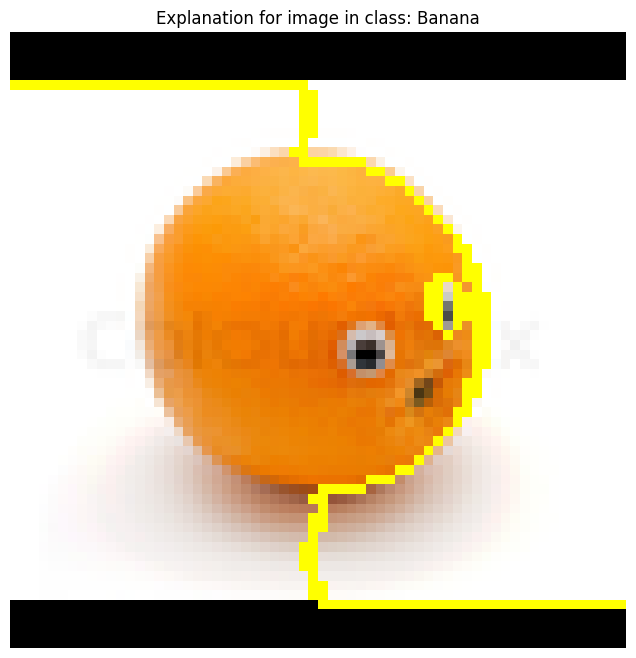

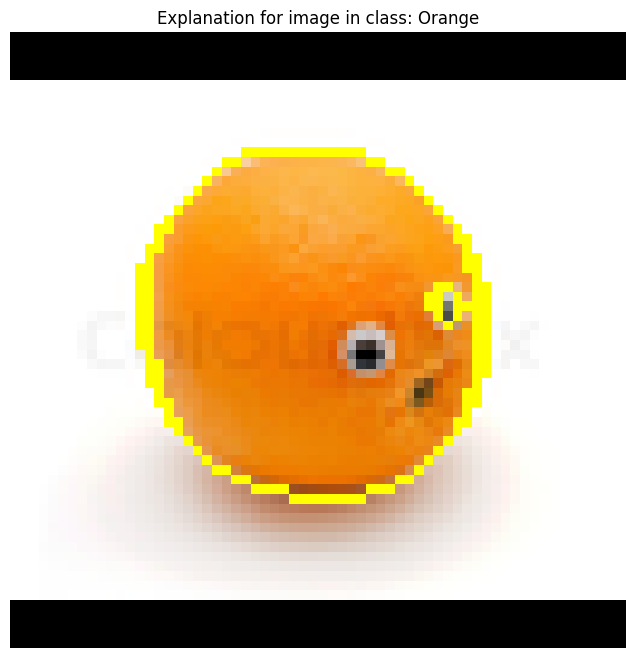

100%|██████████| 1000/1000 [00:01<00:00, 827.82it/s]


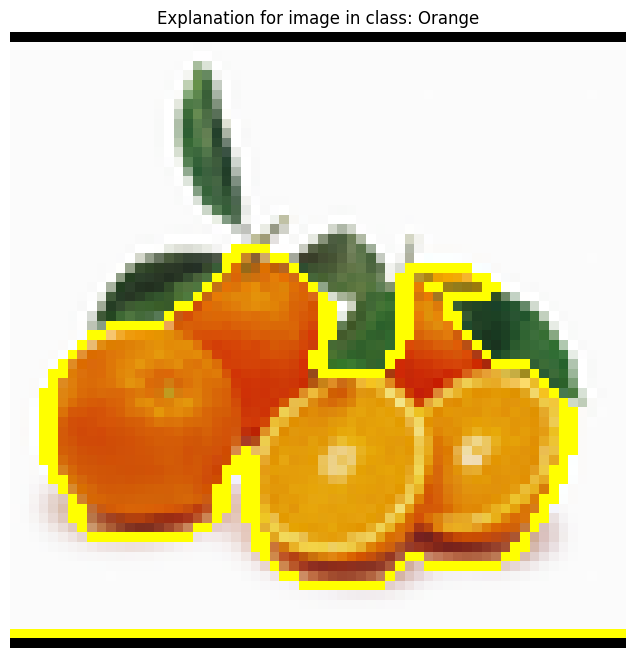

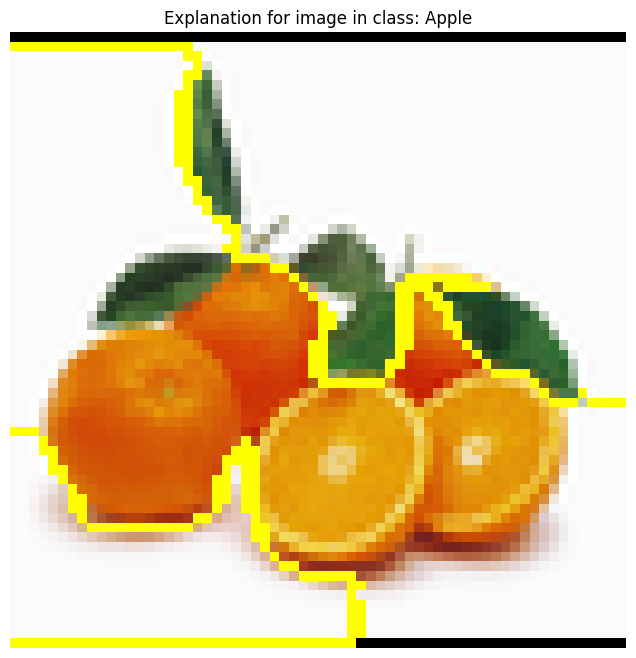

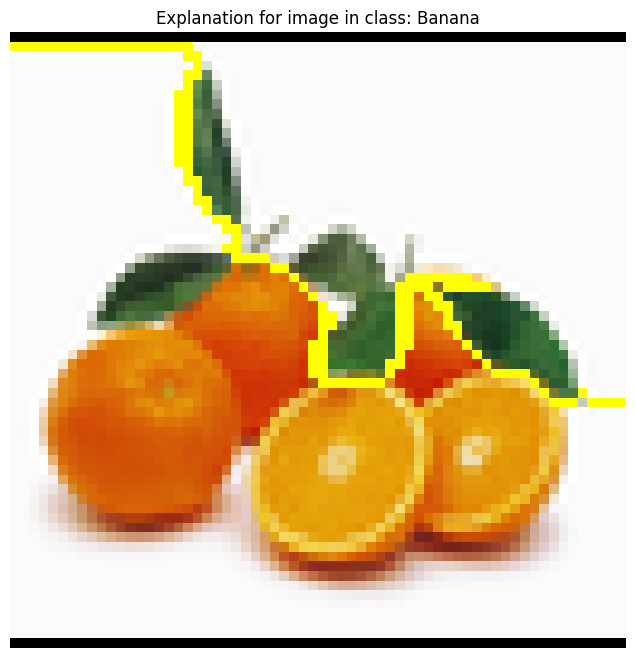

100%|██████████| 1000/1000 [00:01<00:00, 819.68it/s]


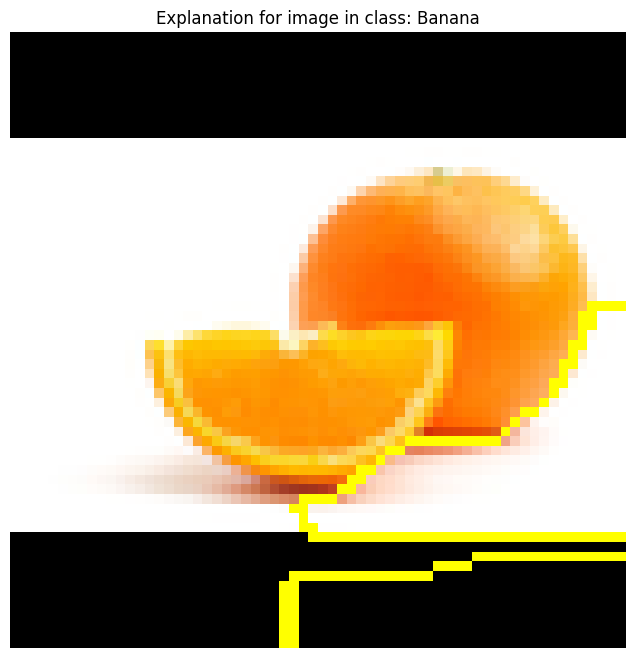

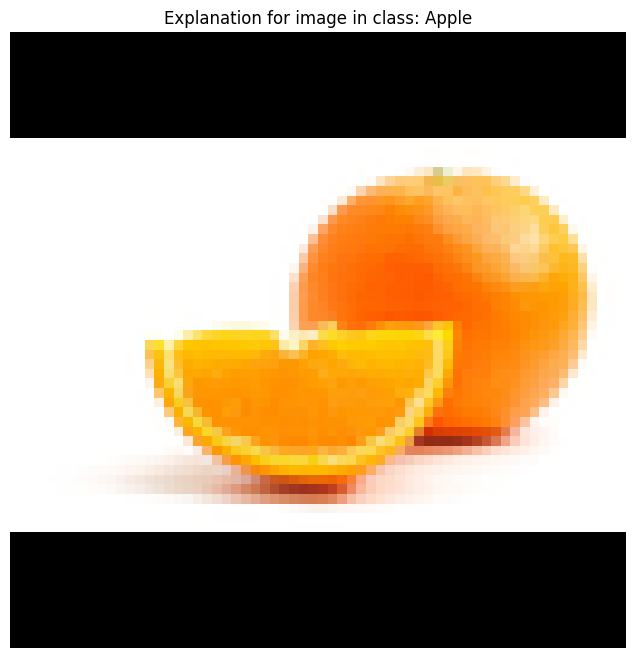

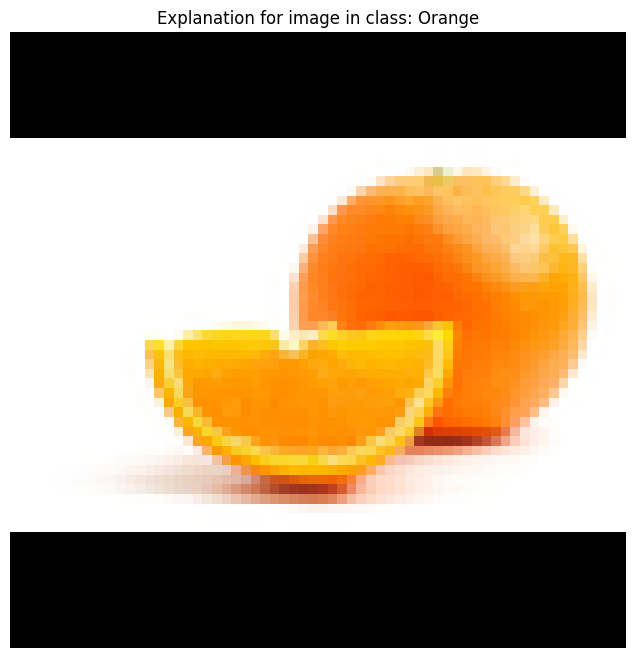

100%|██████████| 1000/1000 [00:01<00:00, 817.66it/s]


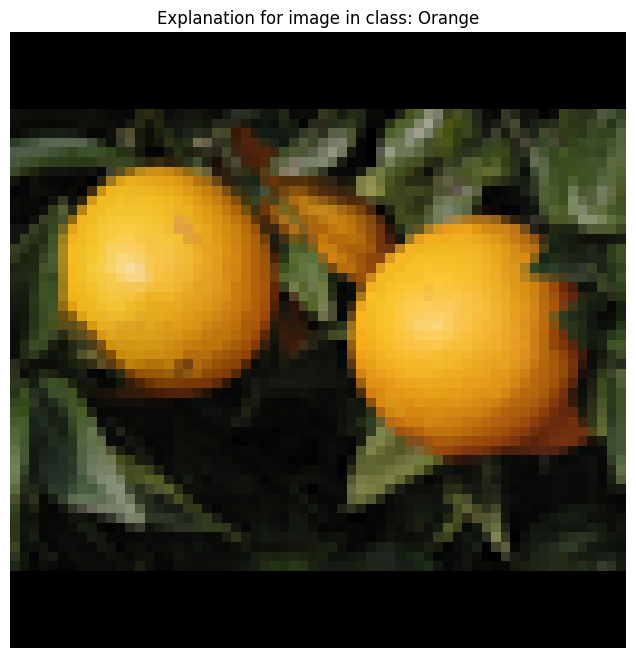

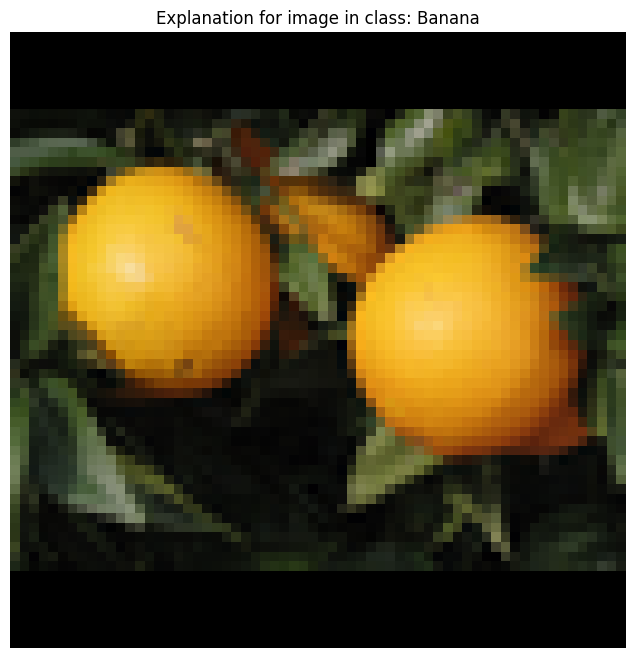

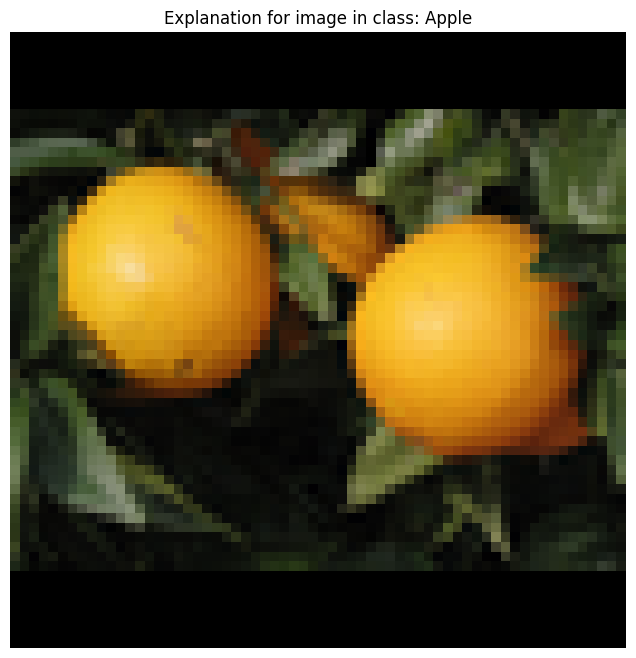

100%|██████████| 1000/1000 [00:01<00:00, 816.33it/s]


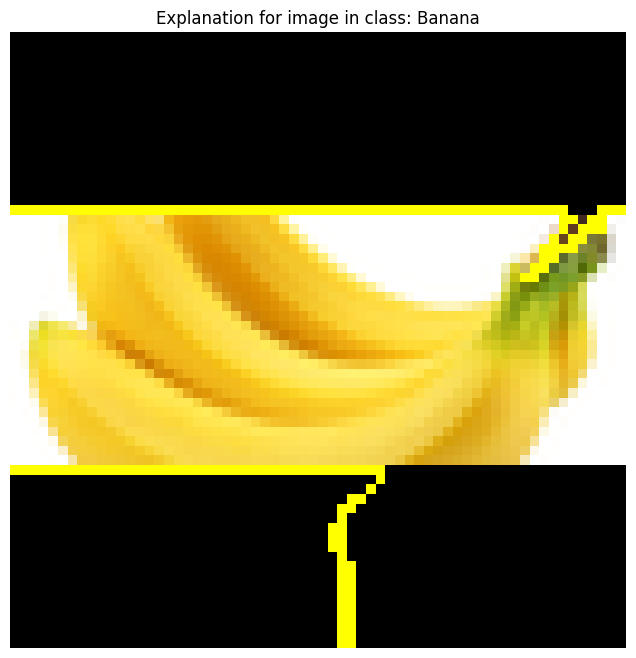

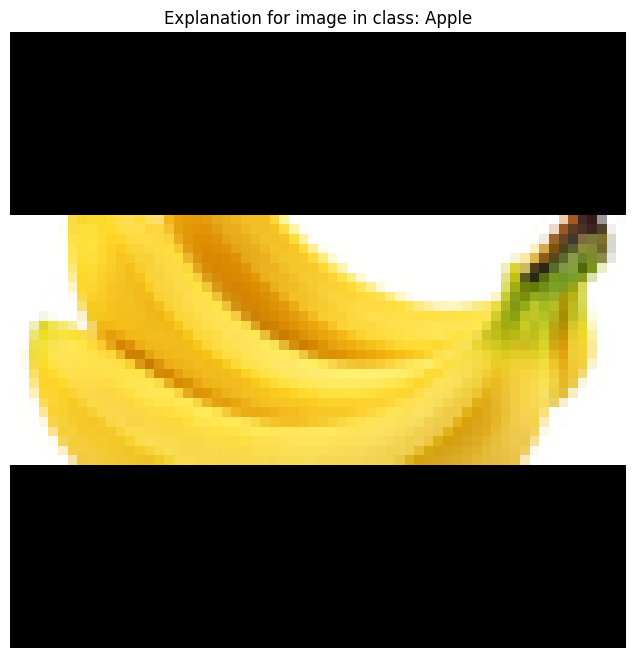

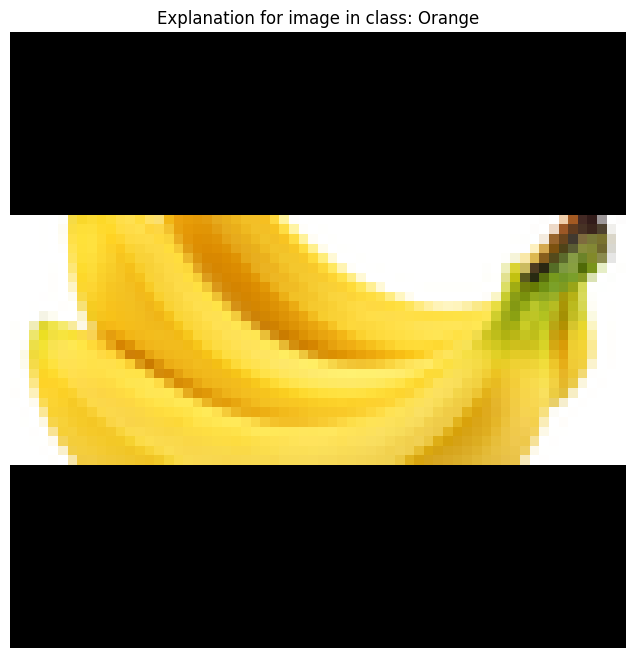

100%|██████████| 1000/1000 [00:01<00:00, 985.22it/s]


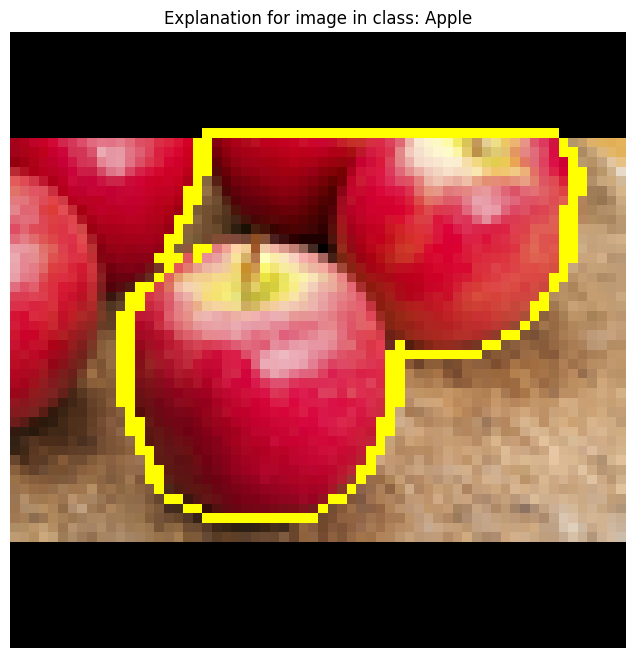

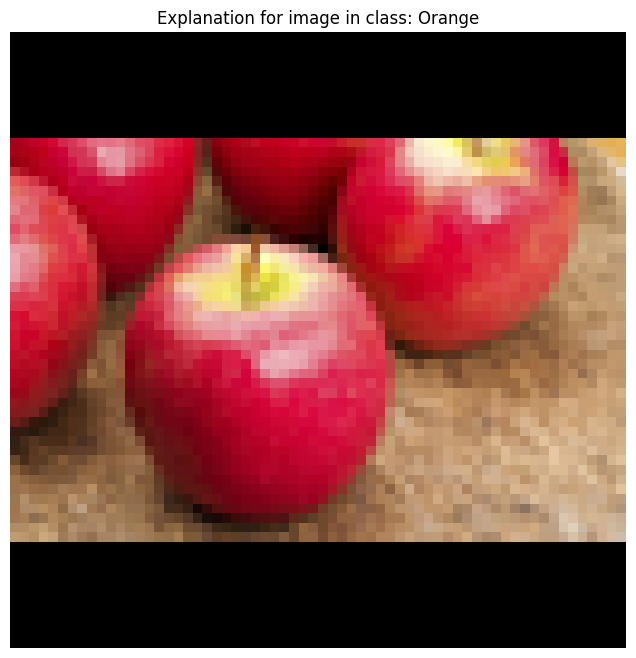

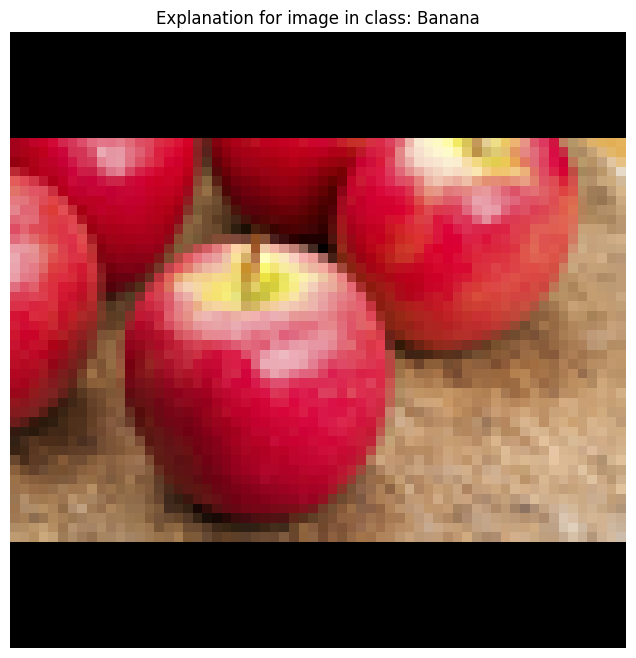

100%|██████████| 1000/1000 [00:01<00:00, 809.06it/s]


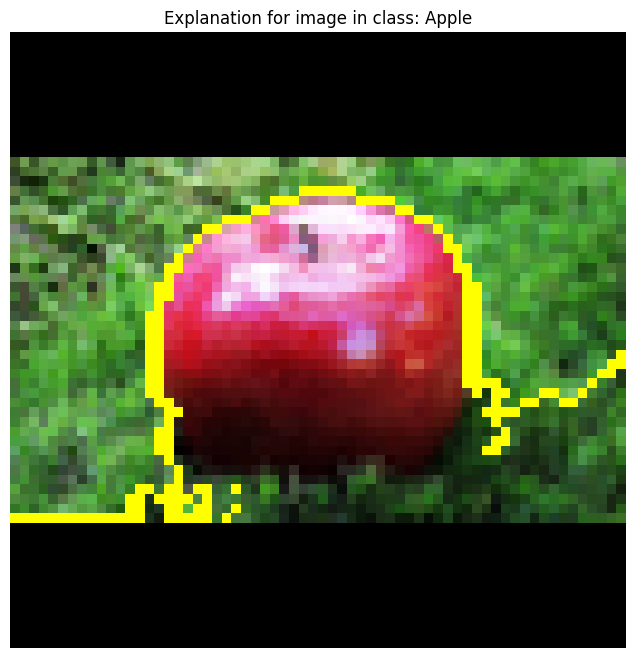

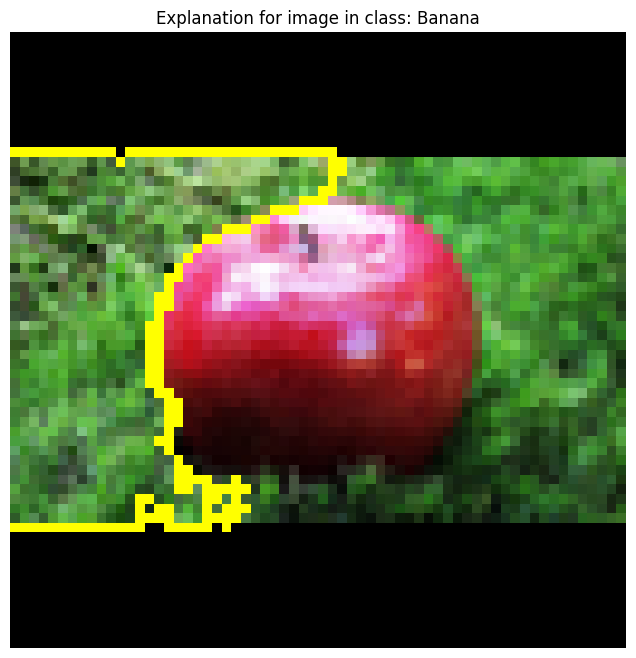

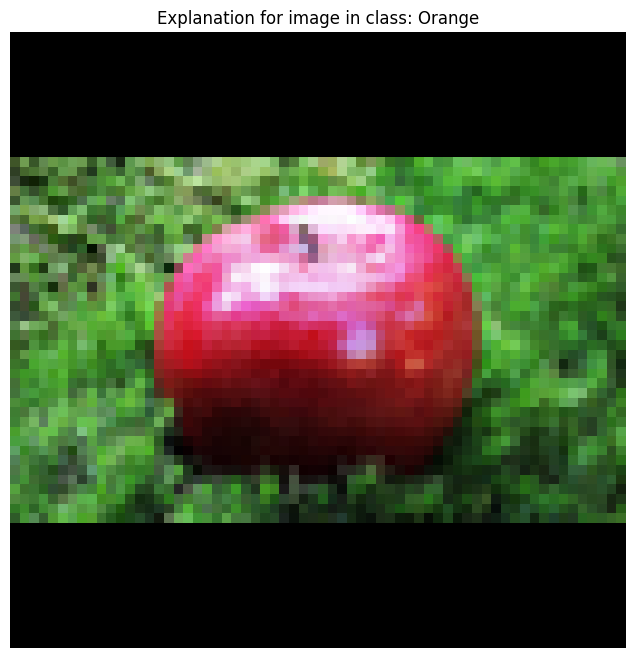

100%|██████████| 1000/1000 [00:01<00:00, 799.36it/s]


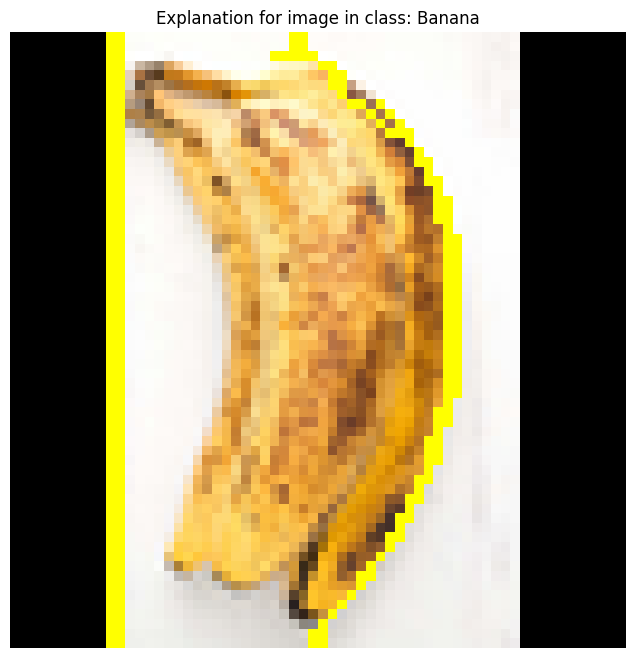

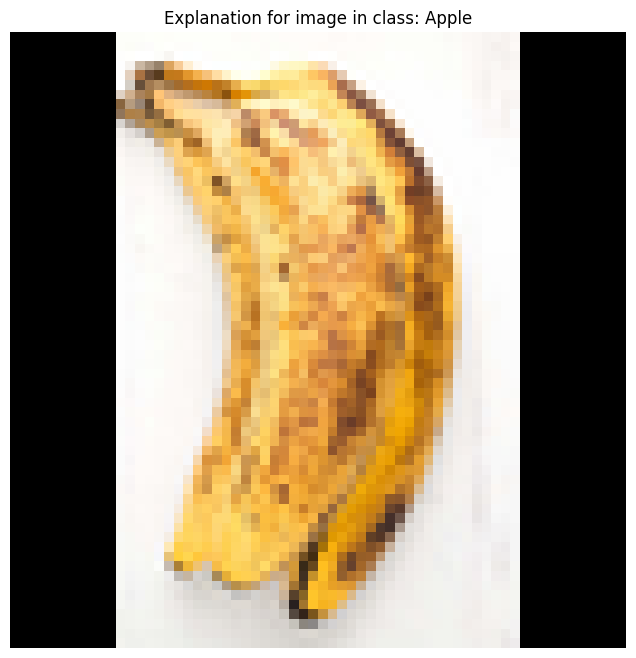

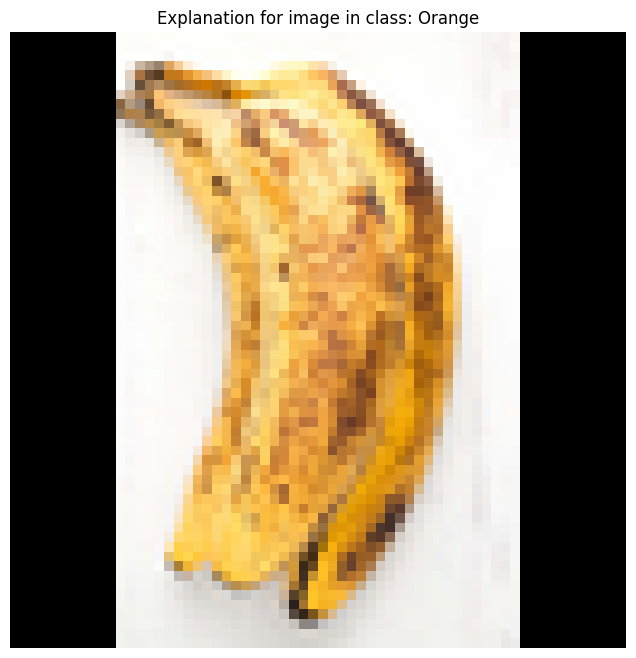

100%|██████████| 1000/1000 [00:01<00:00, 828.50it/s]


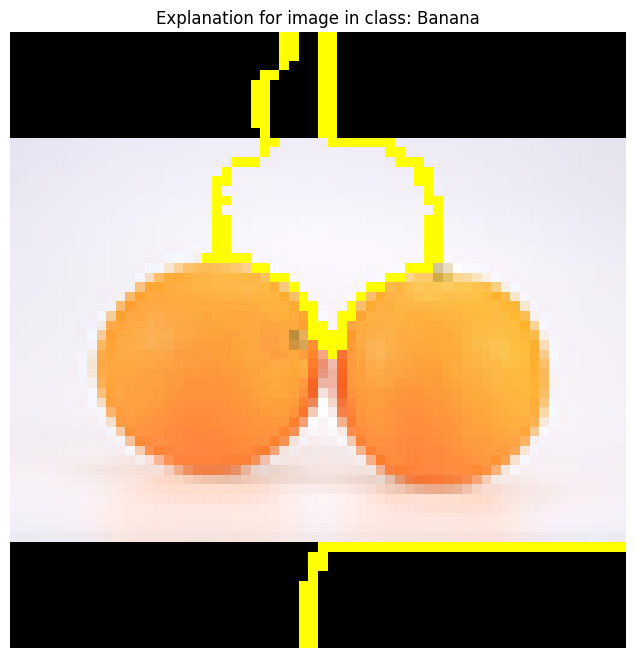

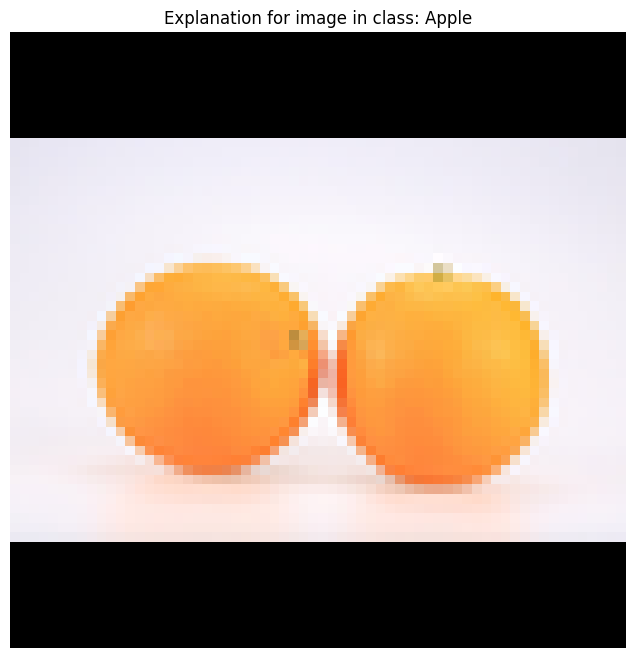

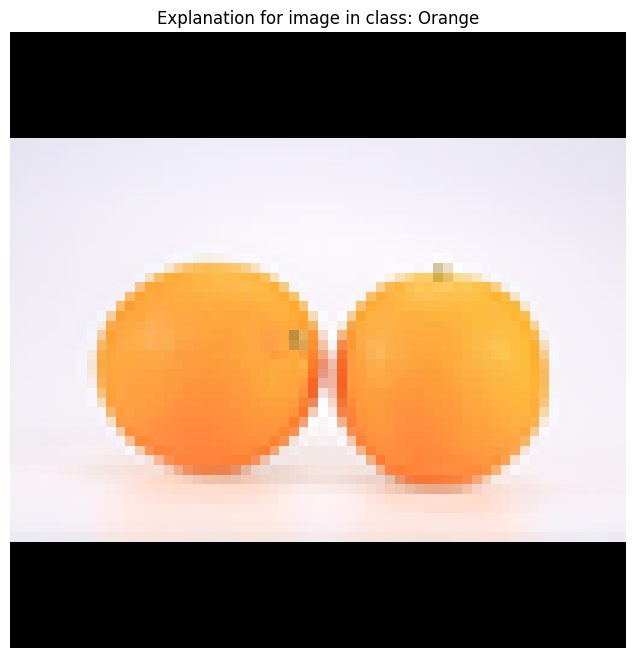

100%|██████████| 1000/1000 [00:01<00:00, 821.02it/s]


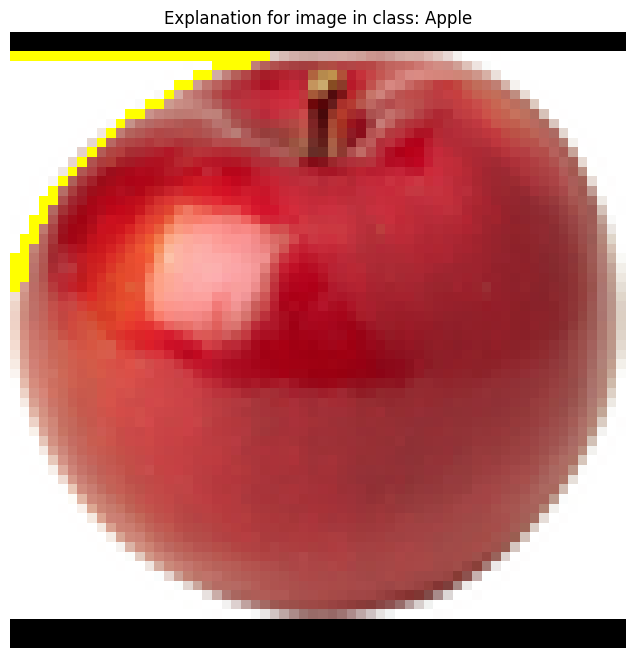

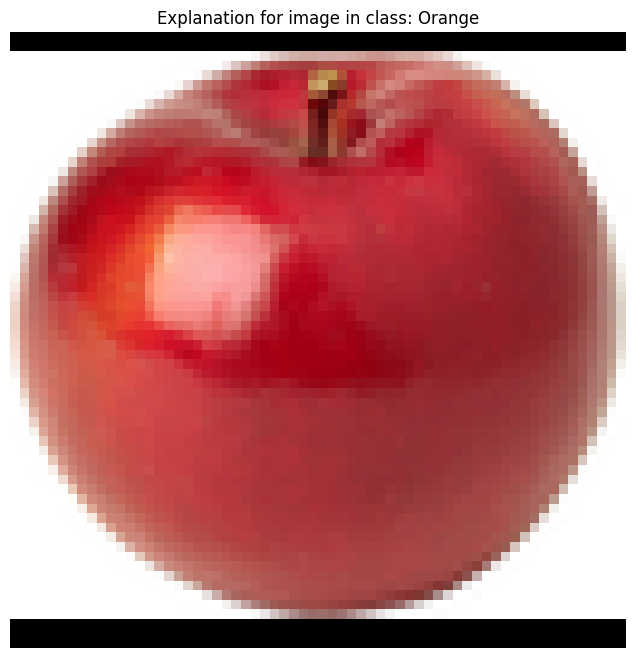

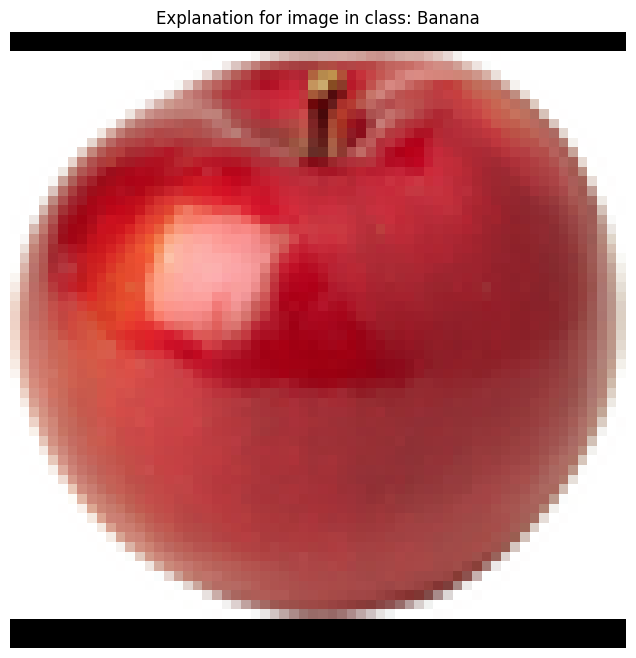

100%|██████████| 1000/1000 [00:01<00:00, 829.88it/s]


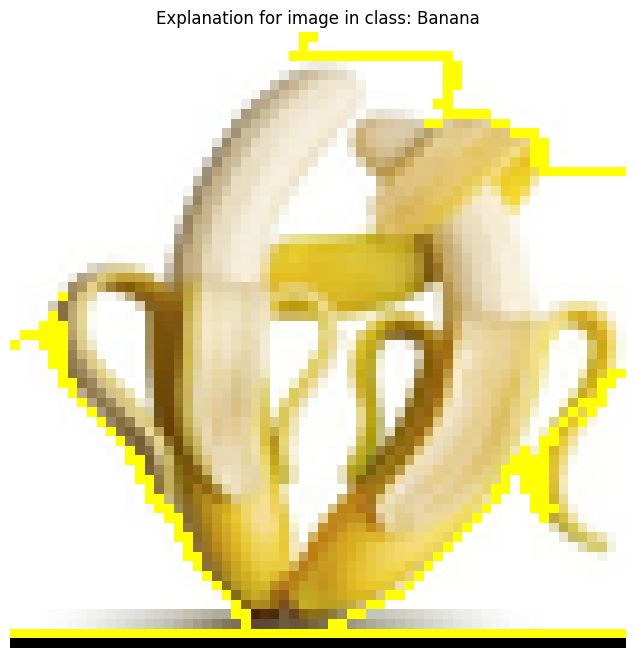

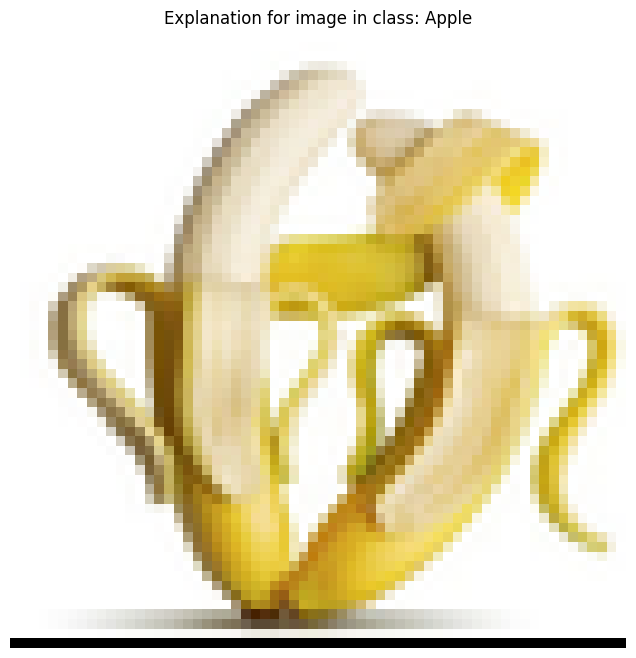

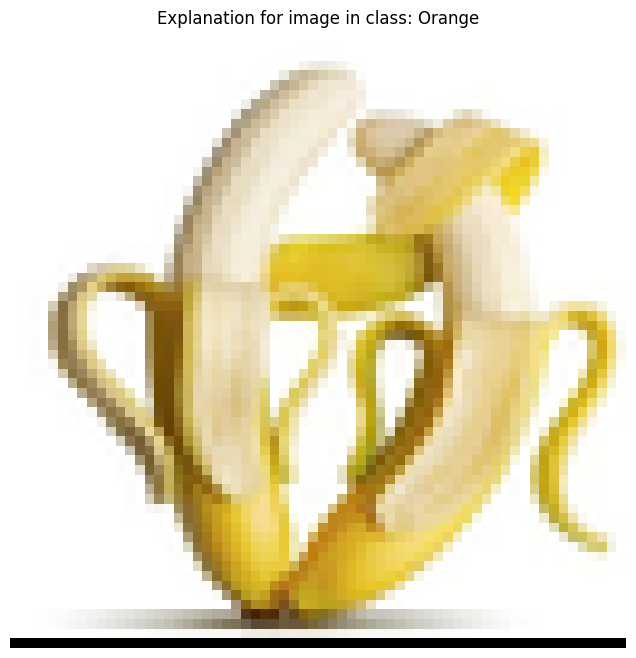

100%|██████████| 1000/1000 [00:01<00:00, 826.45it/s]


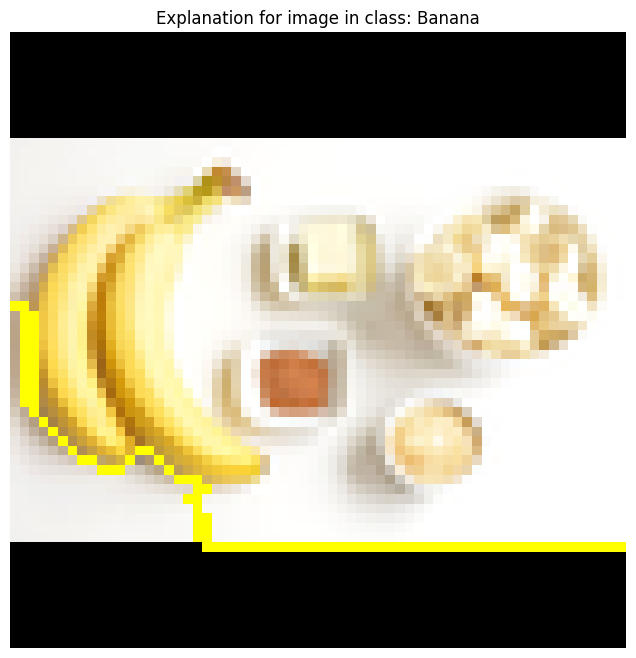

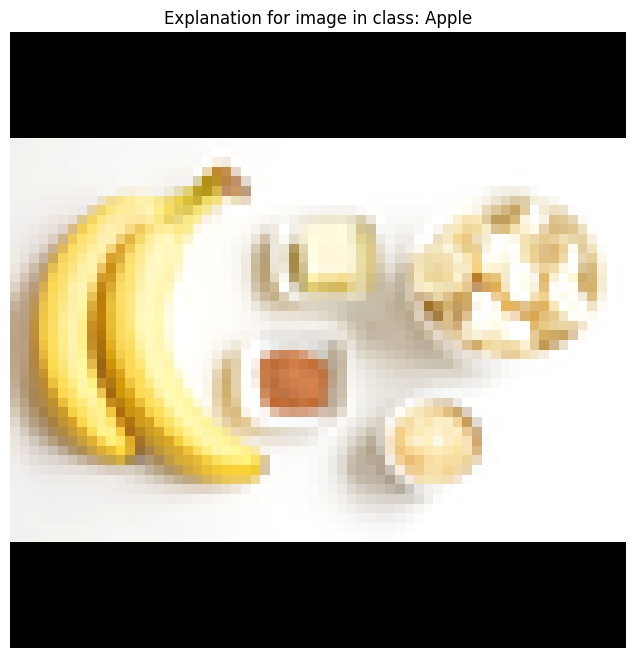

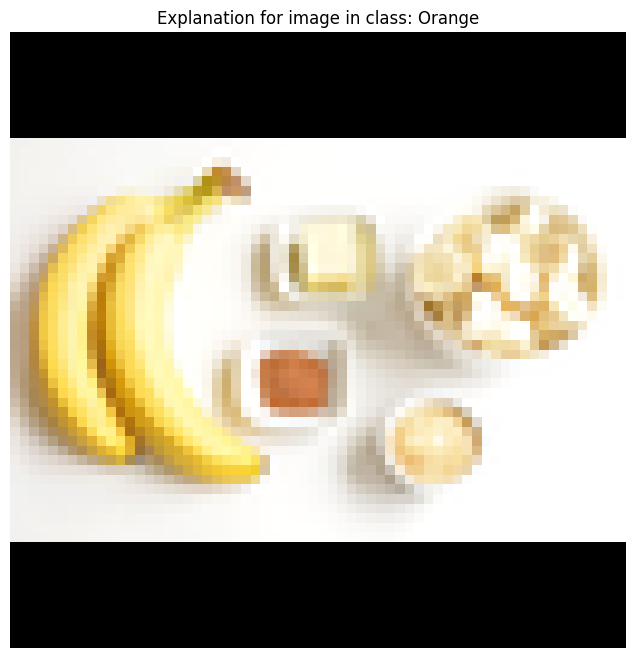

100%|██████████| 1000/1000 [00:01<00:00, 794.91it/s]


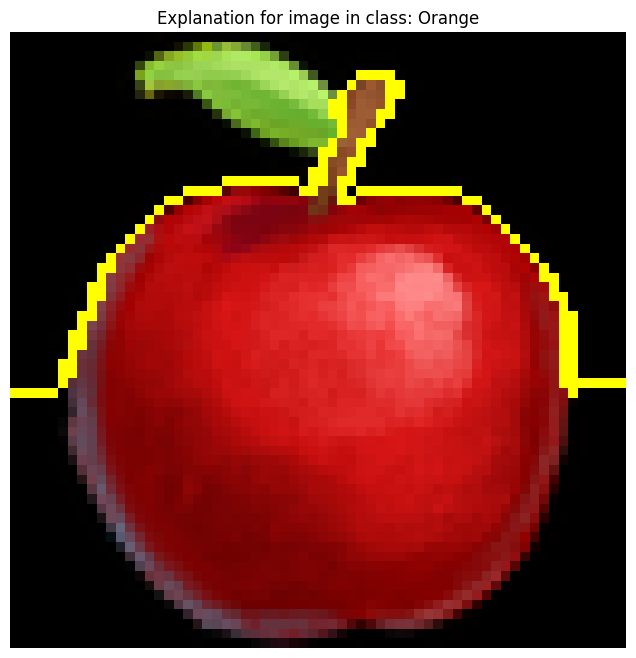

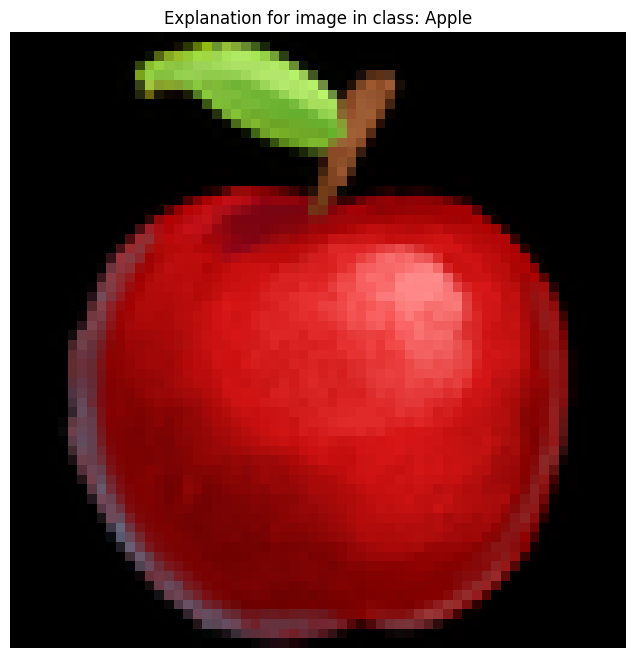

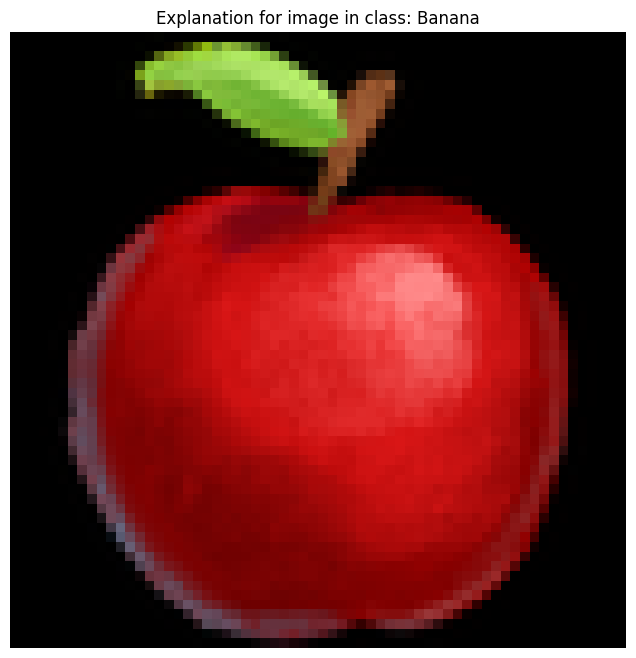

100%|██████████| 1000/1000 [00:01<00:00, 831.94it/s]


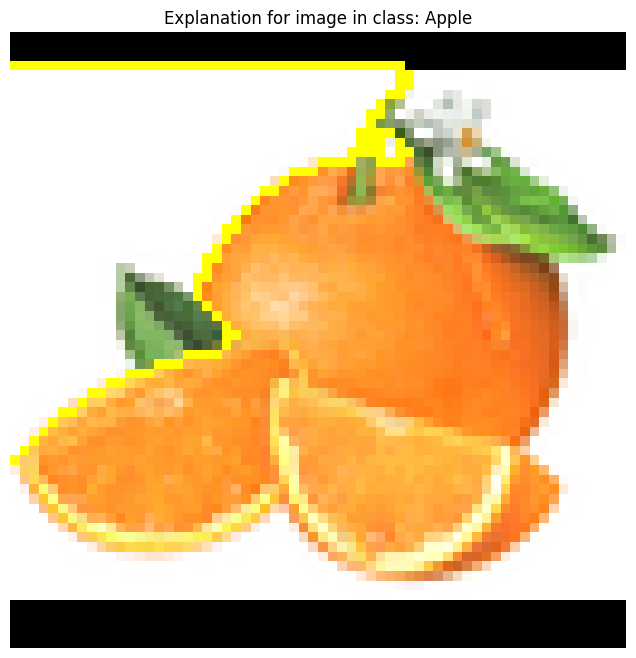

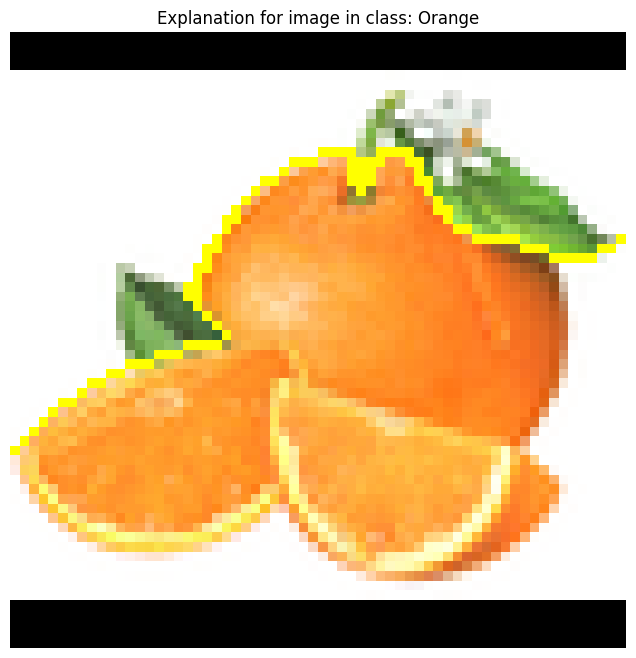

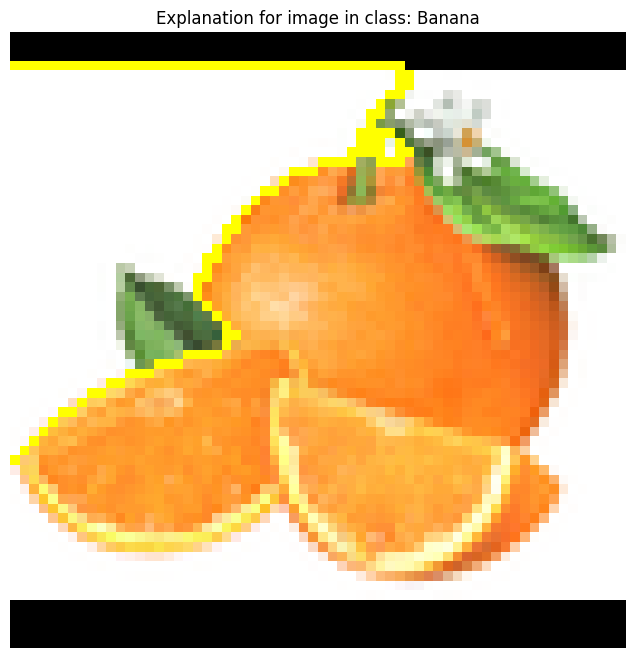

100%|██████████| 1000/1000 [00:01<00:00, 853.25it/s]


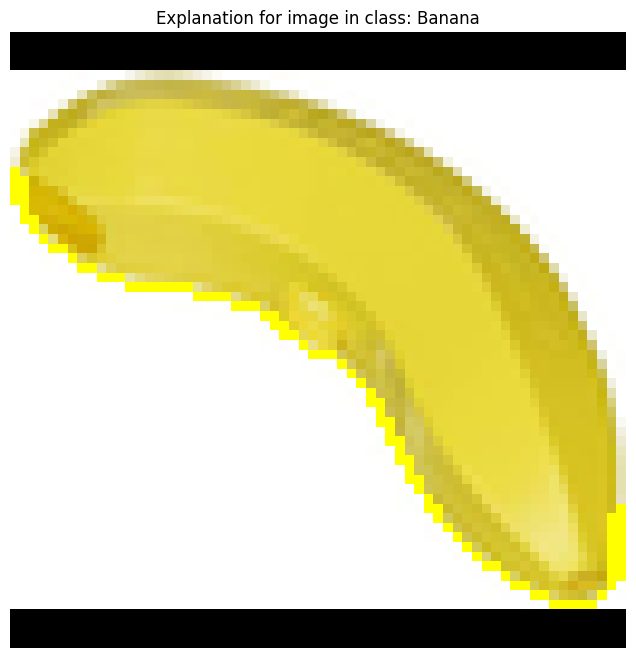

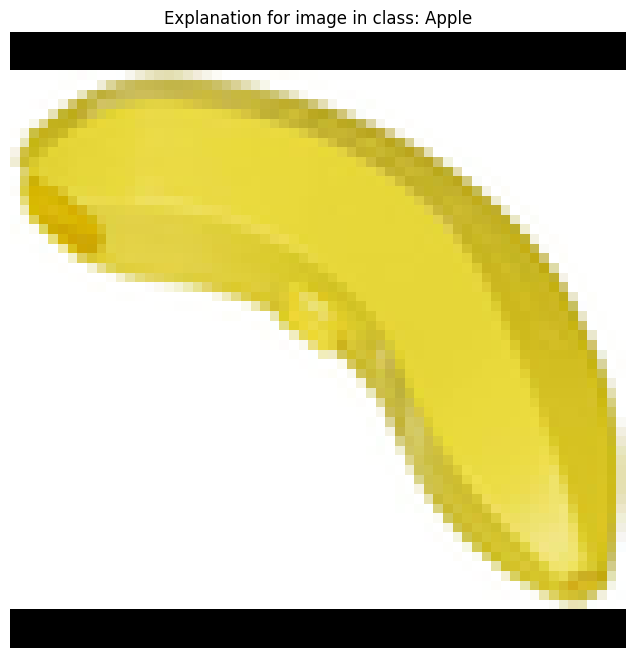

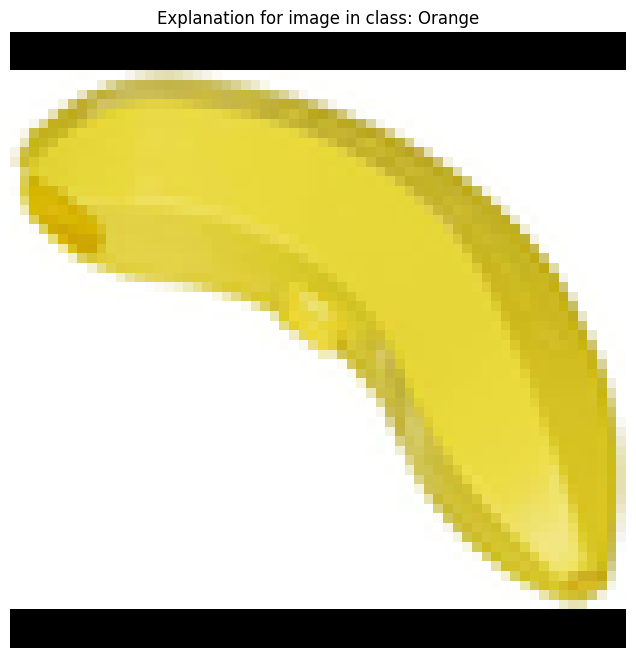

100%|██████████| 1000/1000 [00:01<00:00, 844.60it/s]


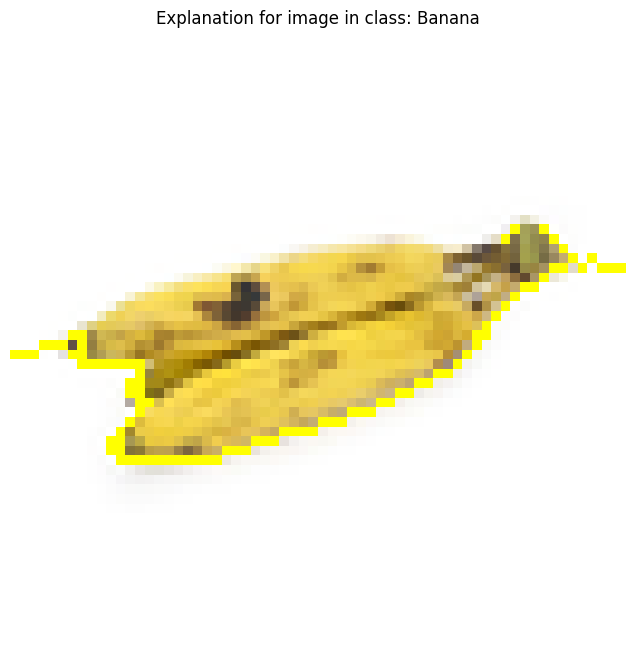

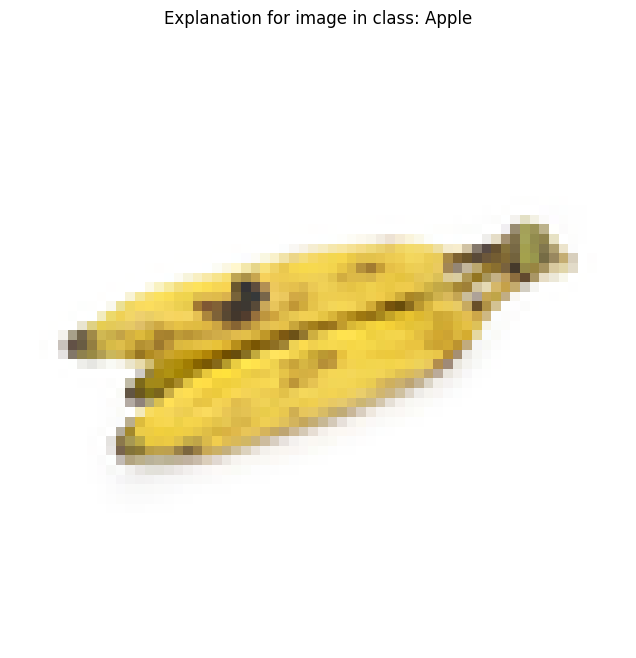

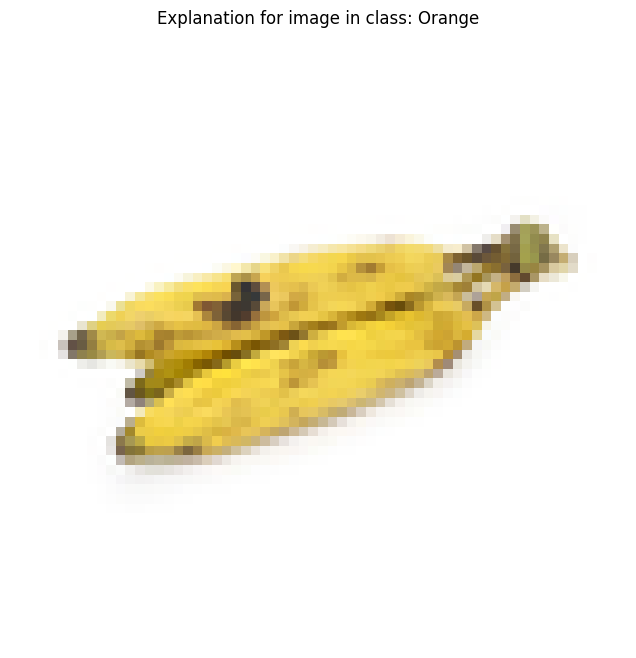

100%|██████████| 1000/1000 [00:01<00:00, 798.09it/s]


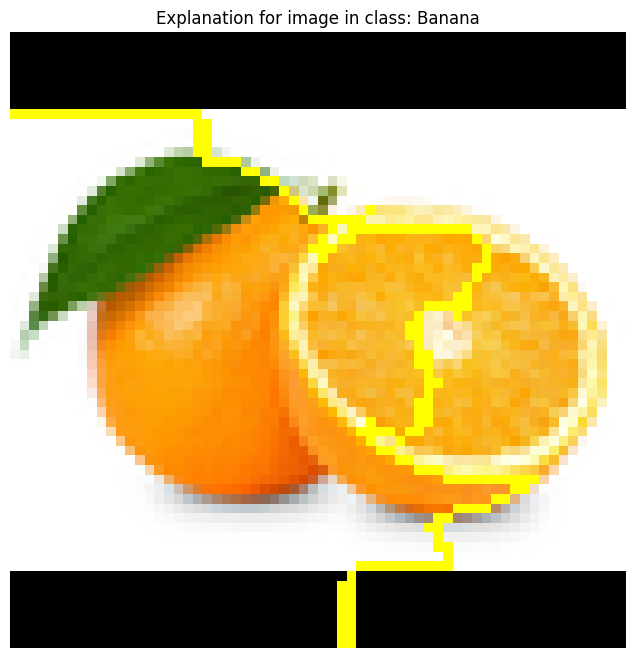

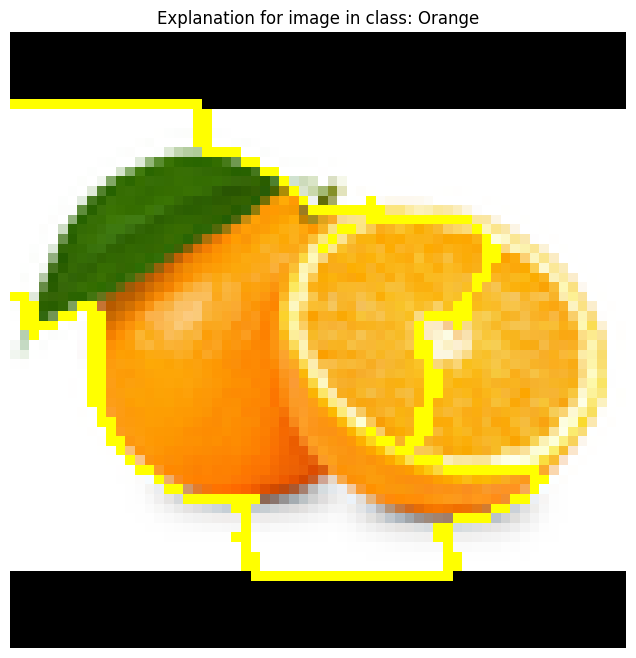

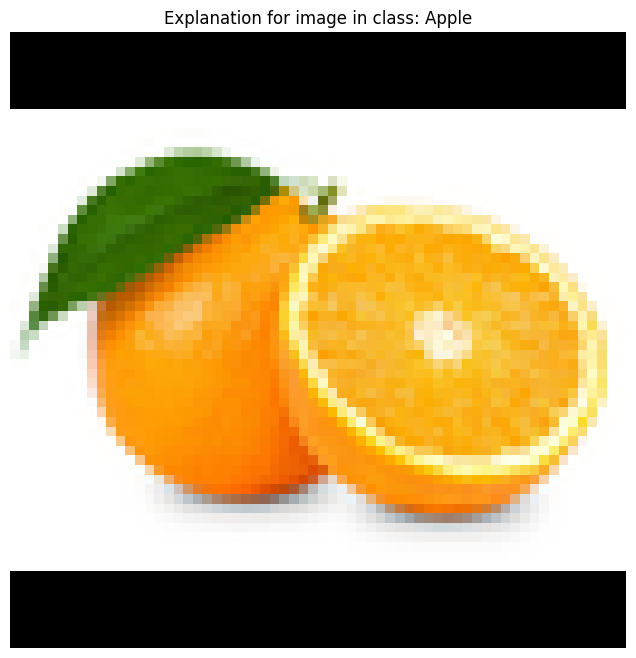

100%|██████████| 1000/1000 [00:01<00:00, 848.90it/s]


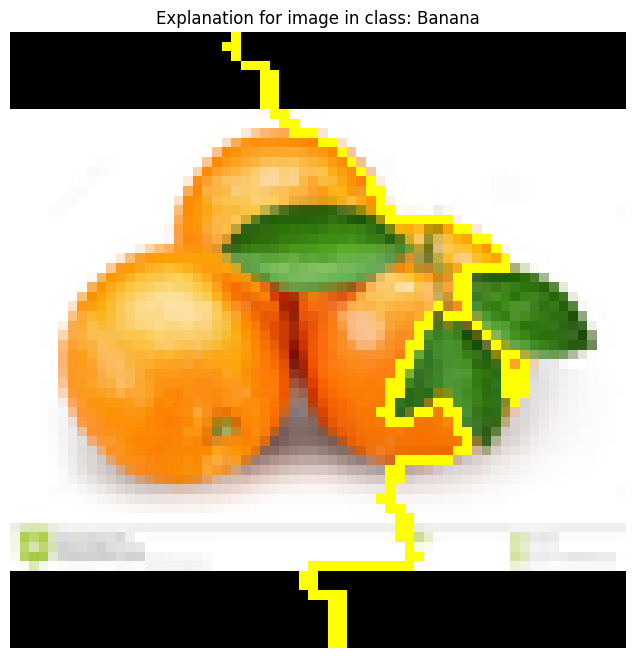

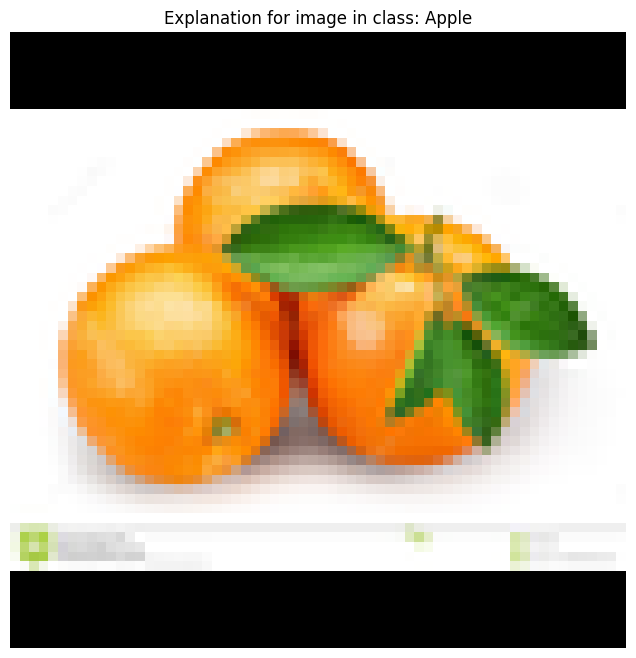

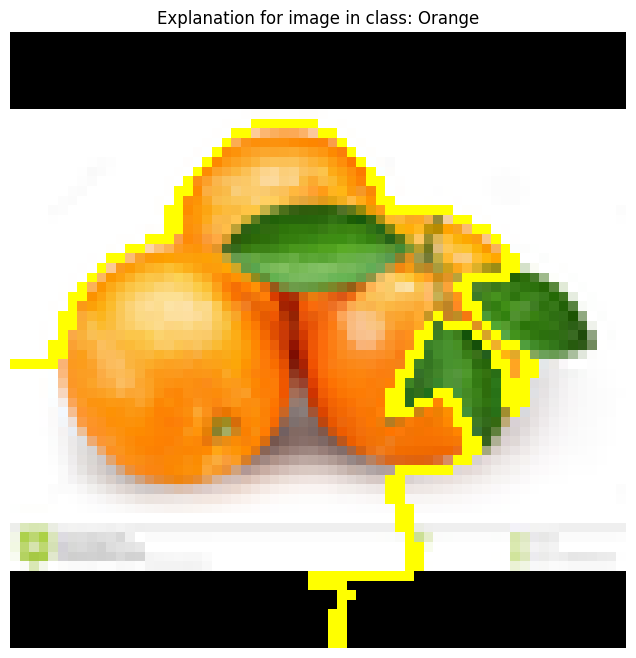

100%|██████████| 1000/1000 [00:01<00:00, 850.34it/s]


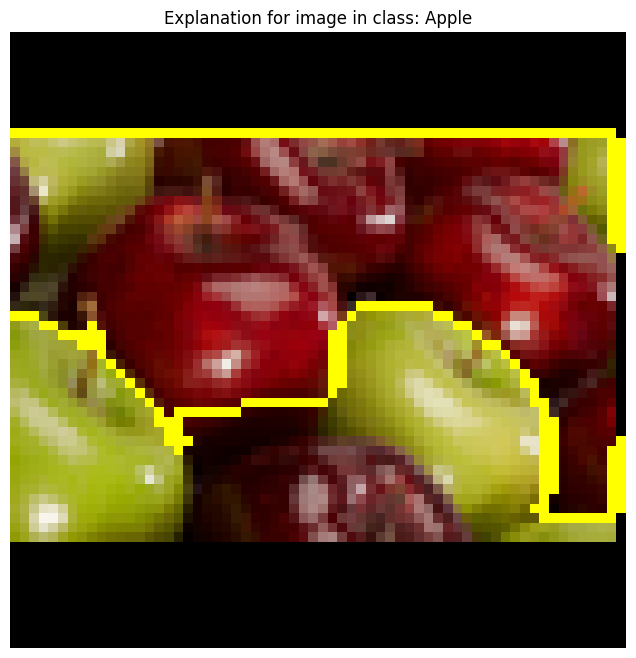

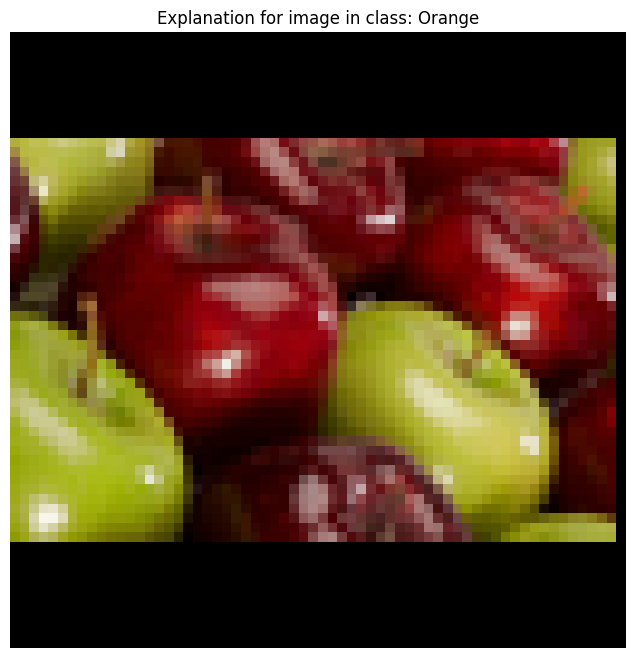

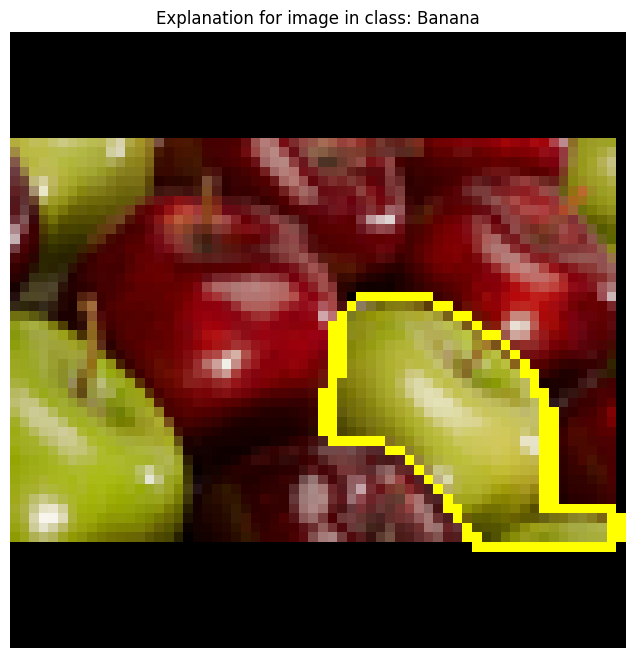

100%|██████████| 1000/1000 [00:01<00:00, 839.63it/s]


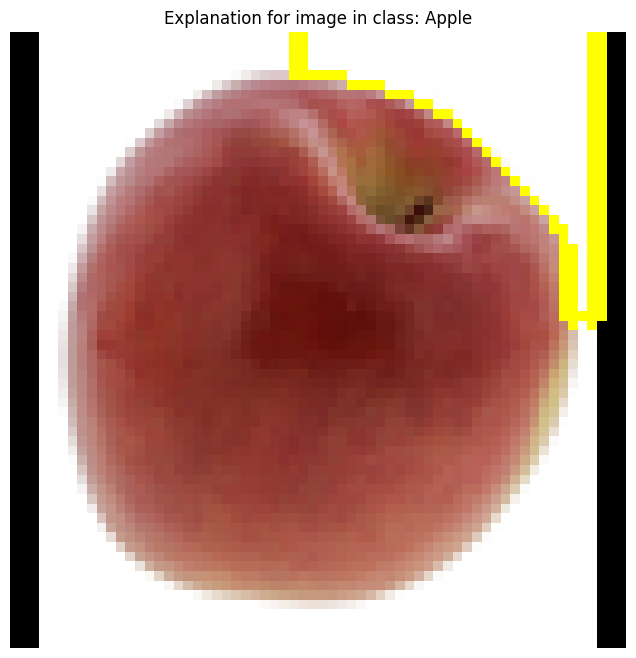

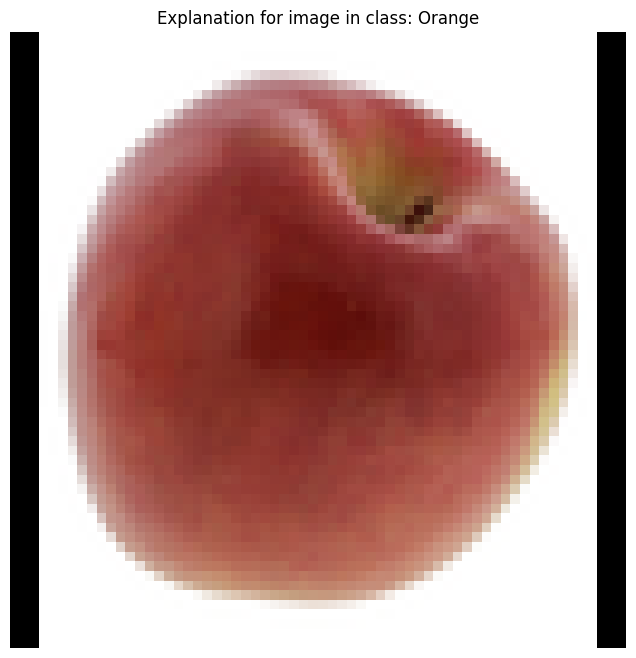

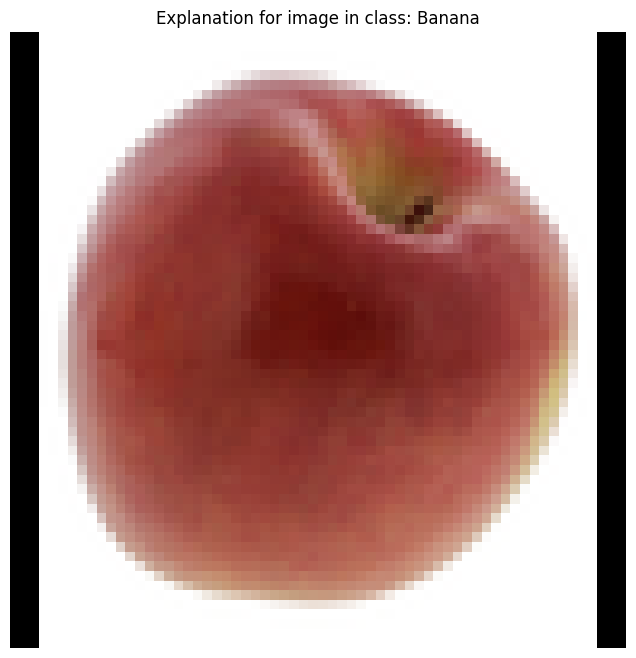

100%|██████████| 1000/1000 [00:01<00:00, 803.86it/s]


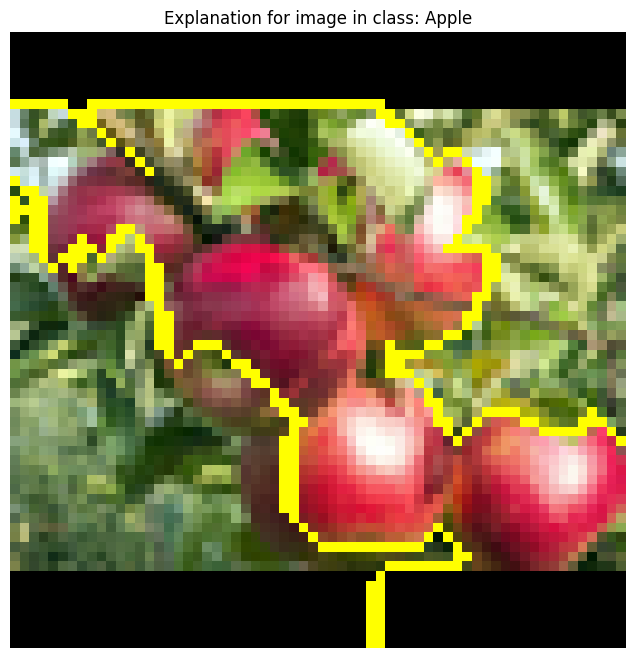

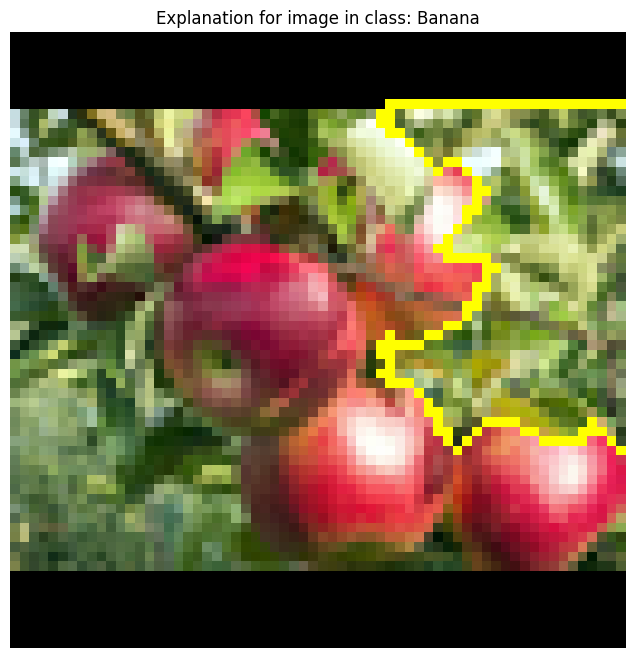

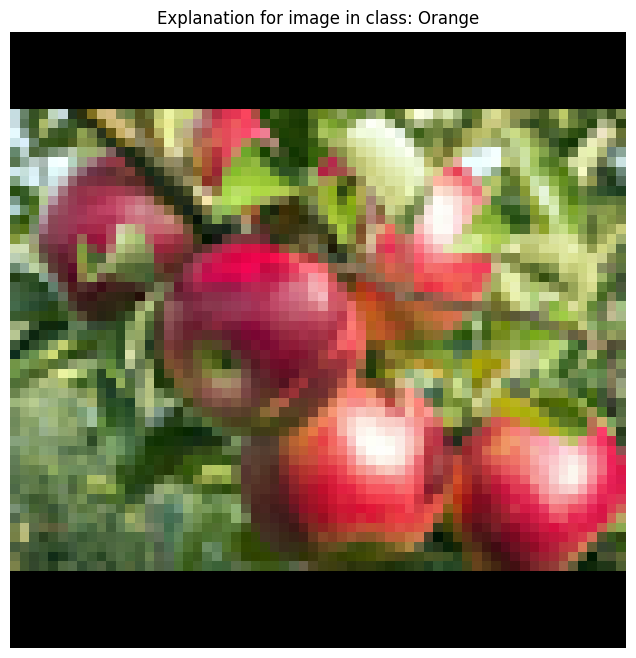

100%|██████████| 1000/1000 [00:00<00:00, 1036.27it/s]


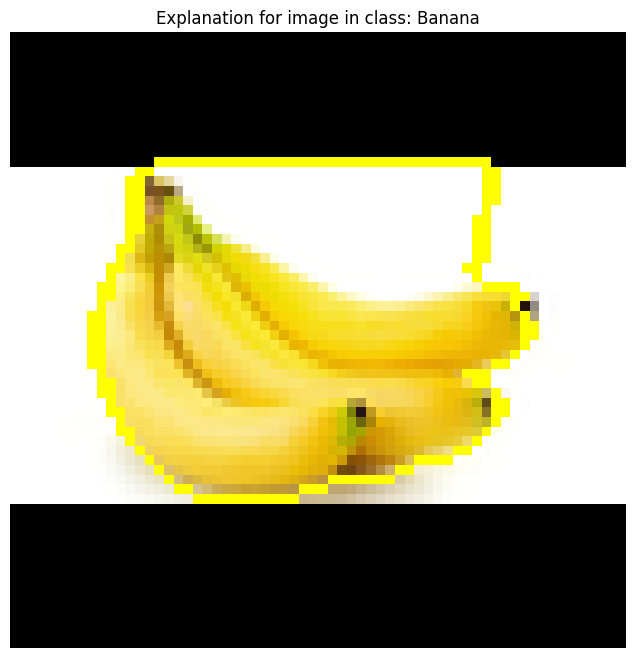

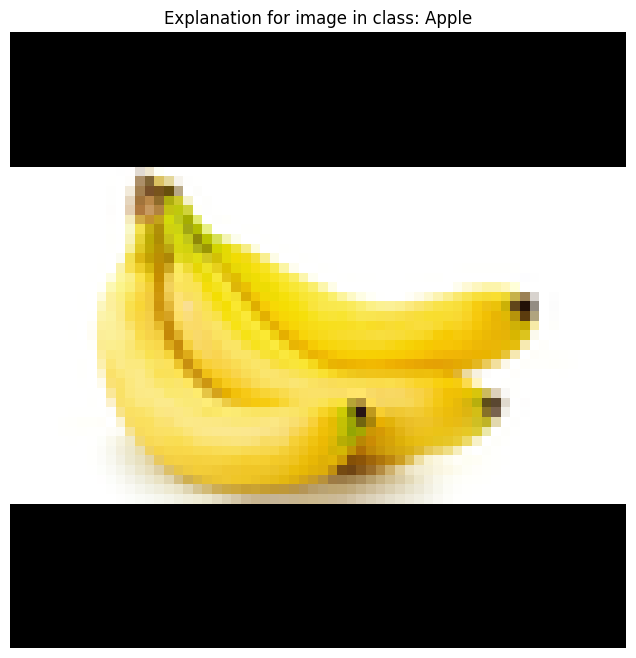

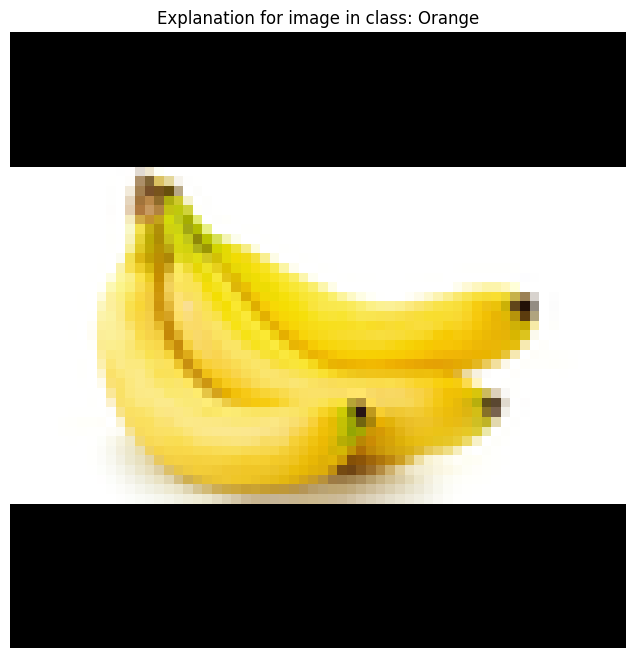

100%|██████████| 1000/1000 [00:01<00:00, 836.12it/s]


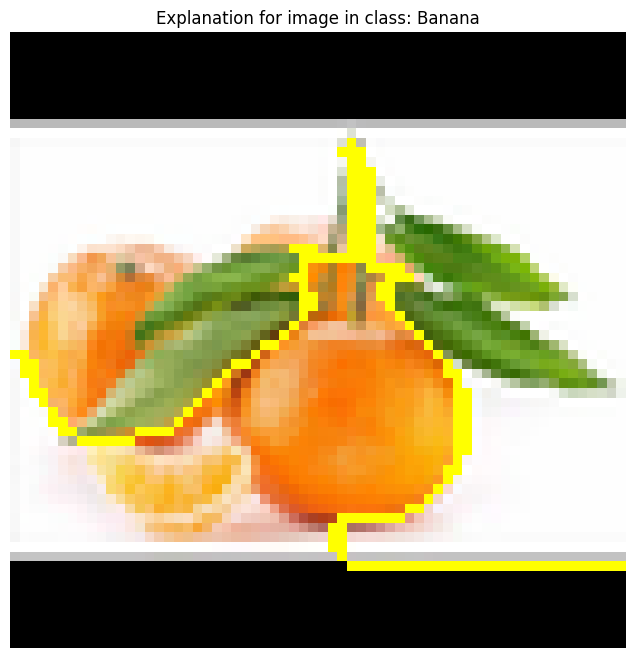

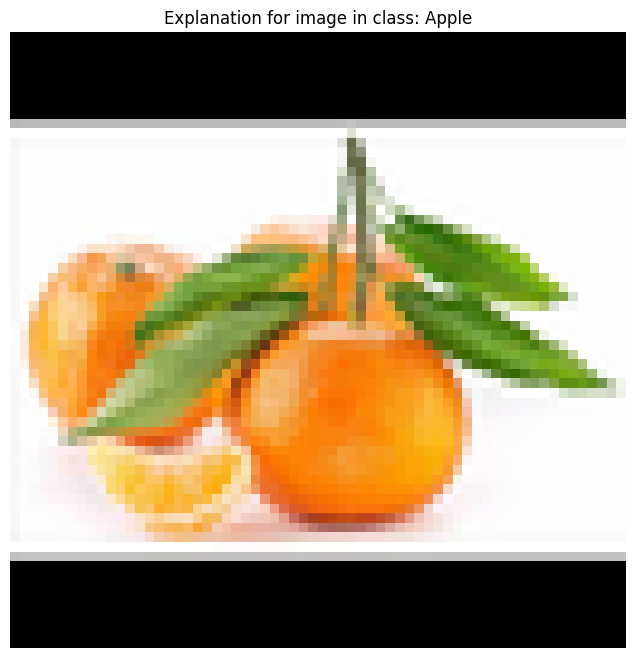

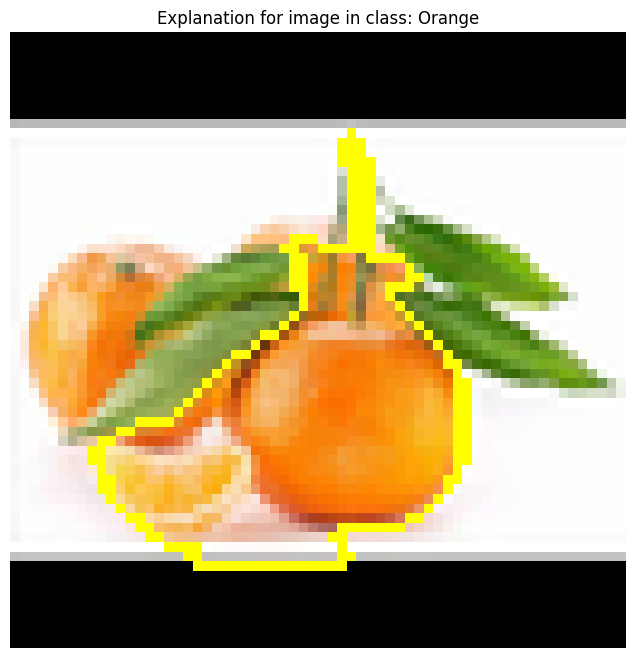

100%|██████████| 1000/1000 [00:01<00:00, 827.13it/s]


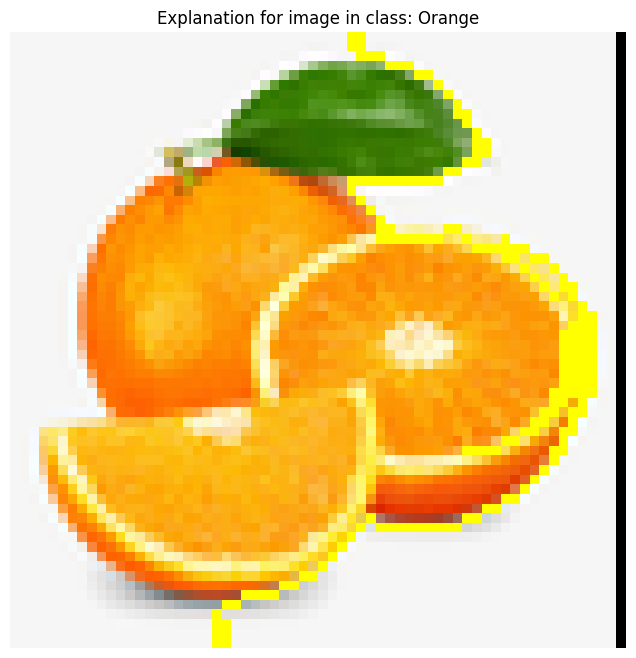

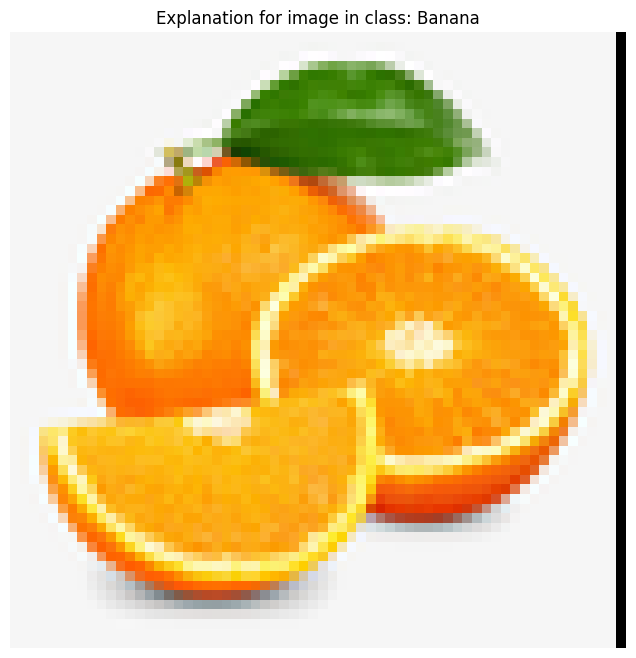

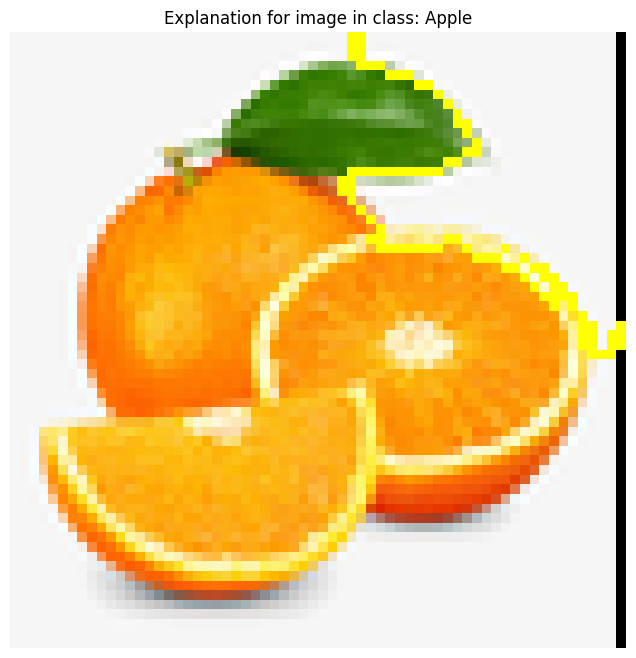

100%|██████████| 1000/1000 [00:01<00:00, 856.90it/s]


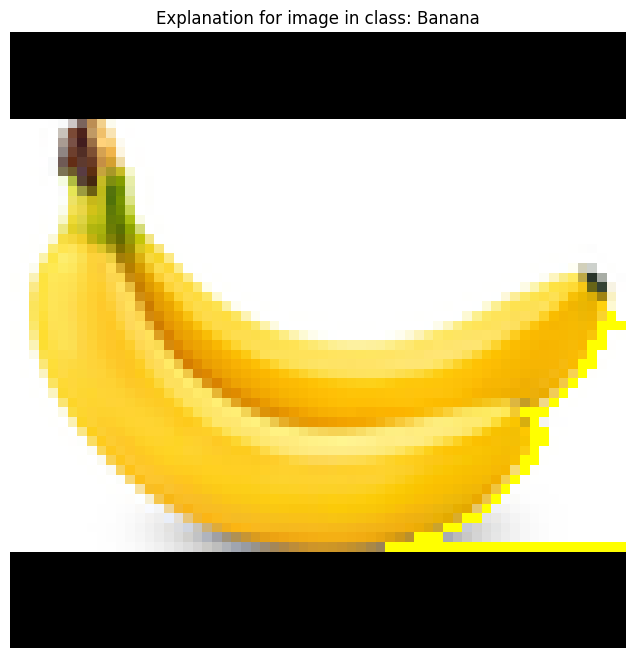

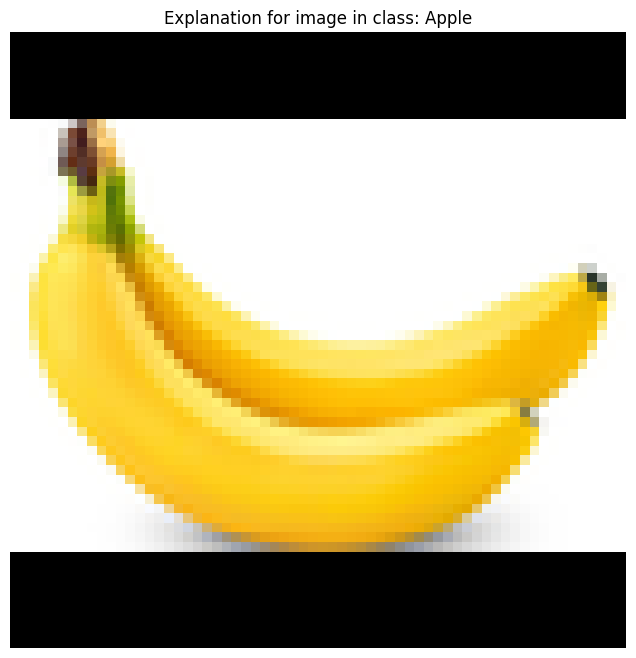

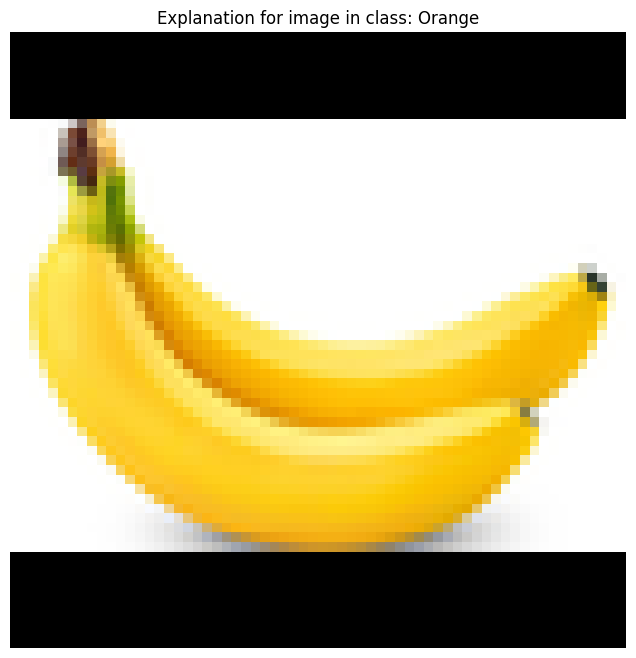

100%|██████████| 1000/1000 [00:01<00:00, 847.46it/s]


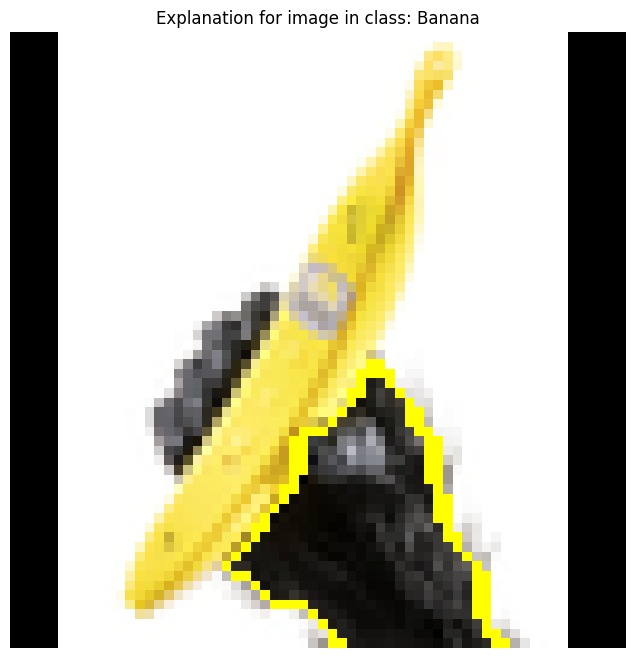

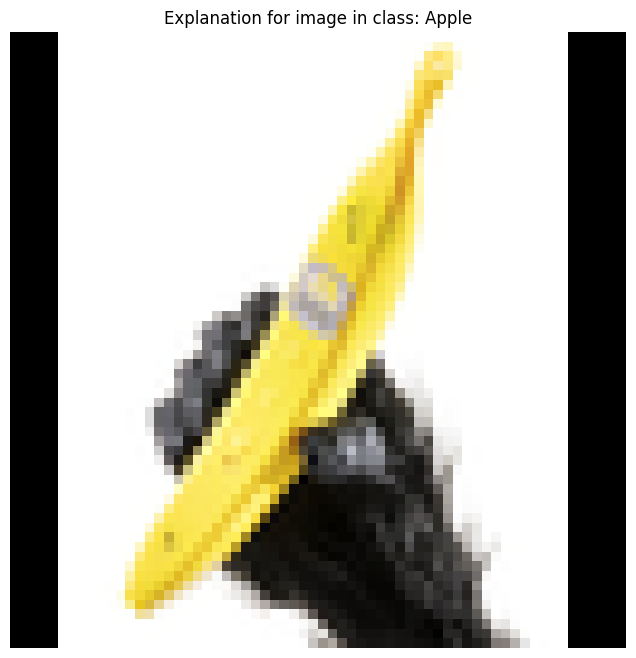

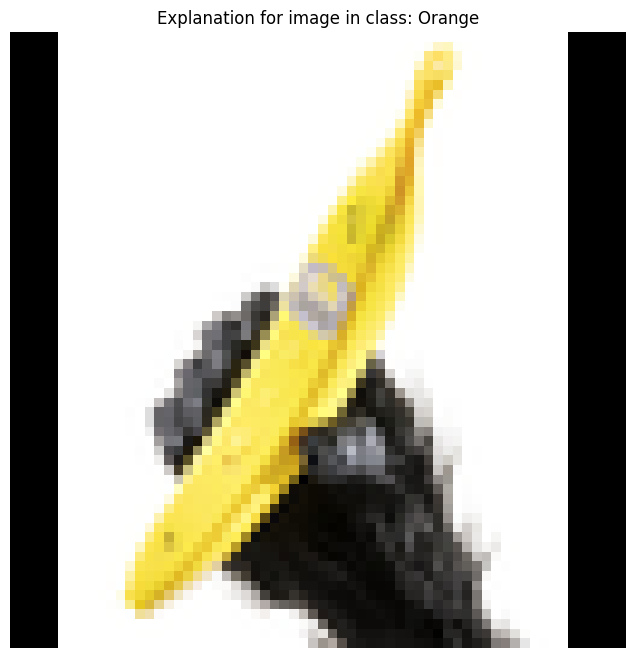

In [86]:
# Model Explainability


dataset = datasets.ImageFolder(root='Datasets\\mbkinaci\\fruit-images-for-object-detection\\test', transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
class_names = dataset.classes 

def lime_e(model, data_loader, class_names, device='cuda'):
    model.eval()

    for inputs, labels in data_loader:
        sample_data = inputs.to(device) 
        label = labels.item()

        image = sample_data[0].cpu().numpy().transpose(1, 2, 0)

        def predict_fn(images):
            model_input = torch.tensor(images.transpose(0, 3, 1, 2)).float().to(device)
            model_input = model_input.contiguous()
            outputs = model(model_input)
            probabilities = torch.softmax(outputs, dim=1)
            return probabilities.detach().cpu().numpy()


        explainer = lime_image.LimeImageExplainer()

        explanation = explainer.explain_instance(
            image,
            predict_fn,
            top_labels=len(class_names),
            hide_color=0,
            num_samples=1000
        )

        for class_idx in explanation.top_labels:
            temp, mask = explanation.get_image_and_mask(
                label=class_idx,
                positive_only=True,
                hide_rest=False,
                num_features=5,
                min_weight=0.1
            )
            plt.figure(figsize=(8, 8))
            plt.imshow(mark_boundaries(temp, mask))
            plt.title(f"Explanation for image in class: {class_names[class_idx]}")
            plt.axis("off")
            plt.show()

        #break  

lime_e(model, data_loader, class_names)


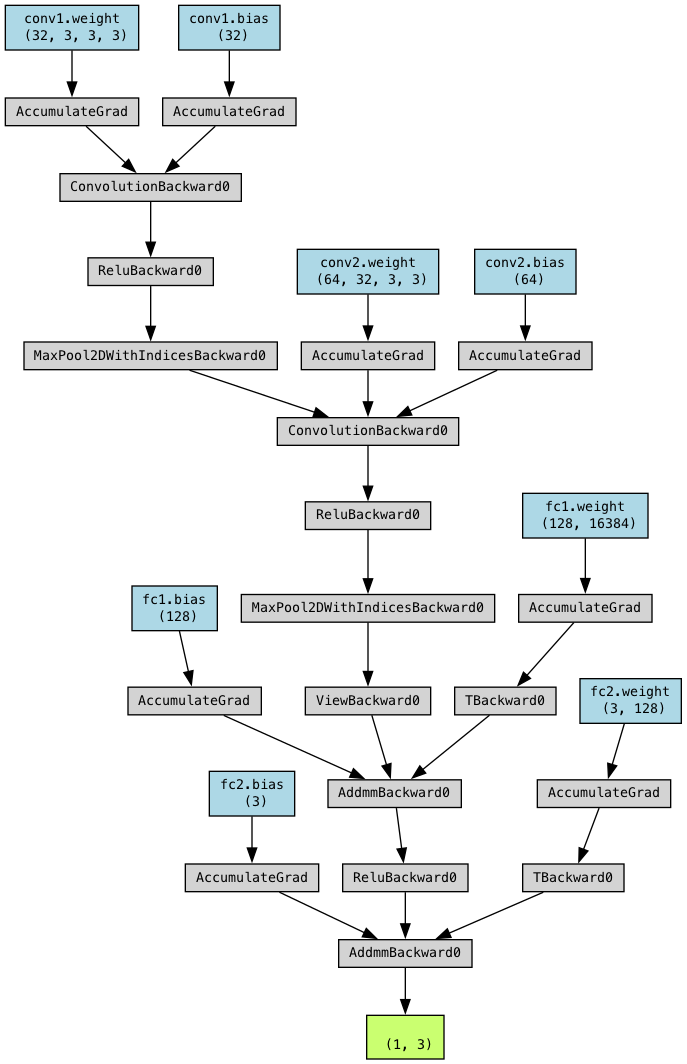

In [ ]:
# Model Architecture
x = torch.randn(1, 3, 64, 64)

dot = make_dot(model(x), params=dict(model.named_parameters()))


displayImage(dot.pipe(format="png"))